In [1]:
import scdrs
import scanpy as sc
sc.set_figure_params(dpi=125)
import anndata as ad
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from pathlib import Path
import gdown
import mygene
import data_processing_utils
from scipy.sparse.csgraph import connected_components
from scipy.stats import hypergeom
warnings.filterwarnings("ignore")

In [2]:
PROJECT_DIR = Path("/work/magroup/shared/Heimdall")
#################################

DATA_DIR = PROJECT_DIR / "data" / "polygenic_disease_risk"
RAW_DATA_DIR = DATA_DIR / "raw"
RAW_DATA_GENE_DIR = DATA_DIR / "raw" / "gene_expression_data"
RAW_DATA_SCDRS_DIR = DATA_DIR / "raw" / "score_files"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

print(f"Raw data will be saved to: {RAW_DATA_DIR}")
print(f"Processed data will be saved to: {PROCESSED_DATA_DIR}")

Raw data will be saved to: /work/magroup/shared/Heimdall/data/polygenic_disease_risk/raw
Processed data will be saved to: /work/magroup/shared/Heimdall/data/polygenic_disease_risk/processed


# scRNAseq Data

The TMS FACS data were downloaded from the official release https://figshare.com/articles/dataset/Processed_files_to_use_with_scanpy_/8273102.

Please refer to the scDRS paper (https://www.nature.com/articles/s41588-022-01167-z) for detailed information.

In [3]:
# ! wget -O {RAW_DATA_GENE_DIR}/tabula-muris-senis-facs-official-raw-obj.h5ad https://figshare.com/ndownloader/files/23939711

In [4]:
data = ad.read_h5ad(f"{RAW_DATA_GENE_DIR}/tabula-muris-senis-facs-official-raw-obj.h5ad") 

In [5]:
data

AnnData object with n_obs × n_vars = 110824 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells'

In [6]:
data.X.shape

(110824, 22966)

In [7]:
data.var

,n_cells
index,
0610005C13Rik,3939
0610007C21Rik,61891
0610007L01Rik,36115
0610007N19Rik,19591
0610007P08Rik,12581
...,...
Zyg11a,276
Zyg11b,23165
Zyx,58021


In [8]:
# Gene id mapping
symbol_to_ensembl_mapping = data_processing_utils.symbol_to_ensembl_from_ensembl(
    data_dir=PROJECT_DIR / "data", genes=data.var.index.tolist(), species="mouse")
data.uns["gene_mapping:symbol_to_ensembl"] = symbol_to_ensembl_mapping.mapping_full

data.var["gene_symbol"] = data.var.index
data.var["gene_ensembl"] = data.var["gene_symbol"].map(symbol_to_ensembl_mapping.mapping_combined.get)
data.var.index = data.var.index.map(symbol_to_ensembl_mapping.mapping_reduced)

data.var

Mapping data directory: /work/magroup/shared/Heimdall/data/gene_mapping/ensembl/mouse
Loading mapping from cache: /work/magroup/shared/Heimdall/data/gene_mapping/ensembl/mouse/symbol_to_ensembl.json
Successfully mapped 18,828 out of 22,966 genes (82.0%)


,n_cells,gene_symbol,gene_ensembl
index,,,
ENSMUSG00000109644,3939,0610005C13Rik,ENSMUSG00000109644
0610007C21Rik,61891,0610007C21Rik,N/A
0610007L01Rik,36115,0610007L01Rik,N/A
0610007N19Rik,19591,0610007N19Rik,N/A
0610007P08Rik,12581,0610007P08Rik,N/A
...,...,...,...
ENSMUSG00000034645,276,Zyg11a,ENSMUSG00000034645
ENSMUSG00000034636,23165,Zyg11b,ENSMUSG00000034636
ENSMUSG00000029860,58021,Zyx,ENSMUSG00000029860


In [9]:
# Filter the obs DataFrame to exclude rows where gene_ensembl is NA
filtered_var = data.var[data.var['gene_ensembl'] != 'N/A']

# Subset the AnnData object to include only the variables with non-NA gene_ensembl
data = data[:, filtered_var.index].copy()

In [10]:
data

AnnData object with n_obs × n_vars = 110824 × 18828
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells', 'gene_symbol', 'gene_ensembl'
    uns: 'gene_mapping:symbol_to_ensembl'

In [11]:
data.var

,n_cells,gene_symbol,gene_ensembl
index,,,
ENSMUSG00000109644,3939,0610005C13Rik,ENSMUSG00000109644
ENSMUSG00000043644,8404,0610009L18Rik,ENSMUSG00000043644
ENSMUSG00000020831,44798,0610010K14Rik,ENSMUSG00000020831
ENSMUSG00000058706,27058,0610030E20Rik,ENSMUSG00000058706
ENSMUSG00000099146,680,0610031O16Rik,ENSMUSG00000099146
...,...,...,...
ENSMUSG00000034645,276,Zyg11a,ENSMUSG00000034645
ENSMUSG00000034636,23165,Zyg11b,ENSMUSG00000034636
ENSMUSG00000029860,58021,Zyx,ENSMUSG00000029860


# scDRS Files Inspection

Source: https://figshare.com/articles/dataset/scDRS_data_release_092121_score_file_tmsfacs/16664077

In [12]:
# ! wget -O {RAW_DATA_SCDRS_DIR}/scDRS_data_release_030122.zip https://figshare.com/ndownloader/articles/16664077/versions/3
# ! unzip {RAW_DATA_SCDRS_DIR}/scDRS_data_release_030122.zip '*.score.gz'
# ! for file in {RAW_DATA_DIR}/gene_expression_data/*.score.gz; do gunzip "$file"; done

In [13]:
df_Alzheimers = pd.read_csv(RAW_DATA_SCDRS_DIR / "PASS_Alzheimers_Jansen2019.score", delimiter='\t') 
df_Alzheimers.head()

,index,raw_score,norm_score,mc_pval,pval,nlog10_pval,zscore
0,A10_B000497_B009023_S10.mm10-plus-0-0,0.087550,1.502652,0.074925,0.072984,1.136771,1.453921
1,A10_B000756_B007446_S10.mm10-plus-0-0,0.127090,2.140916,0.027972,0.023351,1.631691,1.988990
2,A10_B000802_B009022_S10.mm10-plus-0-0,0.077405,0.166168,0.433566,0.413432,0.383596,0.218726
3,A10_B000927_B007456_S10.mm10-plus-0-0,0.037681,0.013627,0.469530,0.473454,0.324722,0.066590
4,A10_B001361_B007505_S10.mm10-plus-0-0,0.075004,-0.152361,0.537463,0.540573,0.267146,-0.101877


In [14]:
df_Alzheimers.describe()

,raw_score,norm_score,mc_pval,pval,nlog10_pval,zscore
count,110824.000000,1.108240e+05,110824.000000,110824.000000,110824.000000,110824.000000
mean,0.071294,1.397959e-10,0.502054,0.501389,0.445708,-0.005395
std,0.015375,1.051325e+00,0.297618,0.297633,0.459733,1.051238
min,-0.051889,-3.849838e+00,0.000999,0.000003,0.000001,-4.541164
25%,0.062038,-7.393628e-01,0.239760,0.237823,0.116211,-0.723210
50%,0.071476,-5.998576e-02,0.503497,0.503078,0.298365,-0.007716
75%,0.080770,6.802779e-01,0.765235,0.765225,0.623746,0.713323
max,0.185757,6.019493e+00,1.000000,0.999997,5.582236,4.555202


In [15]:
np.sum(np.array(df_Alzheimers['pval']<0.05)), np.sum(np.array(df_Alzheimers['pval']>0.05))

(6473, 104351)

# Classification task

In [16]:
pvalue_list = []

# Iterate over all files in the directory
for file_name in os.listdir(RAW_DATA_SCDRS_DIR):
    if file_name.endswith('.score'):  
        file_path = os.path.join(RAW_DATA_SCDRS_DIR, file_name)
        score_df = pd.read_csv(file_path, sep='\t') 
        # Remove the '.score' part from the file name
        column_name = file_name.replace('.score', '')
        # Extract the 'norm_score' column and rename it with the cleaned file name
        norm_score_column = score_df['pval'].rename(column_name)
        pvalue_list.append(norm_score_column)


In [17]:
# Combine all norm_score columns into a single DataFrame
all_pvalues = pd.concat(pvalue_list, axis=1)
print(all_pvalues.shape)
print(all_pvalues.head())

(110824, 26)
   PASS_Rheumatoid_Arthritis  UKB_460K.disease_HYPERTENSION_DIAGNOSED  \
0                   0.487066                                 0.893925   
1                   0.594168                                 0.520755   
2                   0.980690                                 0.985903   
3                   0.999510                                 0.233274   
4                   0.609506                                 0.515097   

   UKB_460K.disease_RESPIRATORY_ENT  PASS_Schizophrenia_Pardinas2018  \
0                          0.539877                         0.922330   
1                          0.829802                         0.005325   
2                          0.389341                         0.080543   
3                          0.838640                         0.803404   
4                          0.704271                         0.506975   

   PASS_CD_deLange2017  PASS_AtrialFibrillation_Nielsen2018  \
0             0.460777                             0

In [18]:
# rename the columns
file_path = RAW_DATA_DIR / 'filtered_trait_info.csv'  # Adjust the path if necessary
trait_info = pd.read_csv(file_path)

trait_info

,Trait Name,Trait_Identifier
0,Crohn's Disease,PASS_CD_deLange2017
1,Celiac Disease,PASS_Celiac
2,Inflammatory Bowel Disease,PASS_IBD_deLange2017
3,Systemic Lupus Erythematosus,PASS_Lupus
4,Multiple Sclerosis,PASS_Multiple_sclerosis
5,Primary Biliary Cirrhosis,PASS_Primary_biliary_cirrhosis
6,Rheumatoid Arthritis,PASS_Rheumatoid_Arthritis
7,Ulcerative Colitis,PASS_UC_deLange2017
8,Auto Immune Traits,UKB_460K.disease_AID_ALL
9,Eczema,UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED


In [19]:

trait_mapping = pd.Series(trait_info['Trait Name'].values, index=trait_info['Trait_Identifier']).to_dict()

# Rename the columns of all_pvalues based on this mapping
all_pvalues_renamed = all_pvalues.rename(columns=trait_mapping)
all_pvalues_renamed


,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
0,0.487066,0.893925,0.539877,0.922330,0.460777,0.516316,0.416947,0.072984,0.294136,0.410679,...,0.334898,0.269867,0.848869,0.113748,0.178955,0.607870,0.580834,0.455838,0.228882,0.394639
1,0.594168,0.520755,0.829802,0.005325,0.491892,0.256611,0.680888,0.023351,0.186830,0.089809,...,0.394200,0.656721,0.587161,0.087176,0.178866,0.105403,0.001238,0.714677,0.818913,0.041913
2,0.980690,0.985903,0.389341,0.080543,0.638916,0.279882,0.528493,0.413432,0.296873,0.952203,...,0.850077,0.931020,0.844472,0.886834,0.844932,0.455205,0.458516,0.815630,0.034793,0.136875
3,0.999510,0.233274,0.838640,0.803404,0.578818,0.220227,0.217132,0.473454,0.284771,0.496614,...,0.572008,0.837863,0.522913,0.822625,0.481650,0.719836,0.889184,0.329581,0.434490,0.806100
4,0.609506,0.515097,0.704271,0.506975,0.086856,0.419941,0.124715,0.540573,0.681576,0.568640,...,0.796862,0.211736,0.452405,0.166884,0.305435,0.291813,0.644419,0.233622,0.395188,0.705798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110819,0.925350,0.901691,0.428387,0.852063,0.628842,0.309207,0.647583,0.161849,0.621620,0.683178,...,0.577867,0.635243,0.857733,0.834034,0.462837,0.472992,0.022493,0.649964,0.373554,0.084868
110820,0.152410,0.248790,0.087425,0.673672,0.423952,0.575628,0.463855,0.020375,0.864789,0.257342,...,0.339933,0.497865,0.572390,0.278493,0.507025,0.361302,0.579284,0.036488,0.358780,0.032356
110821,0.507572,0.405691,0.453333,0.430708,0.664791,0.273794,0.933825,0.287097,0.822248,0.214761,...,0.315610,0.483347,0.818446,0.298059,0.706076,0.523771,0.433930,0.164144,0.248360,0.046419
110822,0.136598,0.792124,0.059595,0.564933,0.108701,0.576422,0.788226,0.311077,0.977306,0.976967,...,0.583013,0.457511,0.873028,0.282881,0.702291,0.771322,0.074064,0.395167,0.103179,0.207996


In [20]:
# Set the p-value threshold
pval_threshold = 0.05

# Create a binary matrix where p-values < 0.05 are set to 1, and others are set to 0
binary_matrix = (all_pvalues_renamed < pval_threshold).astype(int)

# binary_matrix now contains 1s and 0s based on the p-value threshold
binary_matrix 

,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110819,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
110820,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
110821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
110822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Check distribution
counts_per_disease = binary_matrix.apply(lambda col: col.value_counts())
counts_per_disease 

,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
0,97809,103050,100314,102175,99484,104203,100127,104351,102562,102903,...,103889,99438,96703,100197,103464,104457,103317,103535,103992,102292
1,13015,7774,10510,8649,11340,6621,10697,6473,8262,7921,...,6935,11386,14121,10627,7360,6367,7507,7289,6832,8532


In [22]:
# Compute pairwise overlap coefficient matrix
def compute_overlap_coefficient(binary_matrix):
    n_diseases = binary_matrix.shape[1]
    overlap_matrix = np.zeros((n_diseases, n_diseases))
    
    for i in range(n_diseases):
        for j in range(i, n_diseases):  
            A = binary_matrix.iloc[:, i]
            B = binary_matrix.iloc[:, j]
            shared = (A & B).sum()  # Number of shared positive examples
            min_size = min(A.sum(), B.sum())  # Minimum number of positive examples
            if min_size > 0:  # To avoid division by zero
                overlap_matrix[i, j] = overlap_matrix[j, i] = shared / min_size

    return overlap_matrix

In [23]:
overlap_matrix = compute_overlap_coefficient(binary_matrix)
overlap_matrix.shape

(26, 26)

In [24]:
# Set an overlap threshold. Apply threshold to create binary overlap matrix
def binarize_overlap_matrix(overlap_matrix, threshold=0.75):
    binary_overlap_matrix = (overlap_matrix >= threshold).astype(int)
    return binary_overlap_matrix

In [25]:
binary_overlap_matrix = binarize_overlap_matrix(overlap_matrix, threshold=0.75)
binary_overlap_matrix.shape

(26, 26)

In [26]:
if np.all(np.diag(binary_overlap_matrix) == 1) and np.count_nonzero(binary_overlap_matrix - np.diag(np.diag(binary_overlap_matrix))) == 0:
    print("The matrix is diagonal. No redundant diseases.")
    representative_diseases = binary_matrix.columns  # All diseases are non-redundant
    print("All diseases are non-redundant")
else:
    print("Not all diseases are non-redundant")

Not all diseases are non-redundant


In [27]:
n_components, labels = connected_components(csgraph=binary_overlap_matrix, directed=False, connection='strong')
    
representative_diseases_indices = []
filtered_out_diseases_indices = {}  

for component in range(n_components):
    disease_indices = np.where(labels == component)[0]
    if len(disease_indices) == 1:
        # If only one disease in the component, keep it
        representative_diseases_indices.append(disease_indices[0])
    else:
        print(component)
        # Select the disease with the most positive examples in this component
        positive_counts = binary_matrix.iloc[:, disease_indices].sum(axis=0)
        print(positive_counts)
        representative_disease_indices = disease_indices[positive_counts.argmax()]
        representative_diseases_indices.append(representative_disease_indices)
        
        # Find the diseases that are filtered out (all except the representative one)
        filtered_diseases_indices = set(disease_indices) - {representative_disease_indices}
        filtered_out_diseases_indices[representative_disease_indices] = list(filtered_diseases_indices)

2
Respiratory and Ear-nose-throat Diseases    10510
Asthma                                      10428
dtype: int64


In [28]:
# Get the disease names corresponding to representative and filtered-out indices
representative_diseases = binary_matrix.columns[representative_diseases_indices]
print(len(representative_diseases))
print(representative_diseases)

25
Index(['Rheumatoid Arthritis', 'Hyperthension',
       'Respiratory and Ear-nose-throat Diseases', 'Schizophrenia',
       'Crohn's Disease', 'Atrial Fibrillation', 'Inflammatory Bowel Disease',
       'Alzheimer's Disease', 'Ulcerative Colitis', 'Celiac Disease',
       'Coronary Artery Disease', 'Hypothyroidism', 'Eczema',
       'Auto Immune Traits', 'Type 1 Diabetes', 'Cardiovascular Diseases',
       'Primary Biliary Cirrhosis', 'Multiple Sclerosis',
       'Systemic Lupus Erythematosus', 'Type 2 Diabetes',
       'Attention Deficit Hyperactivity Disorder', 'Bipolar Disorder',
       'Insomnia', 'Breast Cancer', 'Major Depressive Disorder'],
      dtype='object')


In [29]:
# Map filtered-out disease indices back to names and print them
for rep_disease_idx, filtered_indices in filtered_out_diseases_indices.items():
    rep_disease_name = binary_matrix.columns[rep_disease_idx]
    filtered_disease_names = binary_matrix.columns[filtered_indices]
    
    print(f"Representative disease: {rep_disease_name}")
    print("Filtered out diseases:")
    for disease in filtered_disease_names:
        print(f"  - {disease}")
    print()  

Representative disease: Respiratory and Ear-nose-throat Diseases
Filtered out diseases:
  - Asthma



In [30]:
# Filter out redundant disease "Asthma"
redundant_diseases = ["Asthma"]  
binary_matrix_filtered = binary_matrix.drop(columns=redundant_diseases)
binary_matrix_filtered.shape

(110824, 25)

In [31]:
binary_matrix_filtered.head()

,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Set up negative examples
# Criterion: It is insignificant and a positive example for a disease that is significantly different from the target disease (using the hypergeometric test).


# To compute the hypergeometric p-value between two diseases
def hypergeometric_p_value(target_disease, other_disease, binary_matrix):
    N = binary_matrix.shape[0]  # Total number of cells (rows)
    K = binary_matrix[target_disease].sum()  # Number of positive examples for target disease
    n = binary_matrix[other_disease].sum()  # Number of positive examples for other disease
    k = (binary_matrix[target_disease] & binary_matrix[other_disease]).sum()  # Overlap

    # Perform the hypergeometric test
    p_val = hypergeom.sf(k - 1, N, K, n)
    return p_val

# Set up negative examples for a target disease
def set_negative_examples(binary_matrix_filtered, p_value_threshold=0.05):
    negative_matrix = pd.DataFrame(0, index=binary_matrix_filtered.index, columns=binary_matrix_filtered.columns)

    for target_disease in binary_matrix_filtered.columns:
        for other_disease in binary_matrix_filtered.columns:
            if target_disease != other_disease:
                # Compute the hypergeometric p-value between the target disease and other disease
                p_val = hypergeometric_p_value(target_disease, other_disease, binary_matrix_filtered)

                # If the diseases are significantly different (p-value < threshold), mark negative examples
                if p_val < p_value_threshold:
                    # Cells that are positive examples for the other disease become negative examples for the target disease
                    negative_matrix[target_disease] |= binary_matrix_filtered[other_disease]

    return negative_matrix


In [33]:
# Apply the negative example setup process
negative_examples = set_negative_examples(binary_matrix_filtered)
negative_examples.head()

,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
2,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,1,0,1,1,1,1,...,1,1,1,1,0,1,0,0,0,0


In [34]:
def create_combined_matrix(binary_matrix_filtered, negative_examples):
    # Initialize the combined matrix with 2 (neither)
    combined_matrix = pd.DataFrame(2, index=binary_matrix_filtered.index, columns=binary_matrix_filtered.columns)
    
    # Set 1 where the original binary matrix has positive examples
    combined_matrix[binary_matrix_filtered == 1] = 1
    
    # Set 0 where the negative examples matrix has negative examples 
    # The cell is insignificant for the target disease (i.e., it has a value of 0 in the binary matrix for the target disease).
    # The cell is a positive example for another disease (i.e., it has a value of 1 in the binary_matrix for that other disease).
    combined_matrix[(negative_examples == 1) & (binary_matrix_filtered == 0)] = 0
    
    return combined_matrix

In [35]:
# The combined_matrix now contains 0 for negative, 1 for positive, and 2 for neither

# Create the combined matrix
combined_matrix = create_combined_matrix(binary_matrix_filtered, negative_examples)
print(combined_matrix.shape)
combined_matrix.head() 

(110824, 25)


,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,2,0,2,1,0,0,0,1,0,2,...,0,0,0,0,0,0,1,0,0,1
2,2,0,2,2,2,0,2,2,2,2,...,0,2,2,2,0,2,2,2,1,2
3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,0,2,0,2,0,2,0,0,0,0,...,0,0,0,0,2,0,2,2,2,2


In [36]:
# Check distribution
counts_per_disease = combined_matrix.apply(lambda col: col.value_counts())
counts_per_disease 

,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
0,37538,44341,43303,38279,41815,60217,39060,45833,41495,42632,...,56001,44781,42355,42528,43106,58858,34759,35180,22735,33937
1,13015,7774,10510,8649,11340,6621,10697,6473,8262,7921,...,6935,11386,14121,10627,7360,6367,7507,7289,6832,8532
2,60271,58709,57011,63896,57669,43986,61067,58518,61067,60271,...,47888,54657,54348,57669,60358,45599,68558,68355,81257,68355


In [37]:
# Filter out cells whose values are 2

rows_to_drop = (combined_matrix == 2).all(axis=1)

indices_to_drop = combined_matrix.index[rows_to_drop].tolist()

combined_matrix_filtered = combined_matrix.loc[~rows_to_drop]

print(combined_matrix_filtered.shape)
combined_matrix_filtered.head()

(75918, 25)


,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
1,2,0,2,1,0,0,0,1,0,2,...,0,0,0,0,0,0,1,0,0,1
2,2,0,2,2,2,0,2,2,2,2,...,0,2,2,2,0,2,2,2,1,2
4,0,2,0,2,0,2,0,0,0,0,...,0,0,0,0,2,0,2,2,2,2
5,1,0,0,0,1,0,0,0,0,0,...,0,1,1,1,0,0,0,2,2,2
6,2,0,2,0,2,0,2,2,2,2,...,0,2,2,2,0,0,0,0,2,1


In [38]:
# Check distribution
counts_per_disease = combined_matrix_filtered.apply(lambda col: col.value_counts())
counts_per_disease 

,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
0,37538,44341,43303,38279,41815,60217,39060,45833,41495,42632,...,56001,44781,42355,42528,43106,58858,34759,35180,22735,33937
1,13015,7774,10510,8649,11340,6621,10697,6473,8262,7921,...,6935,11386,14121,10627,7360,6367,7507,7289,6832,8532
2,25365,23803,22105,28990,22763,9080,26161,23612,26161,25365,...,12982,19751,19442,22763,25452,10693,33652,33449,46351,33449


In [39]:
# Filter out the cells in annData accordingly

indices_to_keep = list(set(range(data.n_obs)) - set(indices_to_drop))
data = data[indices_to_keep, :].copy()
data

AnnData object with n_obs × n_vars = 75918 × 18828
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells', 'gene_symbol', 'gene_ensembl'
    uns: 'gene_mapping:symbol_to_ensembl'

In [40]:
combined_matrix_filtered.index = data.obs.index
data.obsm['disease_classification'] = combined_matrix_filtered

In [41]:
data.obsm['disease_classification'] 

,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,2,0,2,1,0,0,0,1,0,2,...,0,0,0,0,0,0,1,0,0,1
A10_B000802_B009022_S10.mm10-plus-0-0,2,0,2,2,2,0,2,2,2,2,...,0,2,2,2,0,2,2,2,1,2
A10_B001361_B007505_S10.mm10-plus-0-0,0,2,0,2,0,2,0,0,0,0,...,0,0,0,0,2,0,2,2,2,2
A10_B002452_B009020_S10.mm10-plus-0-0,1,0,0,0,1,0,0,0,0,0,...,0,1,1,1,0,0,0,2,2,2
A10_B002850_B007342_S10.mm10-plus-0-0,2,0,2,0,2,0,2,2,2,2,...,0,2,2,2,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P7_MAA001700_S103.mus-2-1,2,0,2,0,0,0,0,1,0,2,...,0,0,0,0,0,0,0,0,2,1
P8_B000485_S68.mus-2-1,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,2,1
P8_MAA001690_S20.mus-2-1,2,2,2,0,2,0,2,2,2,2,...,2,2,2,2,0,0,1,0,2,0


# Regression task

In [42]:
score_list = []

# Iterate over all files in the directory
for file_name in os.listdir(RAW_DATA_SCDRS_DIR):
    if file_name.endswith('.score'):  
        file_path = os.path.join(RAW_DATA_SCDRS_DIR, file_name)
        score_df = pd.read_csv(file_path, sep='\t') 
        # Remove the '.score' part from the file name
        column_name = file_name.replace('.score', '')
        # Extract the 'norm_score' column and rename it with the cleaned file name
        norm_score_column = score_df['norm_score'].rename(column_name)
        score_list.append(norm_score_column)

In [43]:
# Combine all norm_score columns into a single DataFrame
all_scores = pd.concat(score_list, axis=1)
print(all_scores.shape)
all_scores.head()

(110824, 26)


,PASS_Rheumatoid_Arthritis,UKB_460K.disease_HYPERTENSION_DIAGNOSED,UKB_460K.disease_RESPIRATORY_ENT,PASS_Schizophrenia_Pardinas2018,PASS_CD_deLange2017,PASS_AtrialFibrillation_Nielsen2018,PASS_IBD_deLange2017,PASS_Alzheimers_Jansen2019,PASS_UC_deLange2017,PASS_Celiac,...,UKB_460K.disease_CARDIOVASCULAR,PASS_Primary_biliary_cirrhosis,PASS_Multiple_sclerosis,PASS_Lupus,PASS_Type_2_Diabetes,PASS_ADHD_Demontis2018,PASS_BIP_Mullins2021,PASS_Insomnia_Jansen2019,UKB_460K.cancer_BREAST,PASS_MDD_Howard2019
0,-0.017168,-1.214287,-0.148465,-1.369314,0.051024,-0.087580,0.164963,1.502652,0.505794,0.177761,...,0.385120,0.580361,-1.021317,1.222958,0.908440,-0.319620,-0.246007,0.066460,0.718918,0.221866
1,-0.283116,-0.098507,-0.950827,2.799682,-0.027086,0.622396,-0.502645,2.140916,0.875800,1.374836,...,0.222776,-0.439867,-0.262530,1.392279,0.908810,1.273144,3.434238,-0.594168,-0.913717,1.816365
2,-1.908300,-2.021876,0.233704,1.438919,-0.394212,0.548054,-0.116297,0.166168,0.497511,-1.574327,...,-1.025590,-1.420600,-1.004556,-1.181611,-1.007638,0.059512,0.058552,-0.902087,1.914517,1.098506
3,-2.886779,0.702753,-0.982751,-0.860558,-0.242925,0.747102,0.760475,0.013627,0.534444,-0.040543,...,-0.226043,-0.980542,-0.103171,-0.926447,-0.000582,-0.610990,-1.192086,0.403072,0.119210,-0.869610
4,-0.321551,-0.084453,-0.567731,-0.061623,1.394799,0.155491,1.161824,-0.152361,-0.505049,-0.219243,...,-0.838714,0.779076,0.072983,0.959025,0.472077,0.506631,-0.406642,0.702602,0.221723,-0.570850


In [44]:
# Rename the columns
trait_mapping = pd.Series(trait_info['Trait Name'].values, index=trait_info['Trait_Identifier']).to_dict()

all_scores_renamed = all_scores.rename(columns=trait_mapping)
all_scores_renamed.head()


,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
0,-0.017168,-1.214287,-0.148465,-1.369314,0.051024,-0.087580,0.164963,1.502652,0.505794,0.177761,...,0.385120,0.580361,-1.021317,1.222958,0.908440,-0.319620,-0.246007,0.066460,0.718918,0.221866
1,-0.283116,-0.098507,-0.950827,2.799682,-0.027086,0.622396,-0.502645,2.140916,0.875800,1.374836,...,0.222776,-0.439867,-0.262530,1.392279,0.908810,1.273144,3.434238,-0.594168,-0.913717,1.816365
2,-1.908300,-2.021876,0.233704,1.438919,-0.394212,0.548054,-0.116297,0.166168,0.497511,-1.574327,...,-1.025590,-1.420600,-1.004556,-1.181611,-1.007638,0.059512,0.058552,-0.902087,1.914517,1.098506
3,-2.886779,0.702753,-0.982751,-0.860558,-0.242925,0.747102,0.760475,0.013627,0.534444,-0.040543,...,-0.226043,-0.980542,-0.103171,-0.926447,-0.000582,-0.610990,-1.192086,0.403072,0.119210,-0.869610
4,-0.321551,-0.084453,-0.567731,-0.061623,1.394799,0.155491,1.161824,-0.152361,-0.505049,-0.219243,...,-0.838714,0.779076,0.072983,0.959025,0.472077,0.506631,-0.406642,0.702602,0.221723,-0.570850


In [45]:
# Drop the Asthma
all_scores_filtered = all_scores_renamed.drop(columns=['Asthma'])

In [46]:
all_scores_filtered.head()

,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
0,-0.017168,-1.214287,-0.148465,-1.369314,0.051024,-0.087580,0.164963,1.502652,0.505794,0.177761,...,0.385120,0.580361,-1.021317,1.222958,0.908440,-0.319620,-0.246007,0.066460,0.718918,0.221866
1,-0.283116,-0.098507,-0.950827,2.799682,-0.027086,0.622396,-0.502645,2.140916,0.875800,1.374836,...,0.222776,-0.439867,-0.262530,1.392279,0.908810,1.273144,3.434238,-0.594168,-0.913717,1.816365
2,-1.908300,-2.021876,0.233704,1.438919,-0.394212,0.548054,-0.116297,0.166168,0.497511,-1.574327,...,-1.025590,-1.420600,-1.004556,-1.181611,-1.007638,0.059512,0.058552,-0.902087,1.914517,1.098506
3,-2.886779,0.702753,-0.982751,-0.860558,-0.242925,0.747102,0.760475,0.013627,0.534444,-0.040543,...,-0.226043,-0.980542,-0.103171,-0.926447,-0.000582,-0.610990,-1.192086,0.403072,0.119210,-0.869610
4,-0.321551,-0.084453,-0.567731,-0.061623,1.394799,0.155491,1.161824,-0.152361,-0.505049,-0.219243,...,-0.838714,0.779076,0.072983,0.959025,0.472077,0.506631,-0.406642,0.702602,0.221723,-0.570850


In [47]:
# Drop rows(cells) according to the classification task
all_scores_filtered = all_scores_filtered.drop(index=indices_to_drop)

all_scores_filtered.reset_index(drop=True, inplace=True)

all_scores_filtered.shape

(75918, 25)

In [48]:
all_scores_filtered.index = data.obs.index

data.obsm['disease_scores'] = all_scores_filtered

In [49]:
data

AnnData object with n_obs × n_vars = 75918 × 18828
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells', 'gene_symbol', 'gene_ensembl'
    uns: 'gene_mapping:symbol_to_ensembl'
    obsm: 'disease_classification', 'disease_scores'

# Train val test split

In [50]:
n_obs = data.n_obs

# Split ratios
n_train = int(0.8 * n_obs)
n_valid_test = int(0.1 * n_obs)

# Create an array of indices and shuffle them
indices = np.arange(n_obs)
np.random.shuffle(indices)

# Assign indices to each split
train_indices = indices[:n_train]
valid_indices = indices[n_train:n_train + n_valid_test]
test_indices = indices[n_train + n_valid_test:n_train + 2 * n_valid_test]

# Initialize a split column with 'train'
split = pd.Series('train', index=data.obs.index)

# Assign 'valid' and 'test' based on the calculated indices
split.iloc[valid_indices] = 'valid'
split.iloc[test_indices] = 'test'

# Add the 'split' column to data.obs
data.obs['split'] = split

In [51]:
data.obs['split'].value_counts()

split
train    60736
test      7591
valid     7591
Name: count, dtype: int64

In [52]:
file_path = PROCESSED_DATA_DIR / "scdrs.h5ad"

# Save the AnnData object to the specified path
data.write(file_path)

print(f"Data successfully saved to {file_path}")

Data successfully saved to /work/magroup/shared/Heimdall/data/polygenic_disease_risk/processed/scdrs.h5ad


# Data Distribution

In [53]:
file_path = PROCESSED_DATA_DIR / "scdrs.h5ad"
data = ad.read_h5ad(file_path) 
data

AnnData object with n_obs × n_vars = 75918 × 18828
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'split'
    var: 'n_cells', 'gene_symbol', 'gene_ensembl'
    uns: 'gene_mapping:symbol_to_ensembl'
    obsm: 'disease_classification', 'disease_scores'

In [54]:
# Gene expression
data.X.shape
data.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 177131369 stored elements and shape (75918, 18828)>

In [55]:
# Split
data.obs['split']

index
A10_B000756_B007446_S10.mm10-plus-0-0    train
A10_B000802_B009022_S10.mm10-plus-0-0    train
A10_B001361_B007505_S10.mm10-plus-0-0    train
A10_B002452_B009020_S10.mm10-plus-0-0    train
A10_B002850_B007342_S10.mm10-plus-0-0    train
                                         ...  
P7_MAA001700_S103.mus-2-1                valid
P8_B000485_S68.mus-2-1                   train
P8_MAA001690_S20.mus-2-1                 train
P8_MAA001700_S104.mus-2-1                train
P9_B000485_S69.mus-2-1                   train
Name: split, Length: 75918, dtype: category
Categories (3, object): ['test', 'train', 'valid']

In [56]:
# Classification 
data.obsm['disease_classification']

,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,2,0,2,1,0,0,0,1,0,2,...,0,0,0,0,0,0,1,0,0,1
A10_B000802_B009022_S10.mm10-plus-0-0,2,0,2,2,2,0,2,2,2,2,...,0,2,2,2,0,2,2,2,1,2
A10_B001361_B007505_S10.mm10-plus-0-0,0,2,0,2,0,2,0,0,0,0,...,0,0,0,0,2,0,2,2,2,2
A10_B002452_B009020_S10.mm10-plus-0-0,1,0,0,0,1,0,0,0,0,0,...,0,1,1,1,0,0,0,2,2,2
A10_B002850_B007342_S10.mm10-plus-0-0,2,0,2,0,2,0,2,2,2,2,...,0,2,2,2,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P7_MAA001700_S103.mus-2-1,2,0,2,0,0,0,0,1,0,2,...,0,0,0,0,0,0,0,0,2,1
P8_B000485_S68.mus-2-1,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,2,1
P8_MAA001690_S20.mus-2-1,2,2,2,0,2,0,2,2,2,2,...,2,2,2,2,0,0,1,0,2,0


In [57]:
data.obsm['disease_classification'].apply(lambda col: col.value_counts())

,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
0,37538,44341,43303,38279,41815,60217,39060,45833,41495,42632,...,56001,44781,42355,42528,43106,58858,34759,35180,22735,33937
1,13015,7774,10510,8649,11340,6621,10697,6473,8262,7921,...,6935,11386,14121,10627,7360,6367,7507,7289,6832,8532
2,25365,23803,22105,28990,22763,9080,26161,23612,26161,25365,...,12982,19751,19442,22763,25452,10693,33652,33449,46351,33449


In [58]:
data.obsm['disease_scores']

,Rheumatoid Arthritis,Hyperthension,Respiratory and Ear-nose-throat Diseases,Schizophrenia,Crohn's Disease,Atrial Fibrillation,Inflammatory Bowel Disease,Alzheimer's Disease,Ulcerative Colitis,Celiac Disease,...,Cardiovascular Diseases,Primary Biliary Cirrhosis,Multiple Sclerosis,Systemic Lupus Erythematosus,Type 2 Diabetes,Attention Deficit Hyperactivity Disorder,Bipolar Disorder,Insomnia,Breast Cancer,Major Depressive Disorder
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,-0.283116,-0.098507,-0.950827,2.799682,-0.027086,0.622396,-0.502645,2.140916,0.875800,1.374836,...,0.222776,-0.439867,-0.262530,1.392279,0.908810,1.273144,3.434238,-0.594168,-0.913717,1.816365
A10_B000802_B009022_S10.mm10-plus-0-0,-1.908300,-2.021876,0.233704,1.438919,-0.394212,0.548054,-0.116297,0.166168,0.497511,-1.574327,...,-1.025590,-1.420600,-1.004556,-1.181611,-1.007638,0.059512,0.058552,-0.902087,1.914517,1.098506
A10_B001361_B007505_S10.mm10-plus-0-0,-0.321551,-0.084453,-0.567731,-0.061623,1.394799,0.155491,1.161824,-0.152361,-0.505049,-0.219243,...,-0.838714,0.779076,0.072983,0.959025,0.472077,0.506631,-0.406642,0.702602,0.221723,-0.570850
A10_B002452_B009020_S10.mm10-plus-0-0,1.784051,-1.510398,0.989515,-0.373141,2.164503,-1.458752,0.659442,0.297223,-1.486227,1.321275,...,-0.762851,2.649256,2.709761,1.806669,-0.842808,1.106957,-0.226300,0.169780,-0.402112,-1.031438
A10_B002850_B007342_S10.mm10-plus-0-0,-1.424320,-0.672586,-0.029761,0.076575,-1.674964,1.694330,-0.991539,0.807183,-0.620379,-0.350687,...,-0.723828,-0.621541,-1.779287,0.320459,0.199481,1.455014,1.127587,0.263144,1.652233,2.516493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P7_MAA001700_S103.mus-2-1,1.051670,-0.093643,-0.858433,-0.060994,-0.470012,0.921796,0.022570,2.250387,0.375221,0.165985,...,-0.277530,-0.216672,-1.691043,-0.388068,-0.137067,0.963617,1.234040,0.427481,1.253710,2.385708
P8_B000485_S68.mus-2-1,-0.021795,-0.186260,1.590520,1.955095,2.481498,0.133707,2.088208,-0.349689,1.007820,0.551437,...,-0.959621,-0.701508,0.560464,-0.022183,-1.859314,0.970120,1.871965,1.508773,1.417667,2.052938
P8_MAA001690_S20.mus-2-1,-1.381228,-1.252718,0.131422,-1.034897,-0.368519,0.459108,-0.415368,0.976521,-0.349619,-0.510913,...,-0.240659,-0.384587,-1.055975,-0.967099,0.046753,0.014744,2.137062,-0.421024,0.279628,1.408548


In [59]:
data.obsm['disease_scores'].columns

Index(['Rheumatoid Arthritis', 'Hyperthension',
       'Respiratory and Ear-nose-throat Diseases', 'Schizophrenia',
       'Crohn's Disease', 'Atrial Fibrillation', 'Inflammatory Bowel Disease',
       'Alzheimer's Disease', 'Ulcerative Colitis', 'Celiac Disease',
       'Coronary Artery Disease', 'Hypothyroidism', 'Eczema',
       'Auto Immune Traits', 'Type 1 Diabetes', 'Cardiovascular Diseases',
       'Primary Biliary Cirrhosis', 'Multiple Sclerosis',
       'Systemic Lupus Erythematosus', 'Type 2 Diabetes',
       'Attention Deficit Hyperactivity Disorder', 'Bipolar Disorder',
       'Insomnia', 'Breast Cancer', 'Major Depressive Disorder'],
      dtype='object')

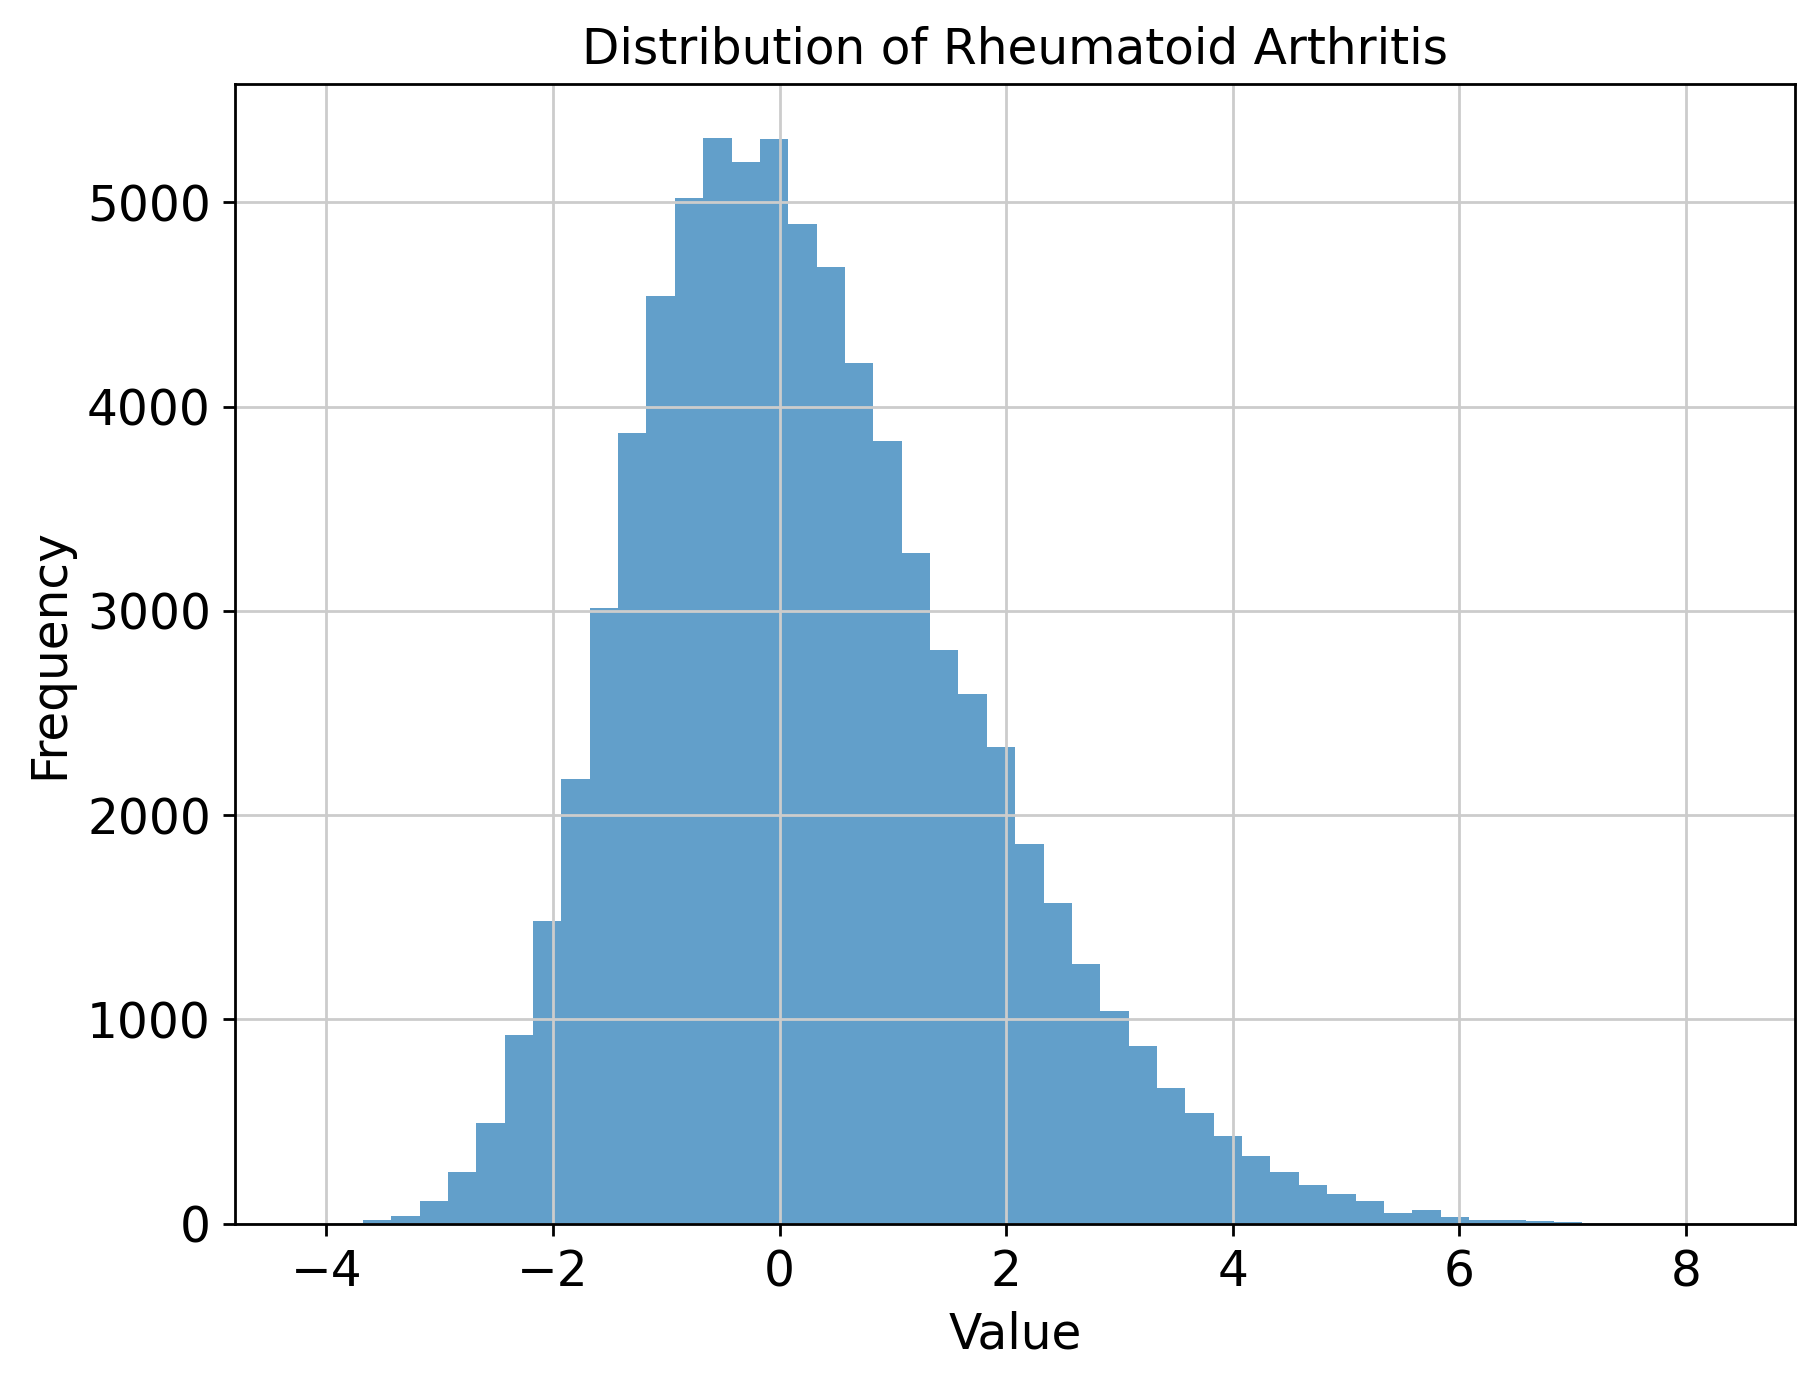

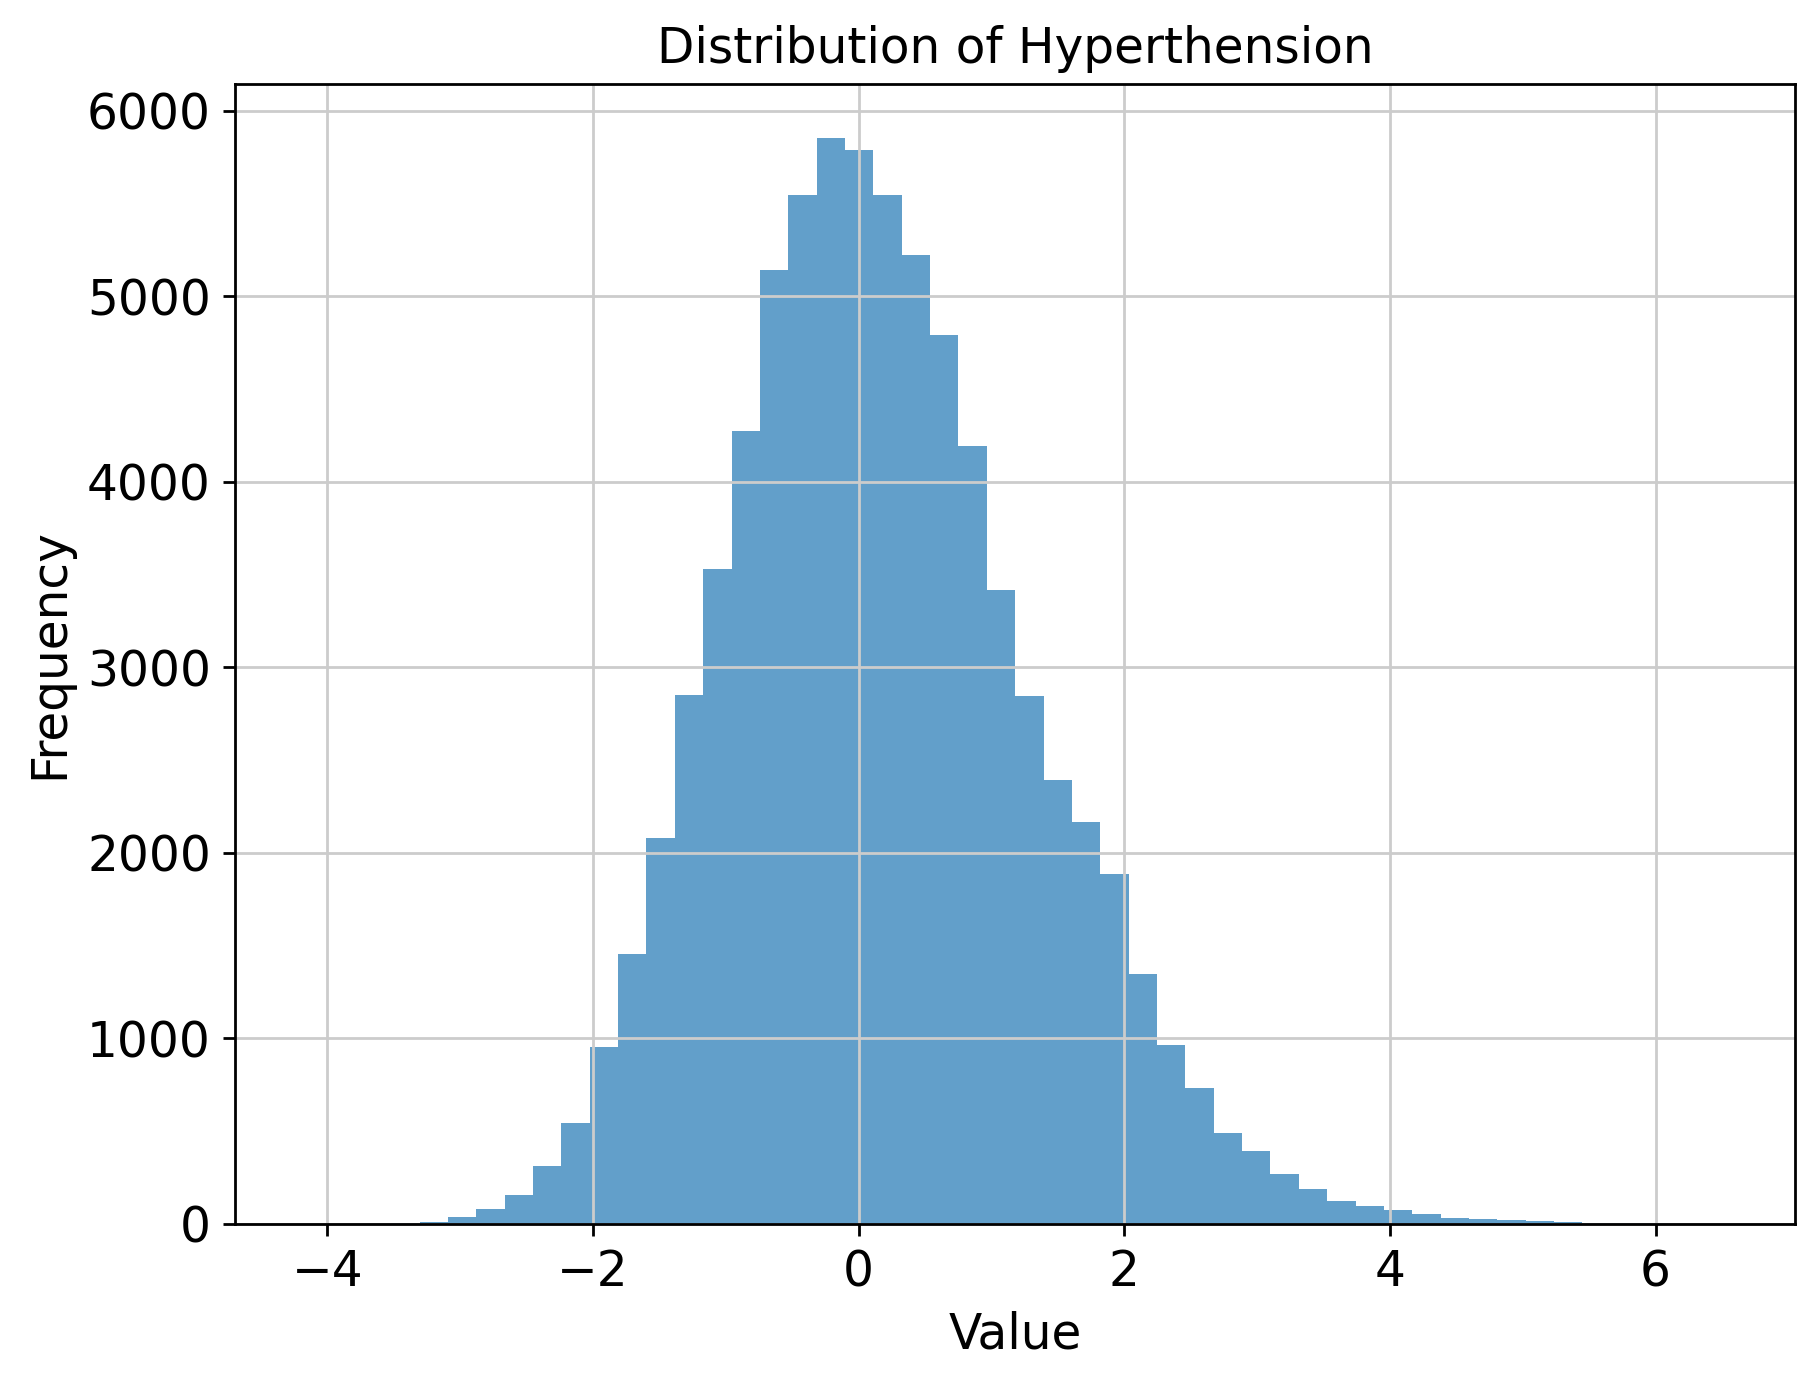

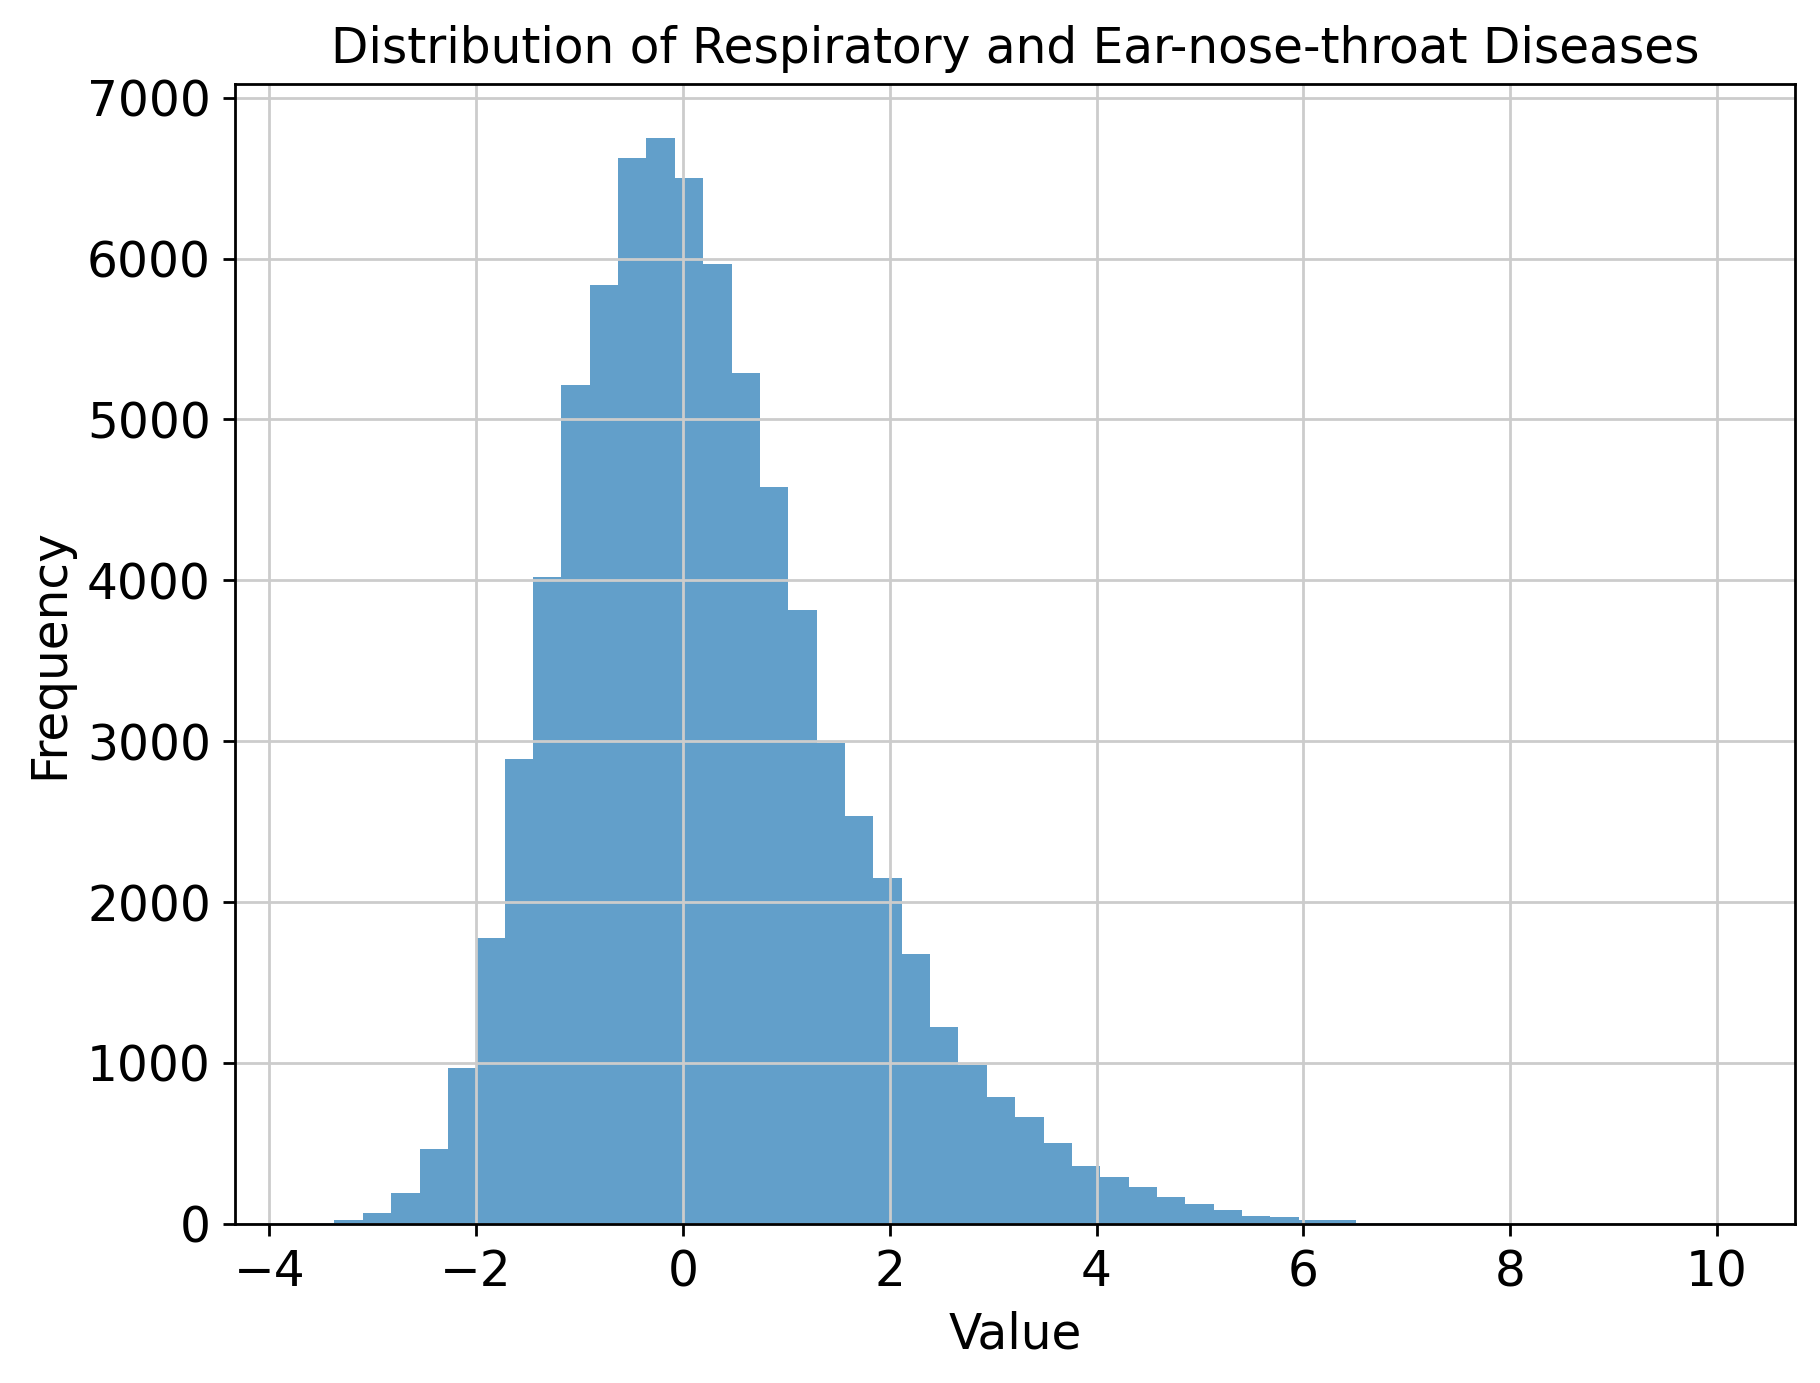

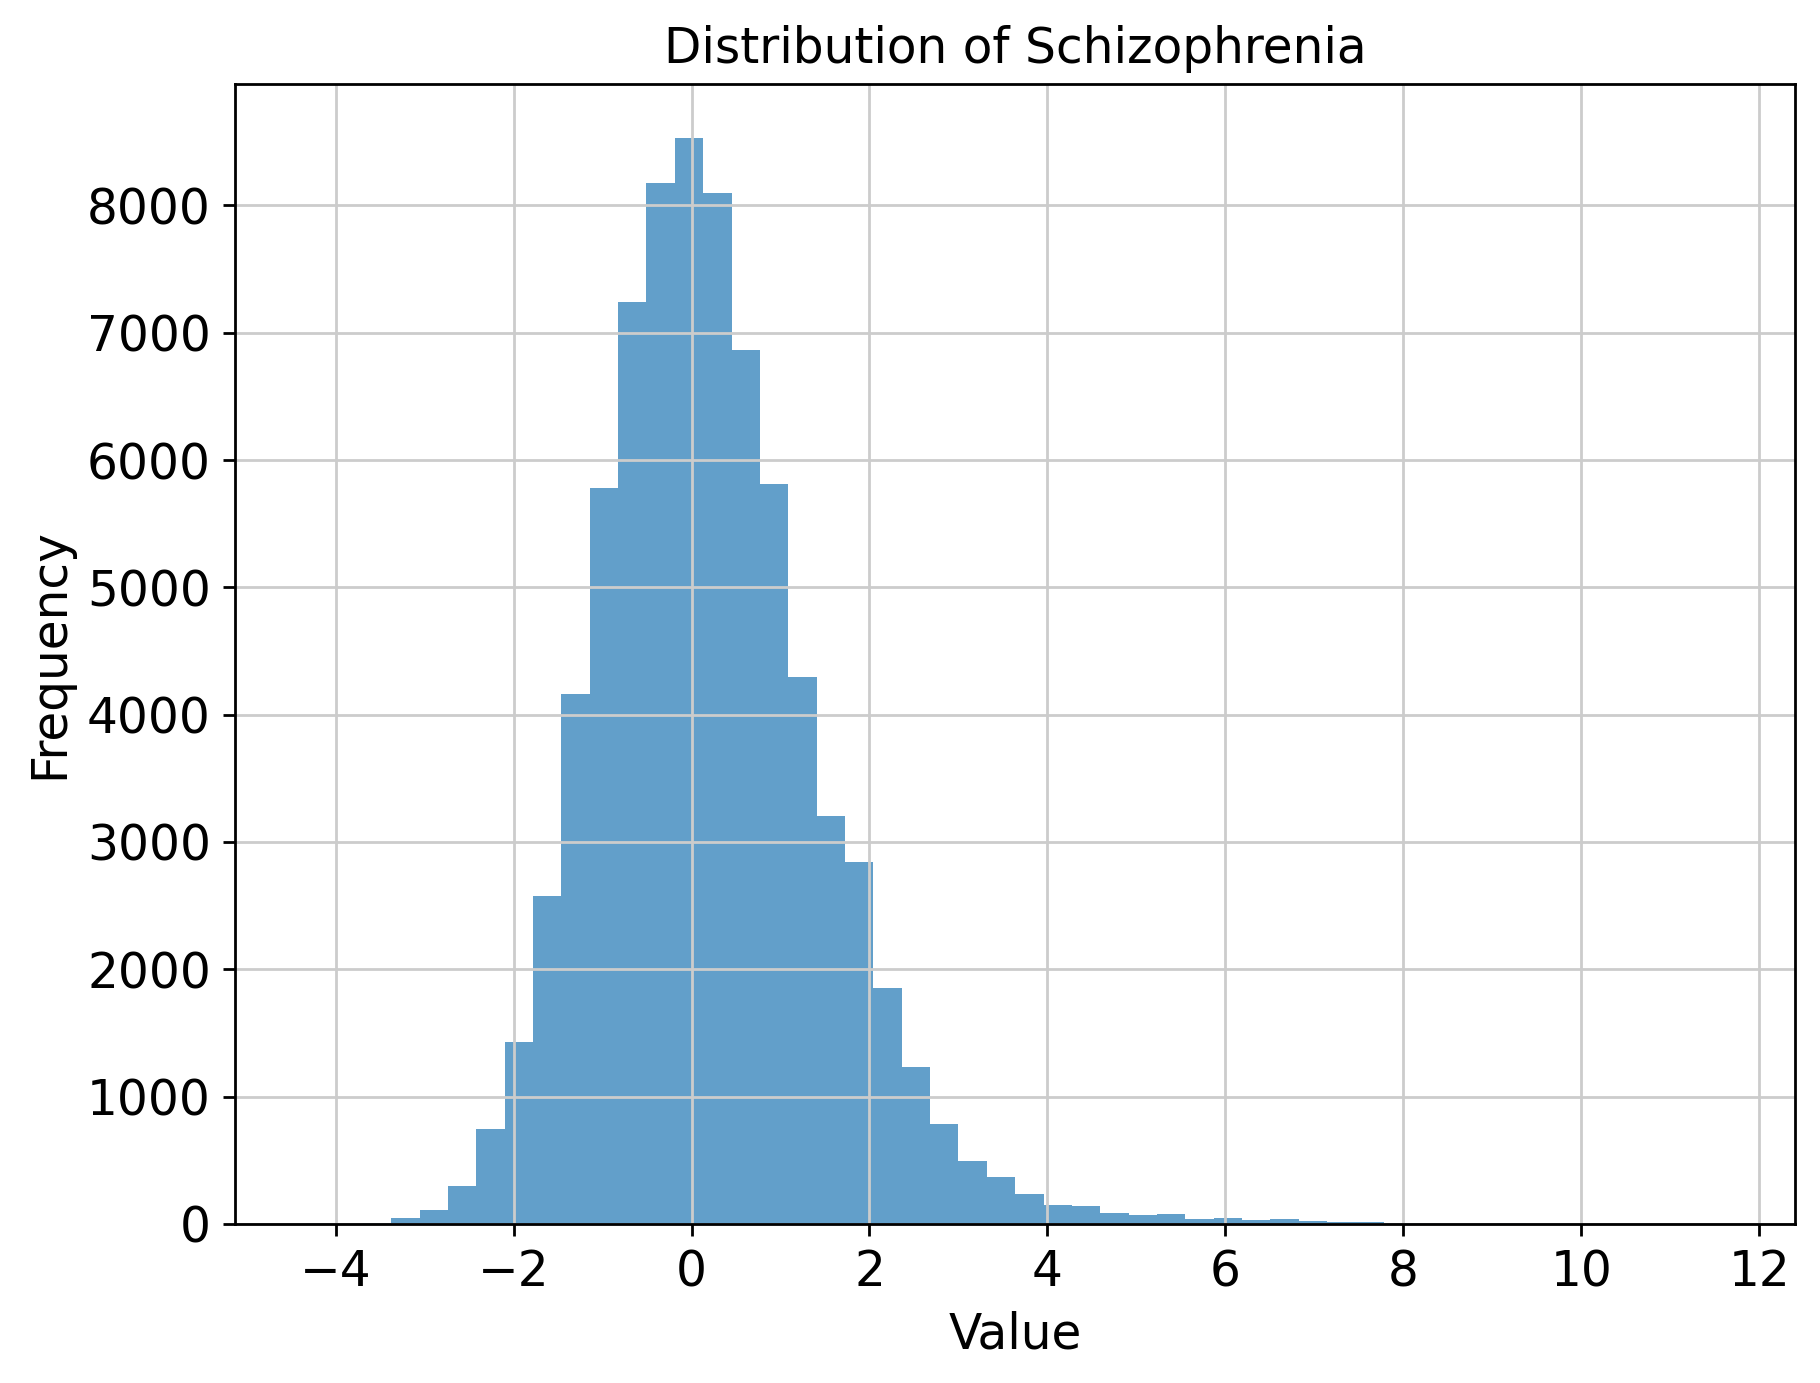

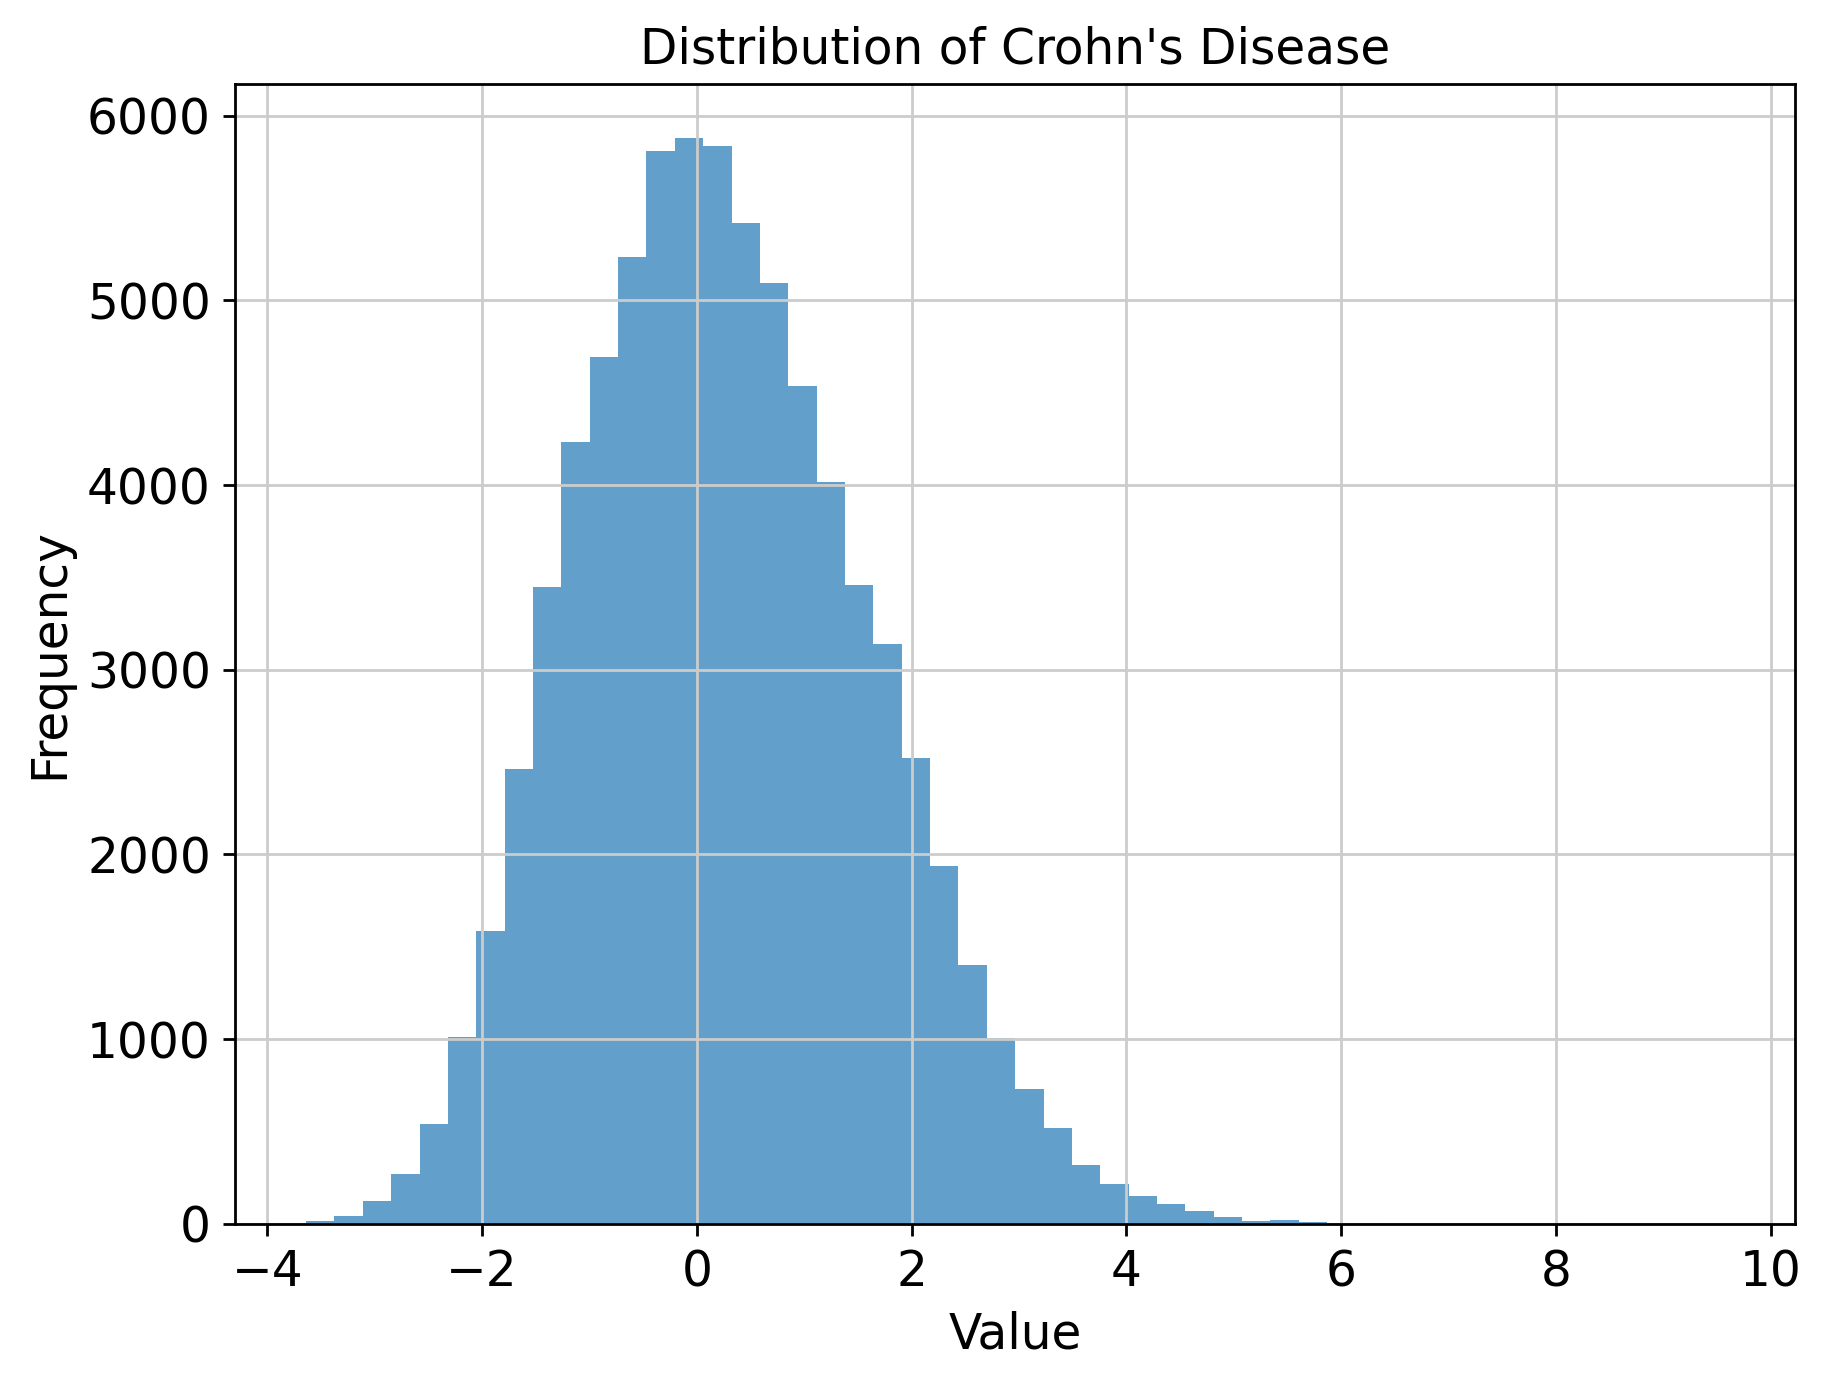

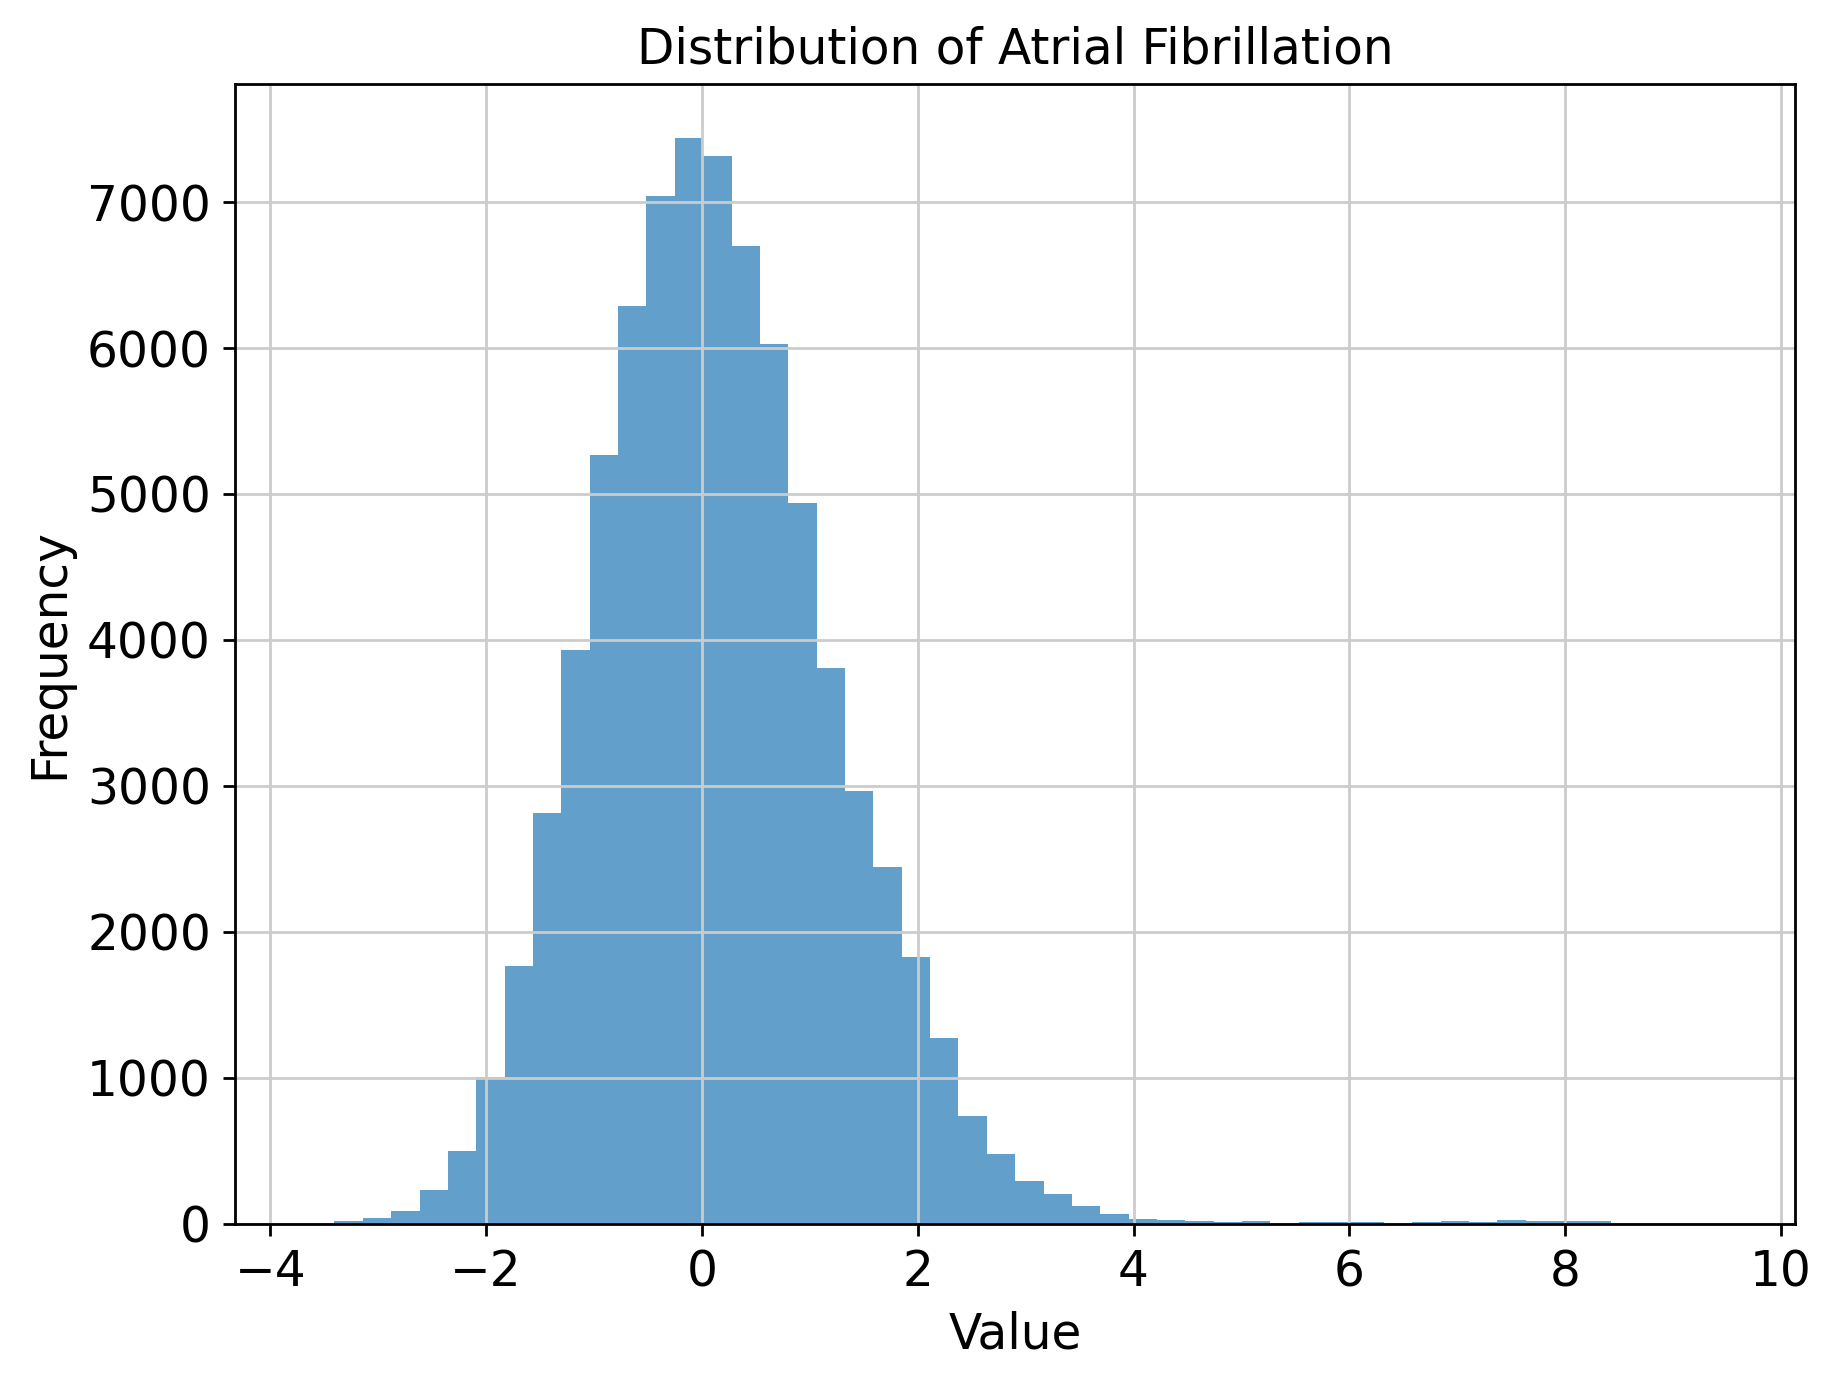

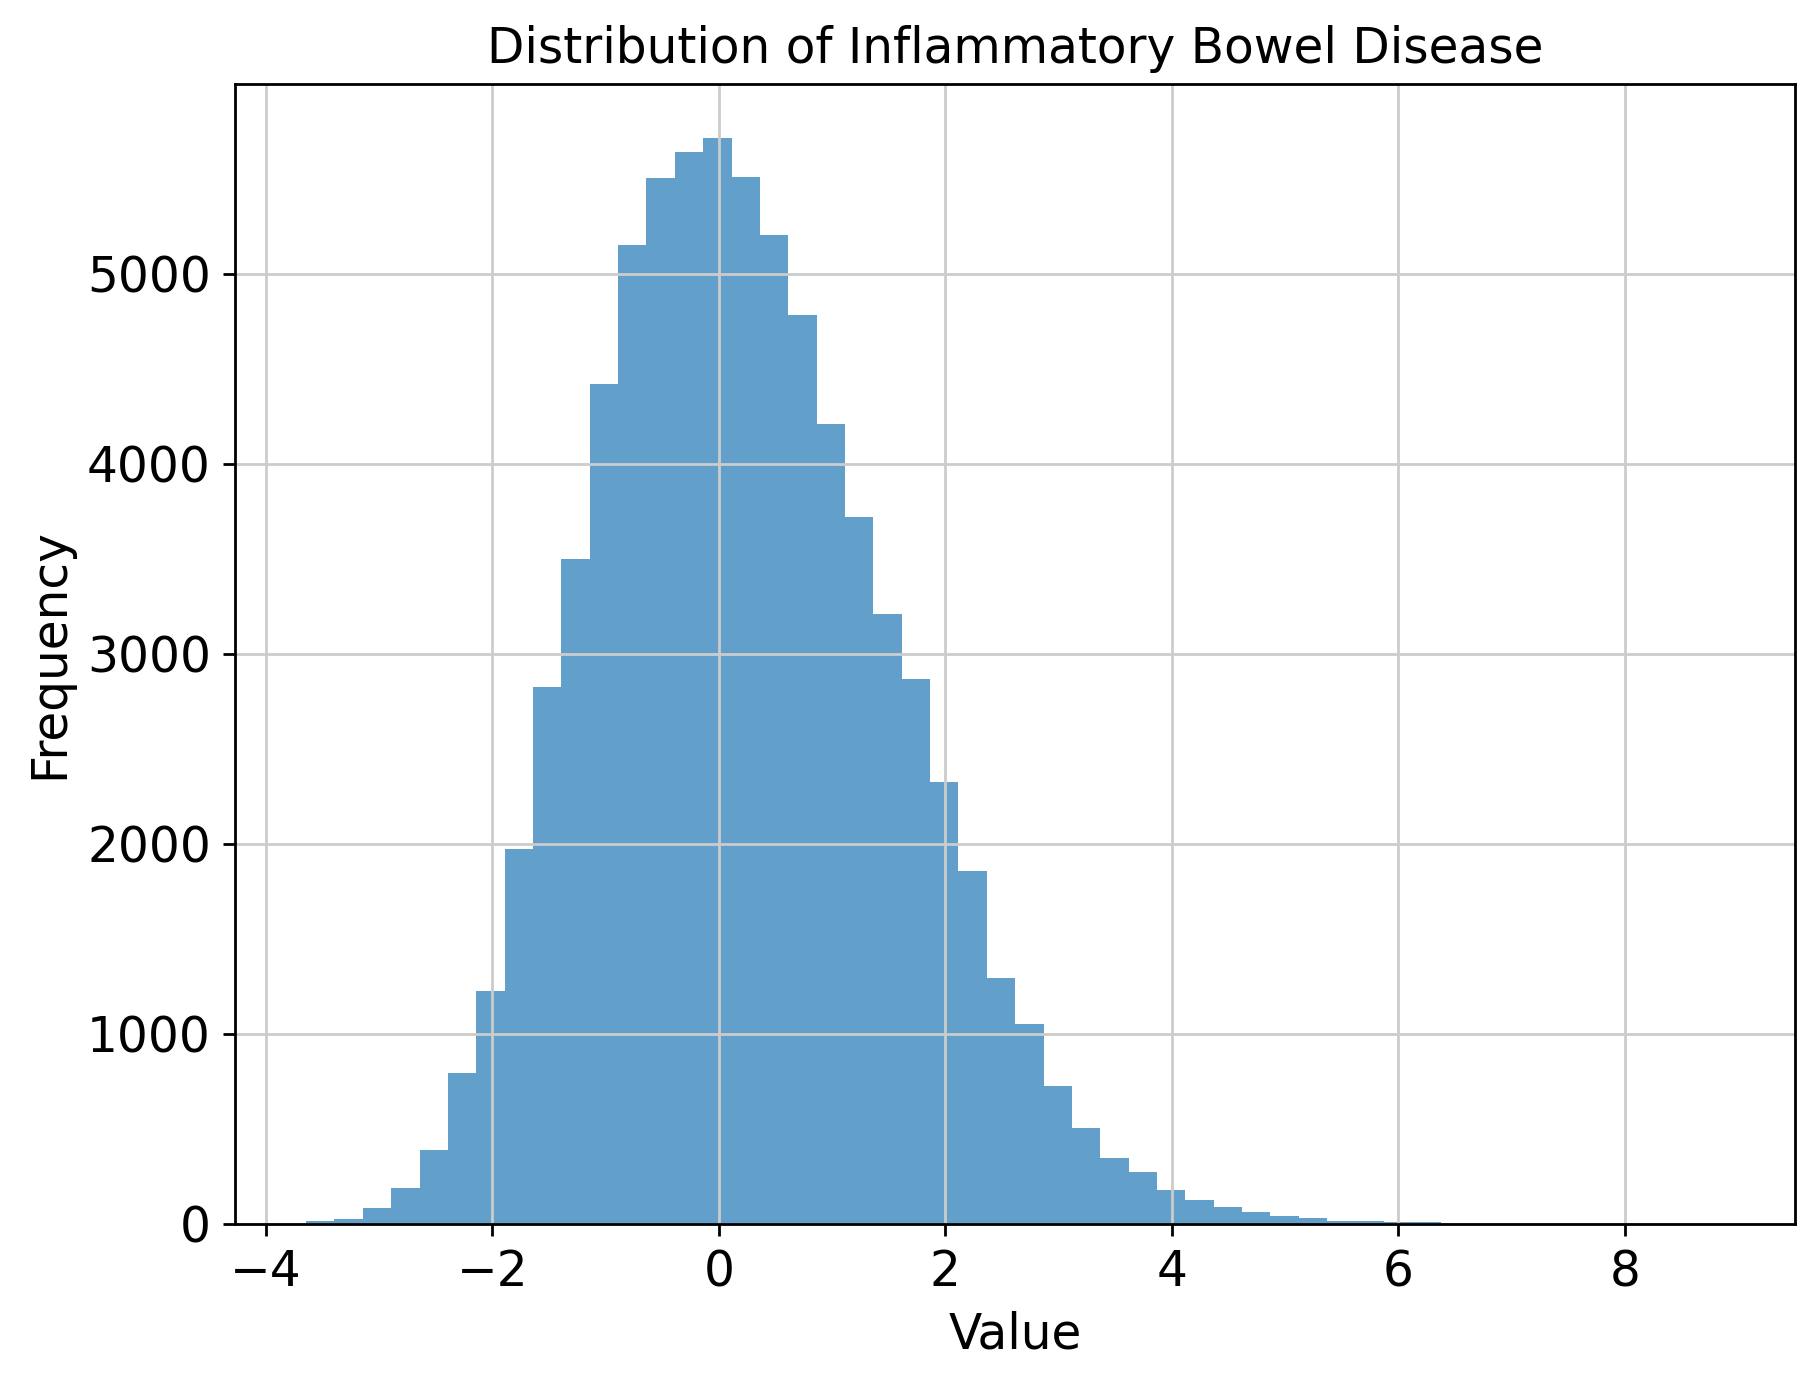

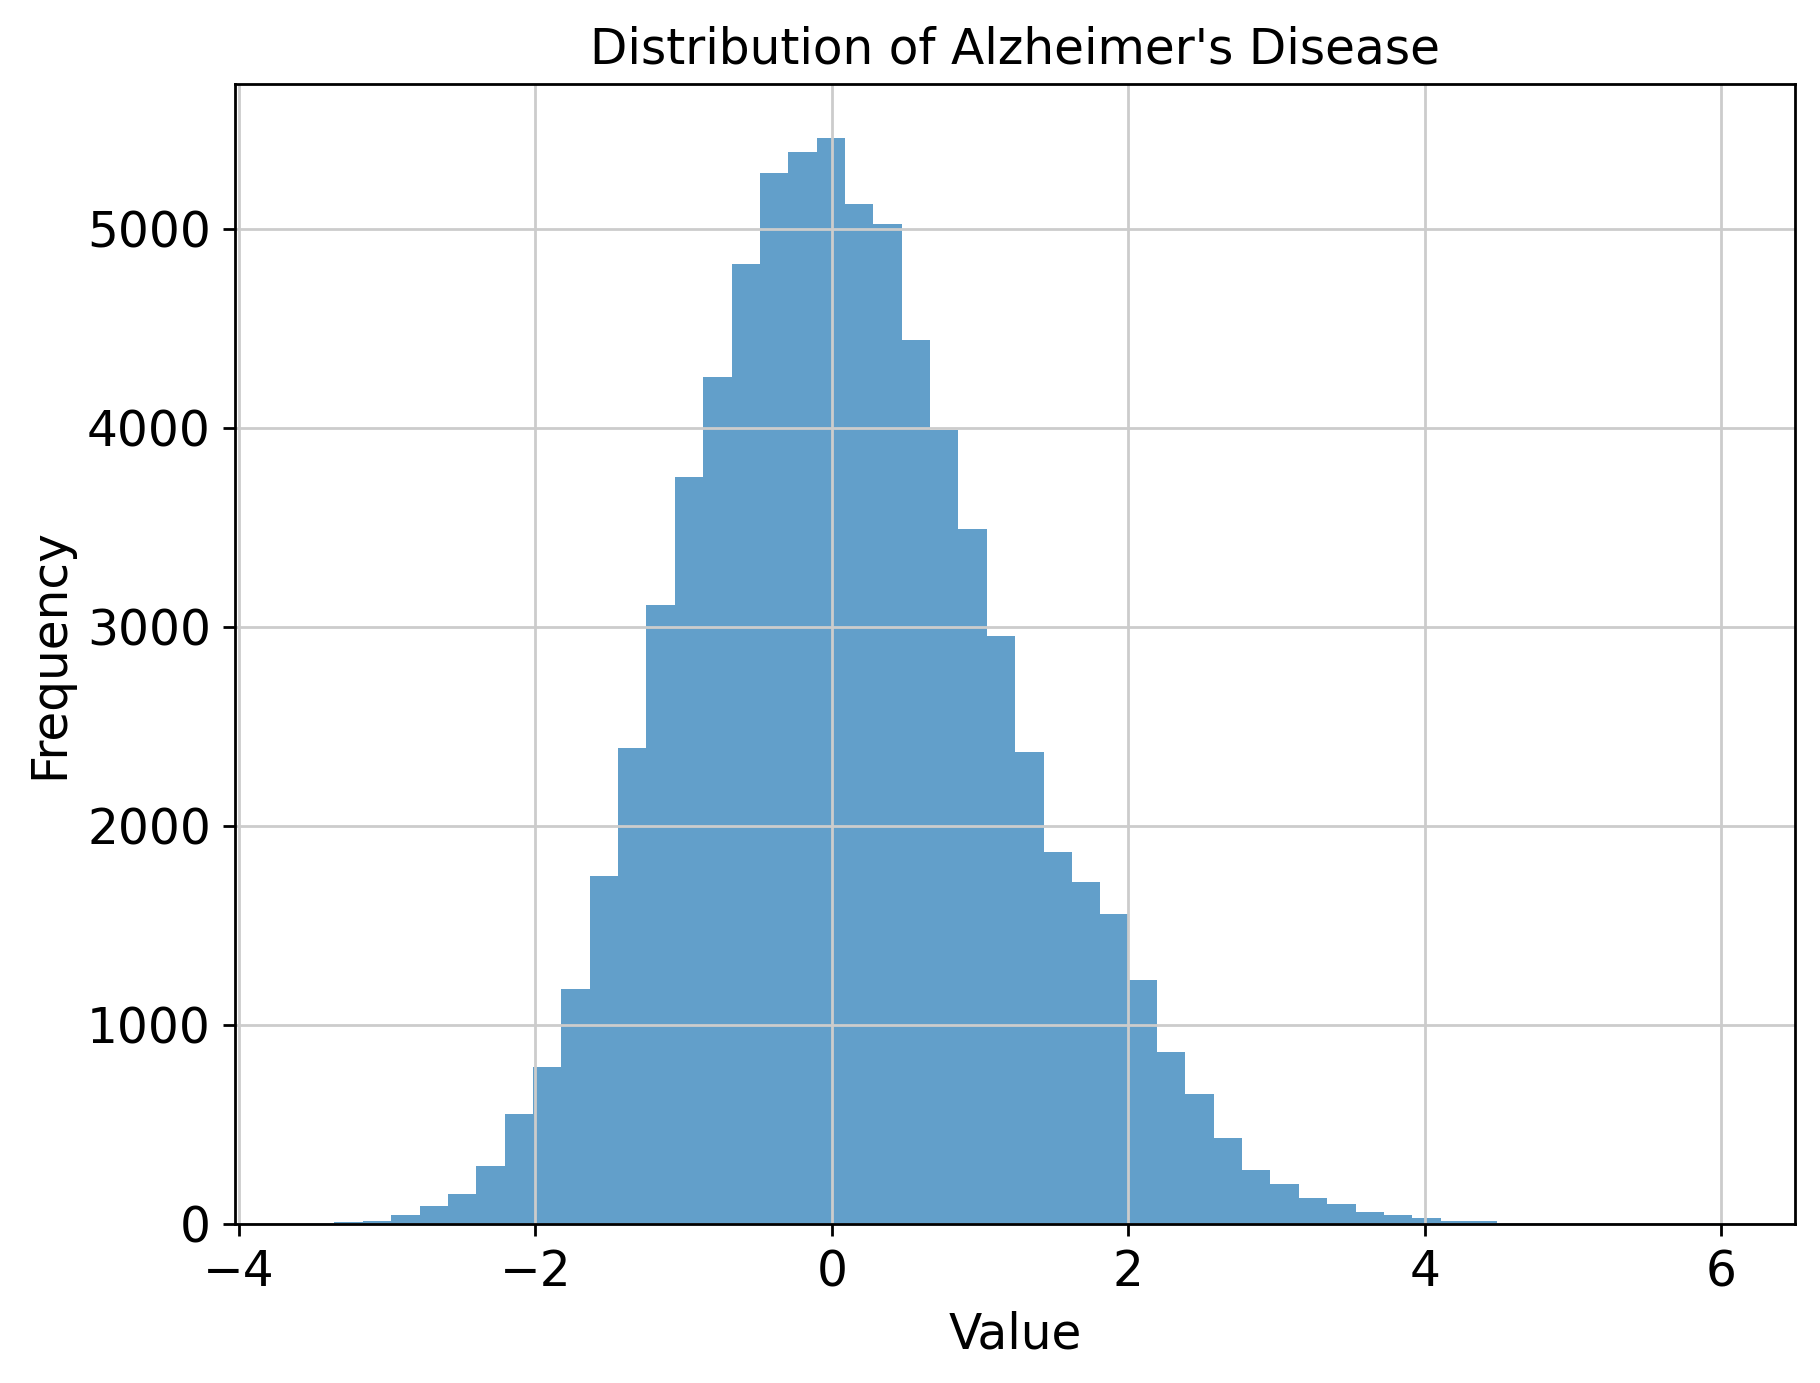

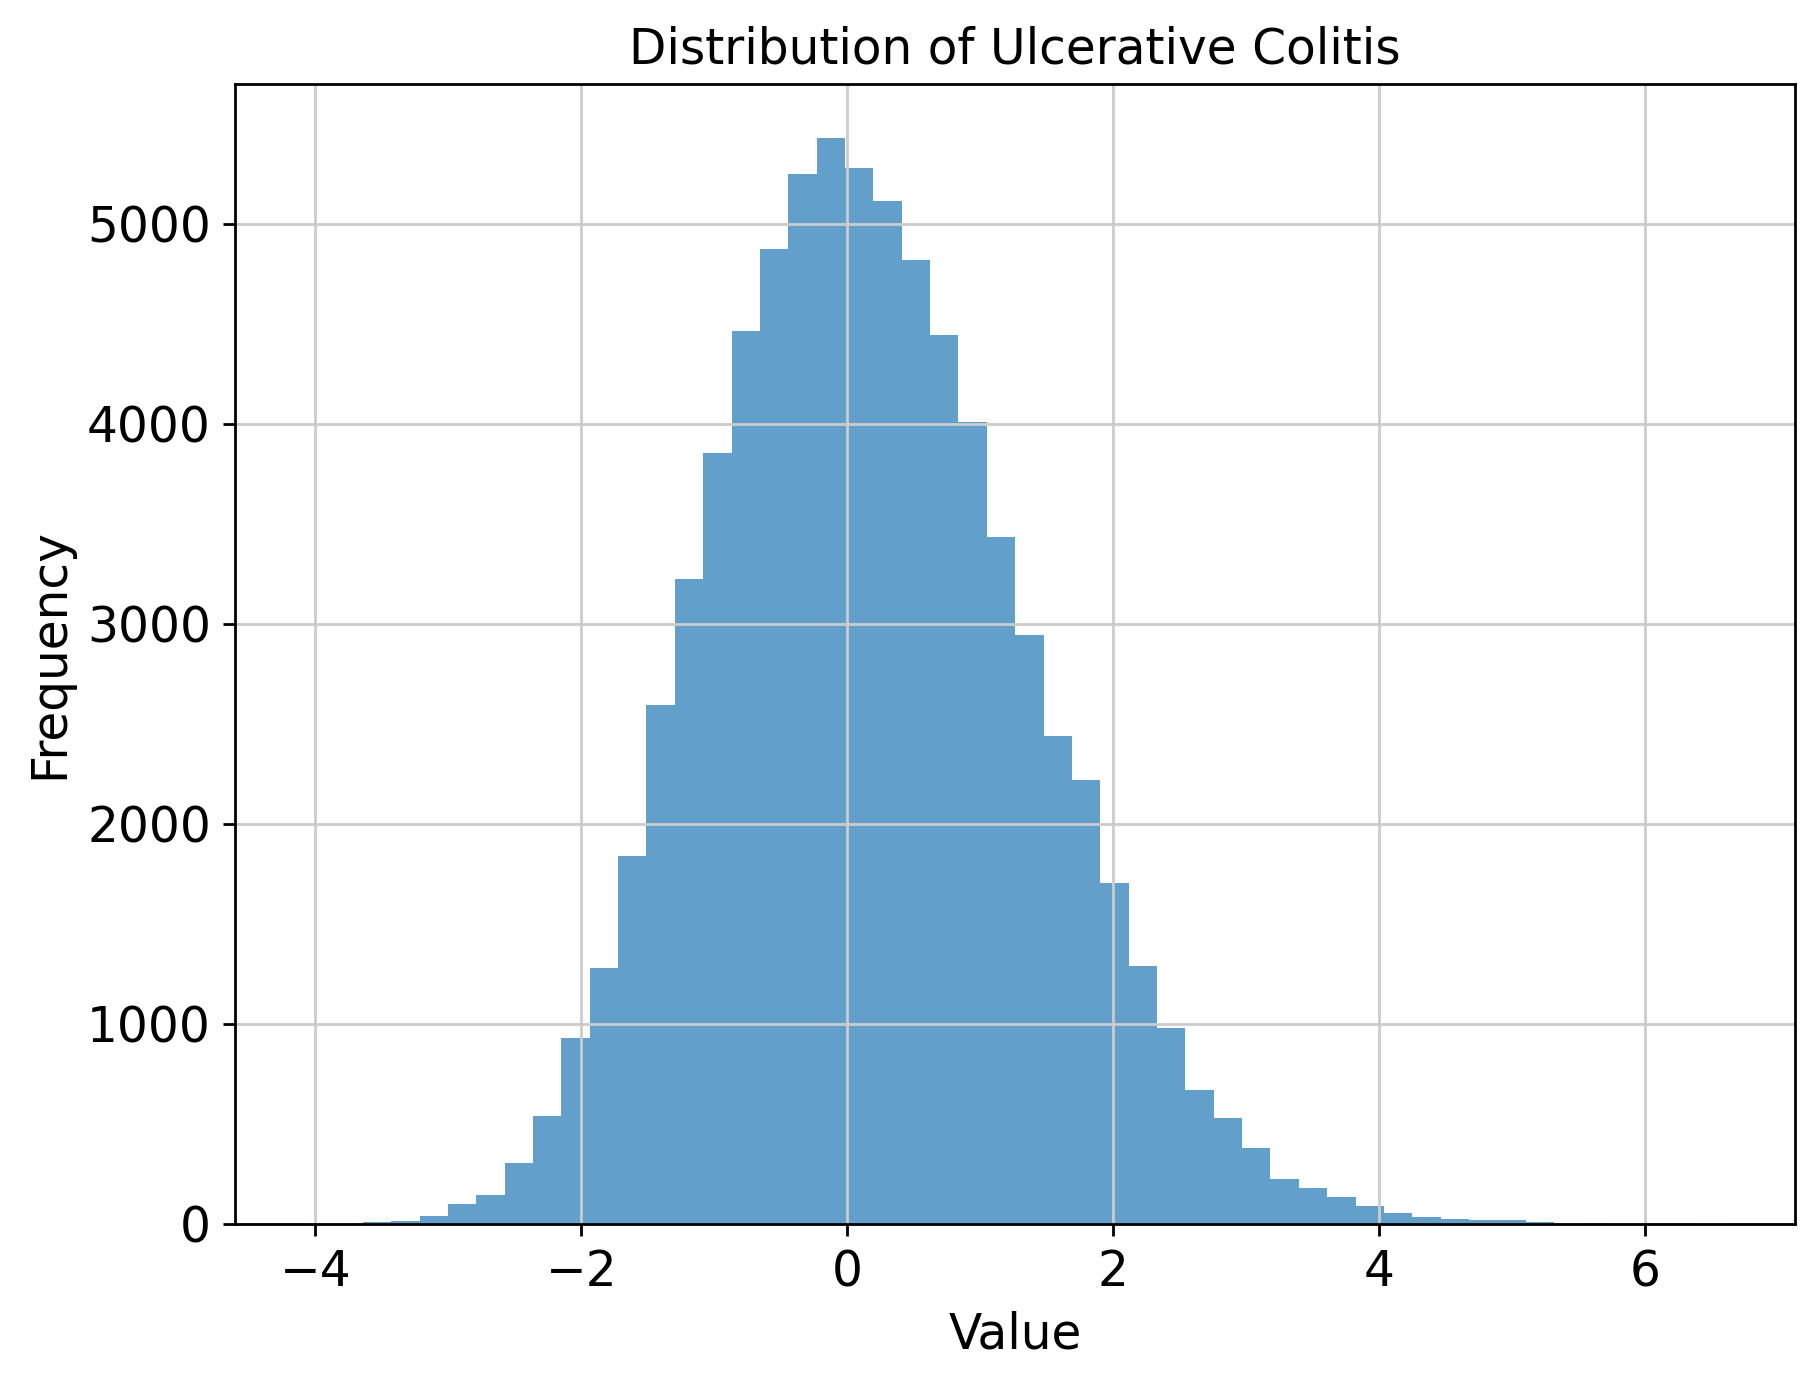

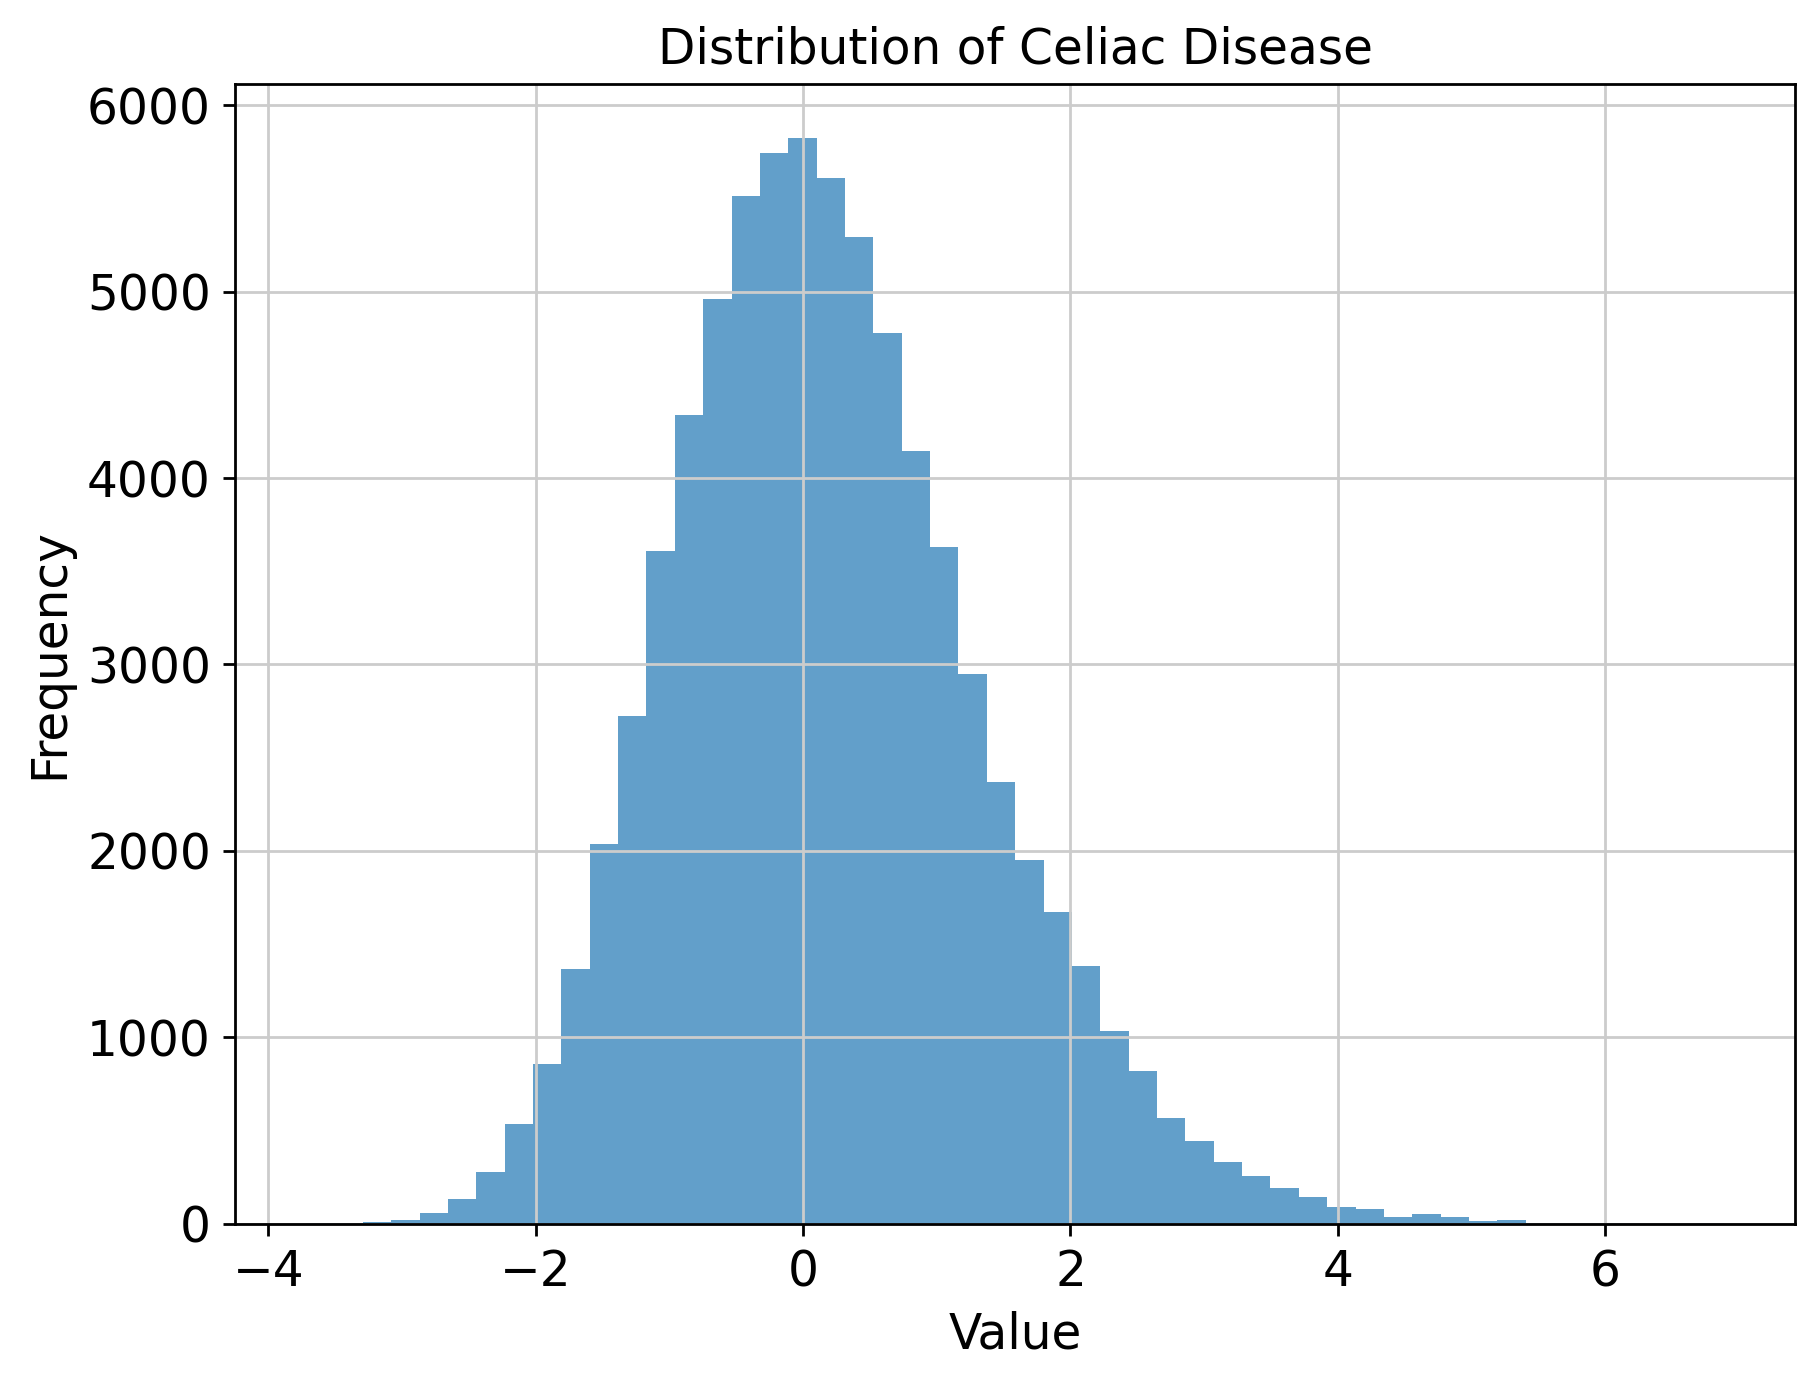

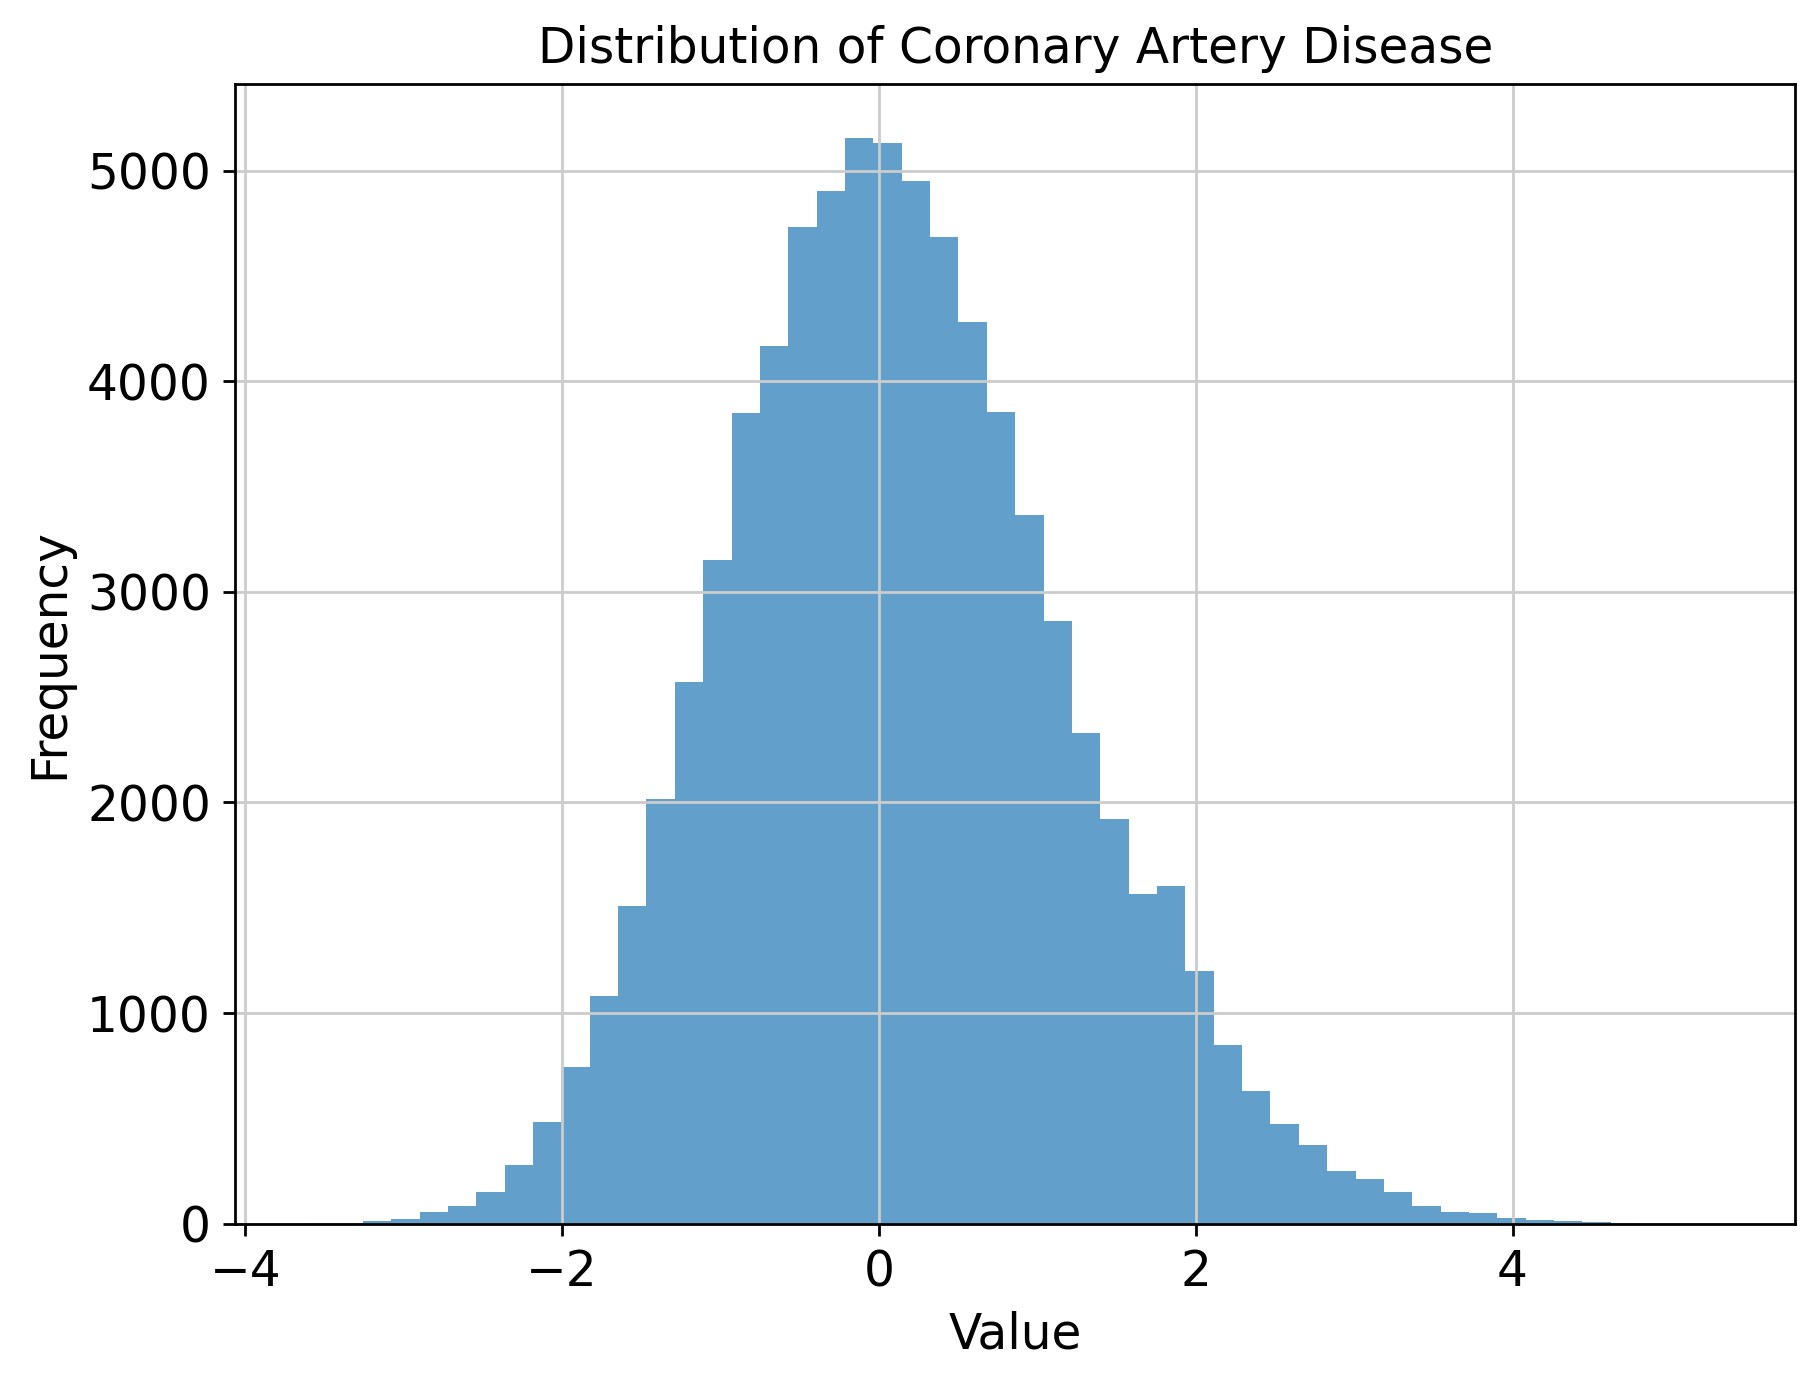

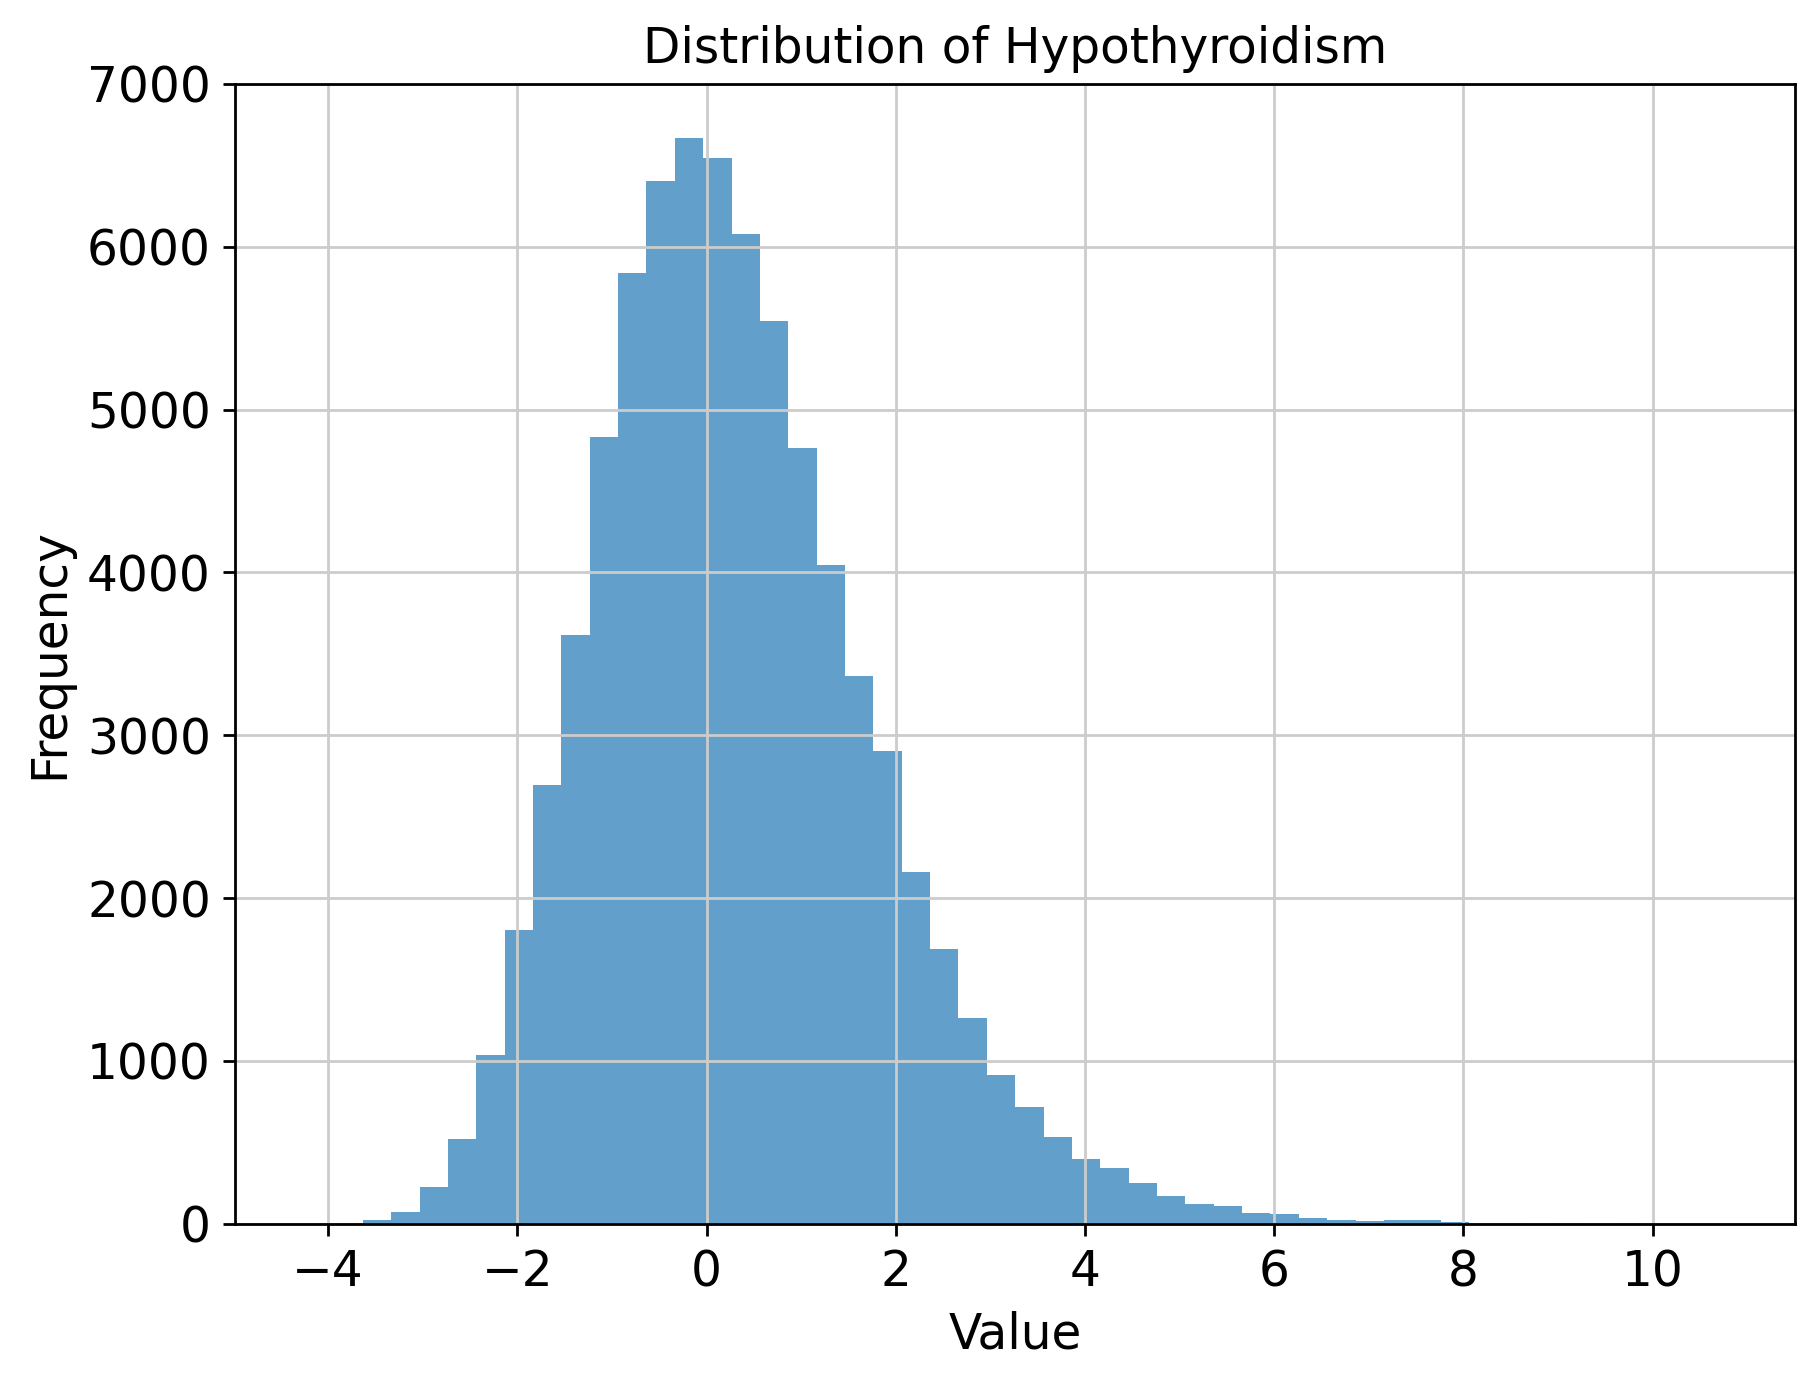

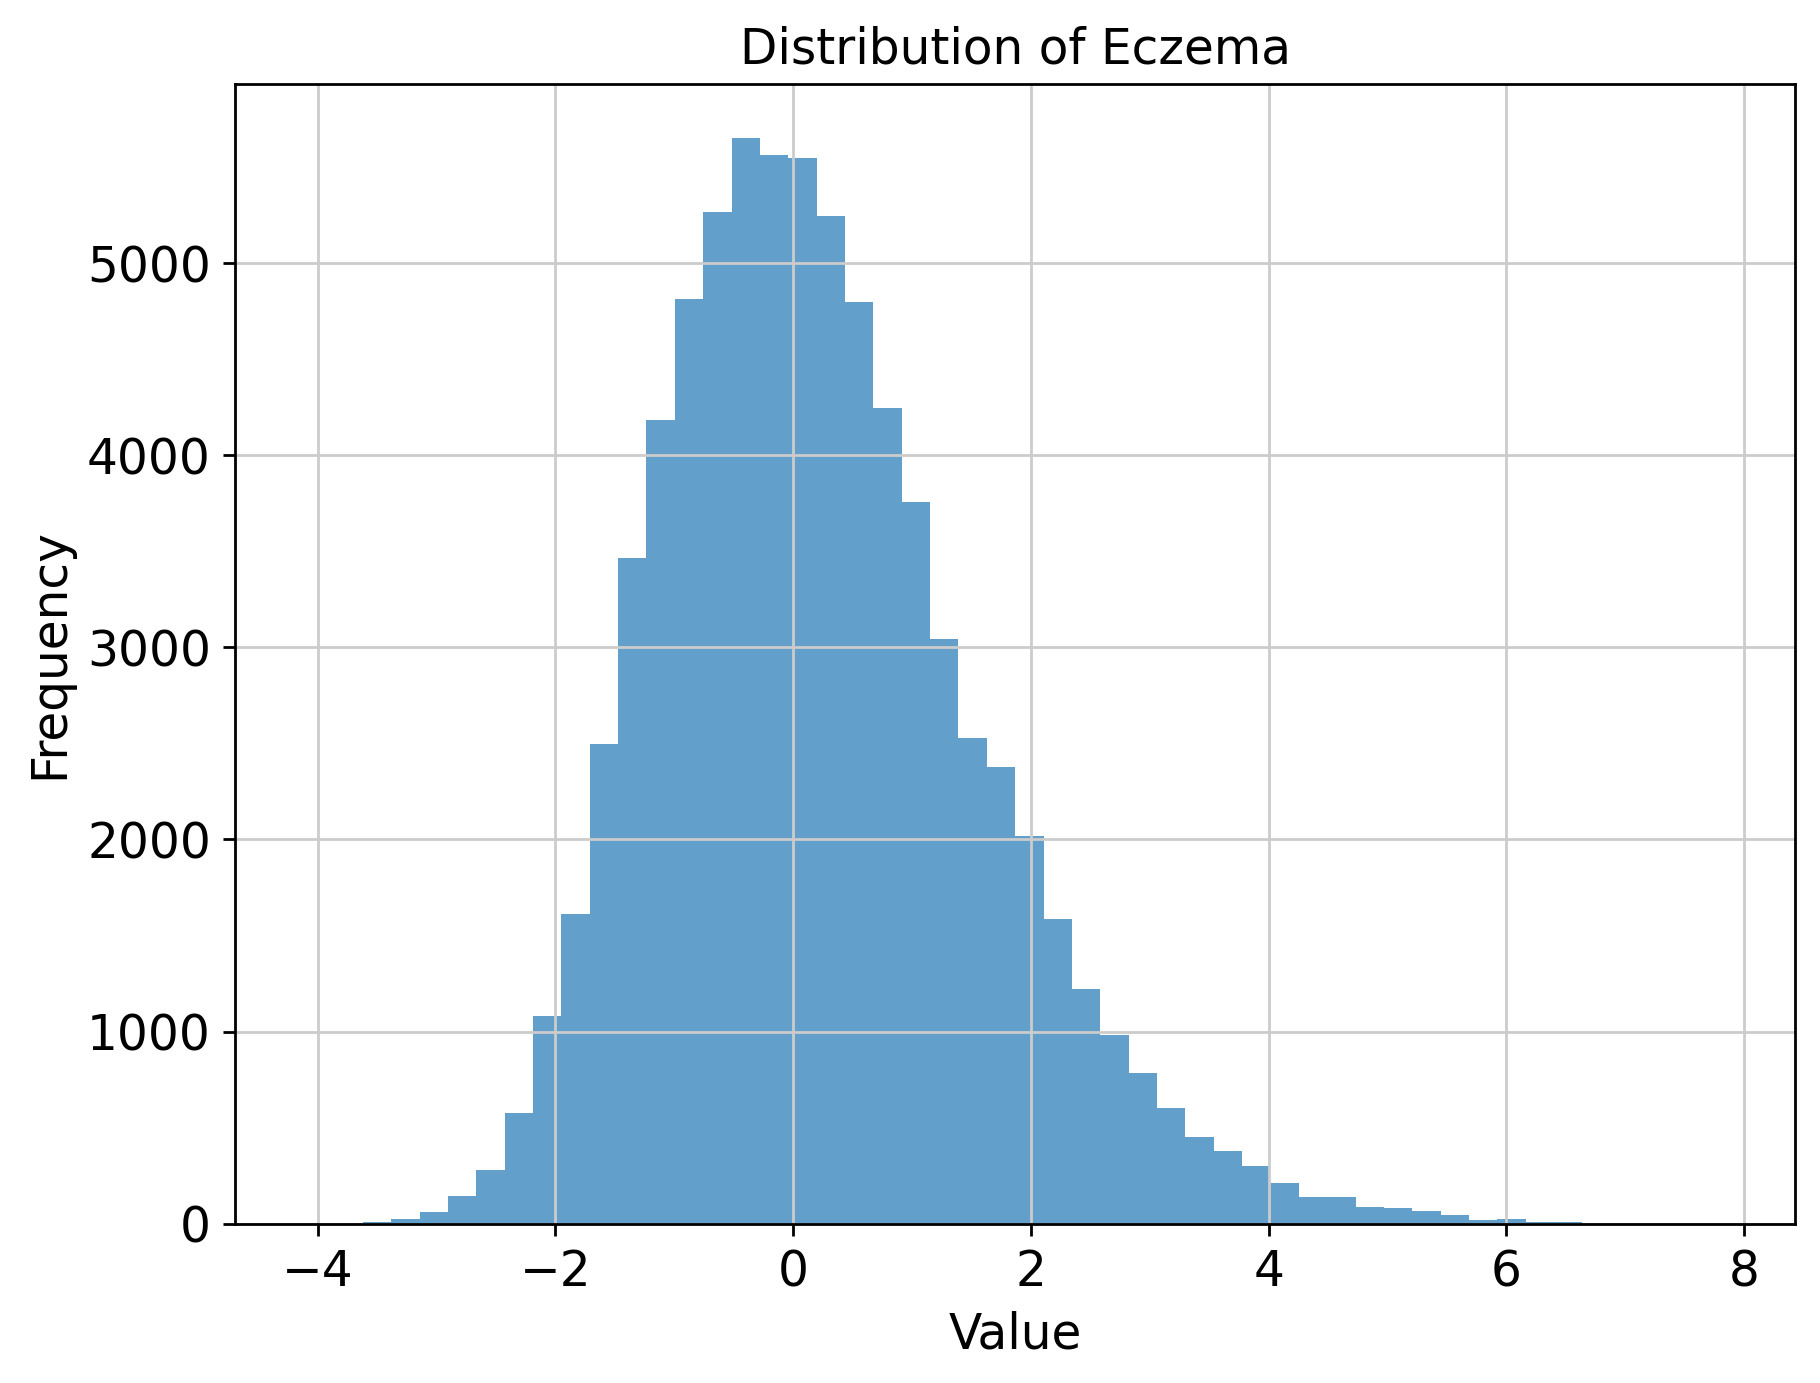

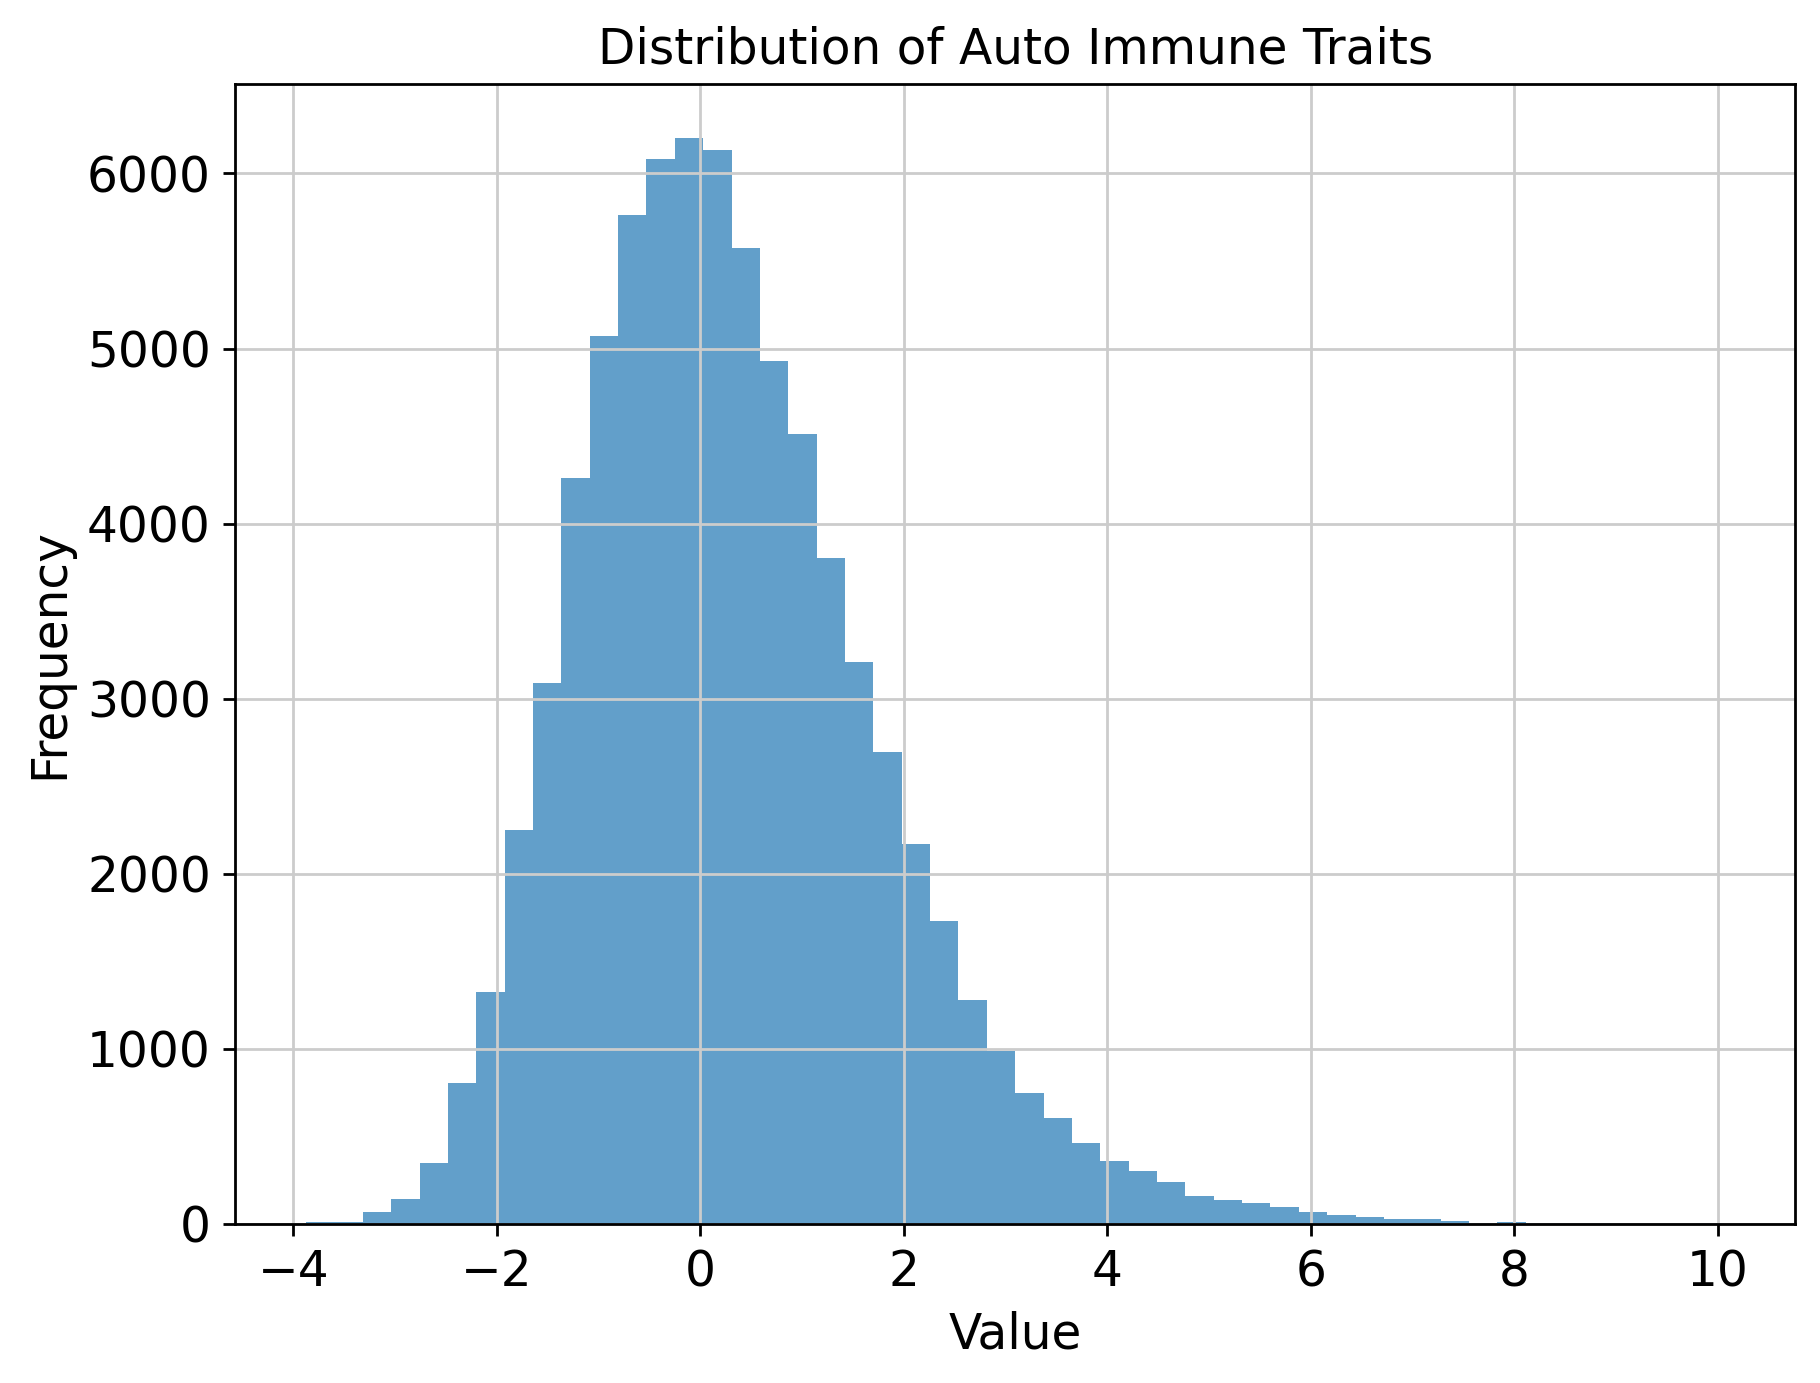

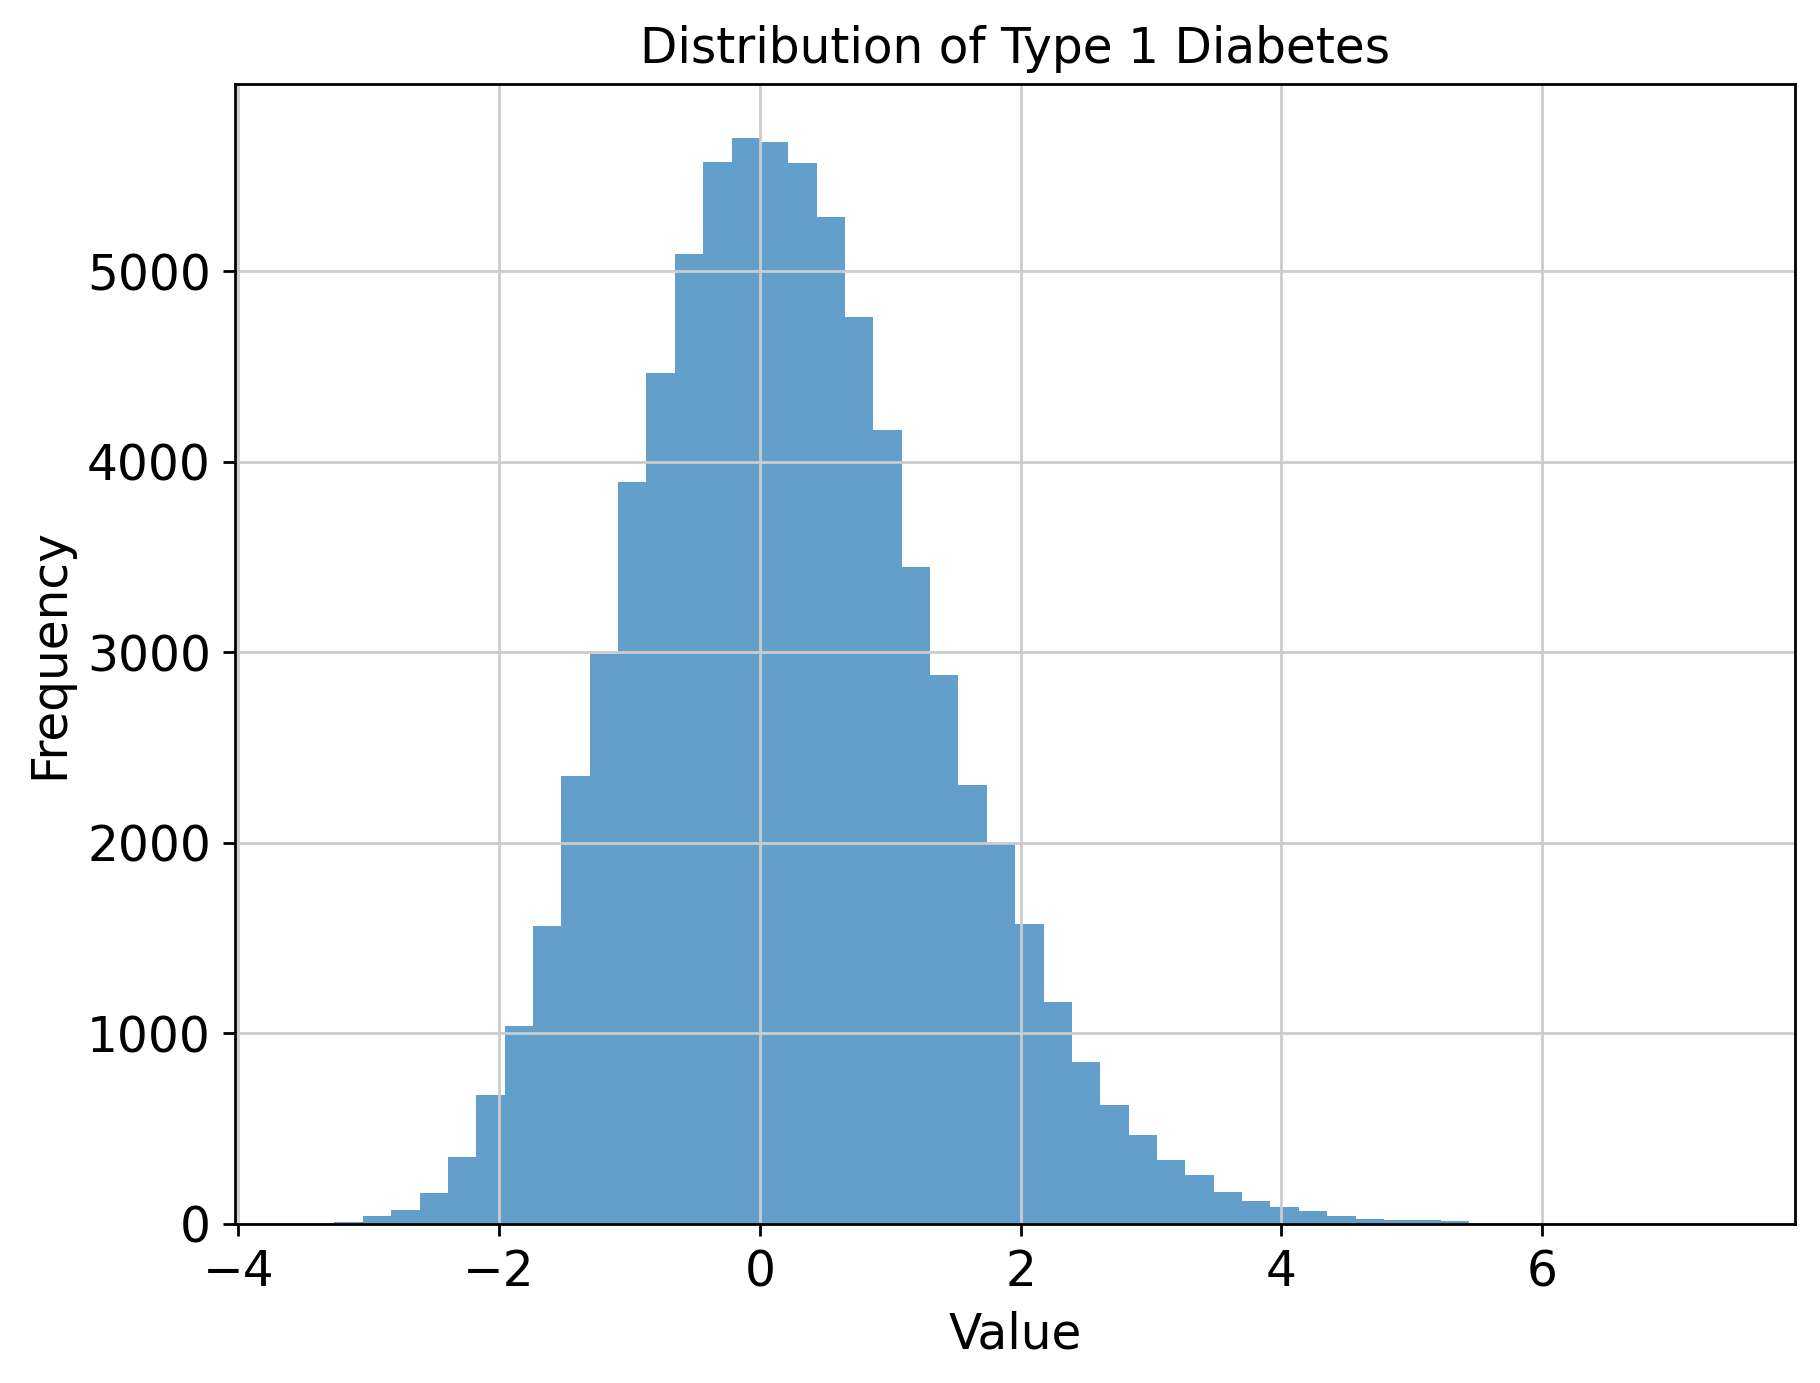

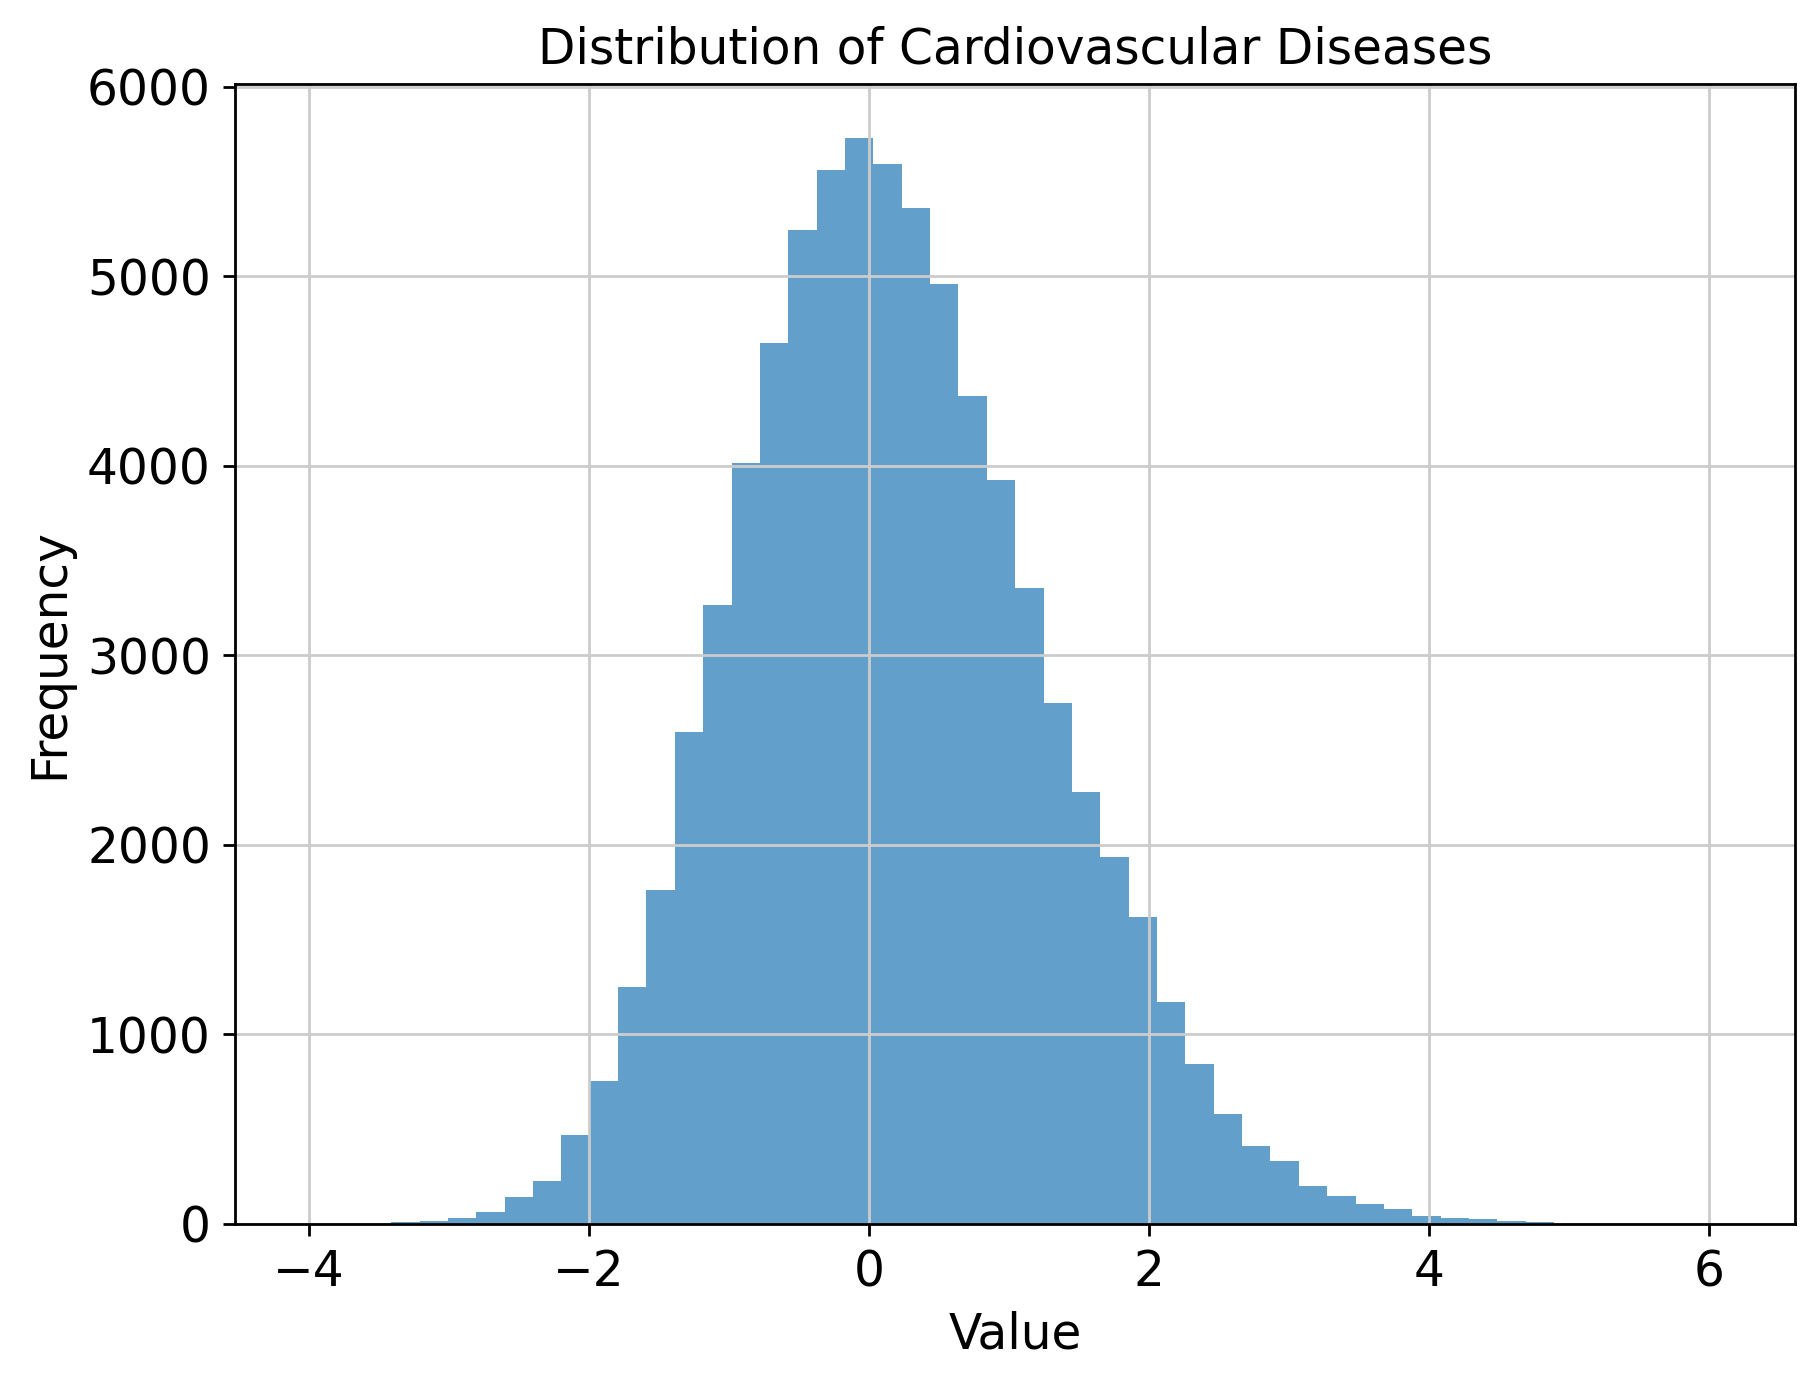

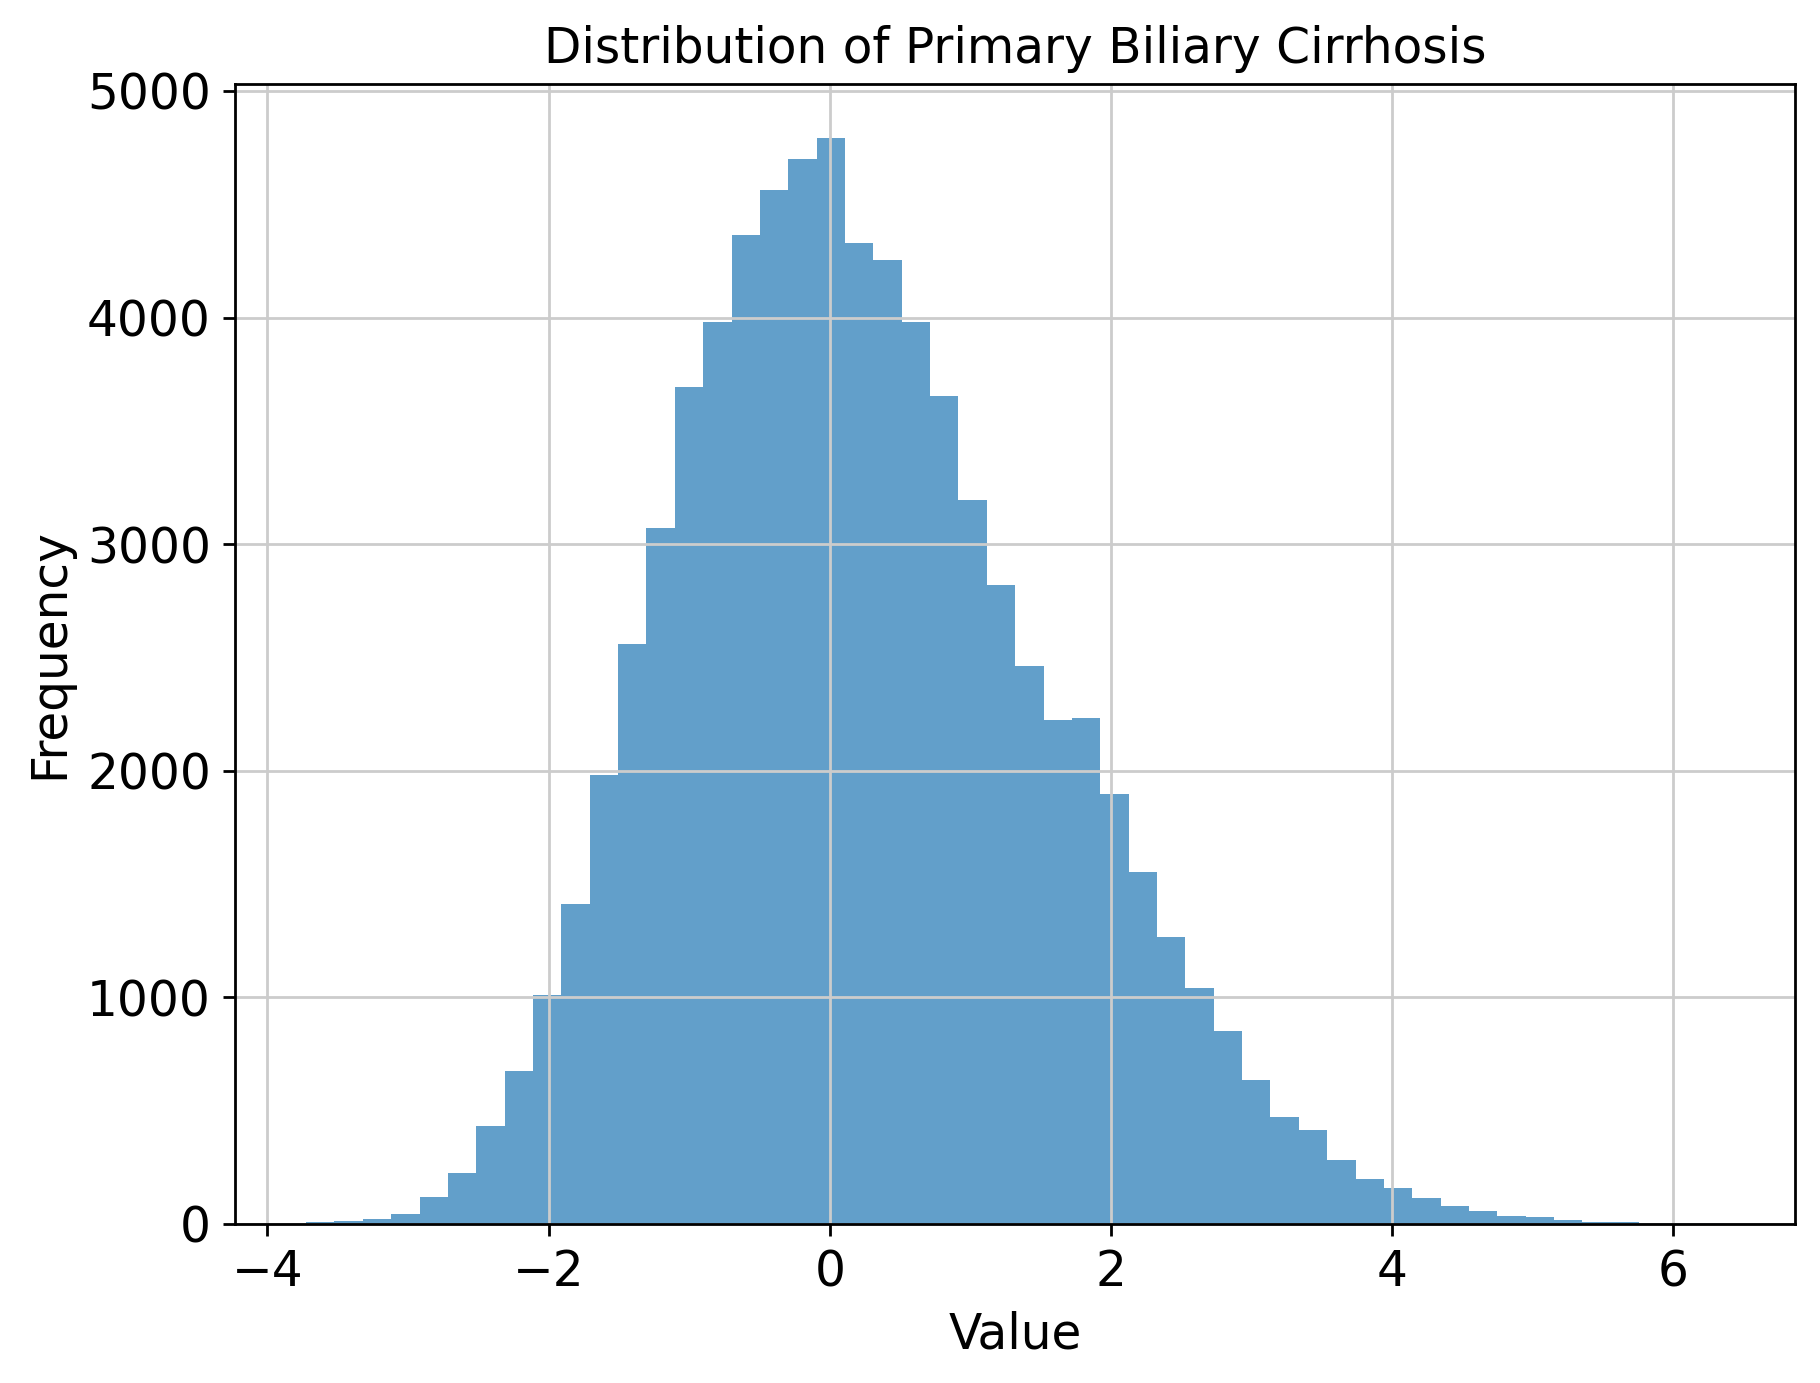

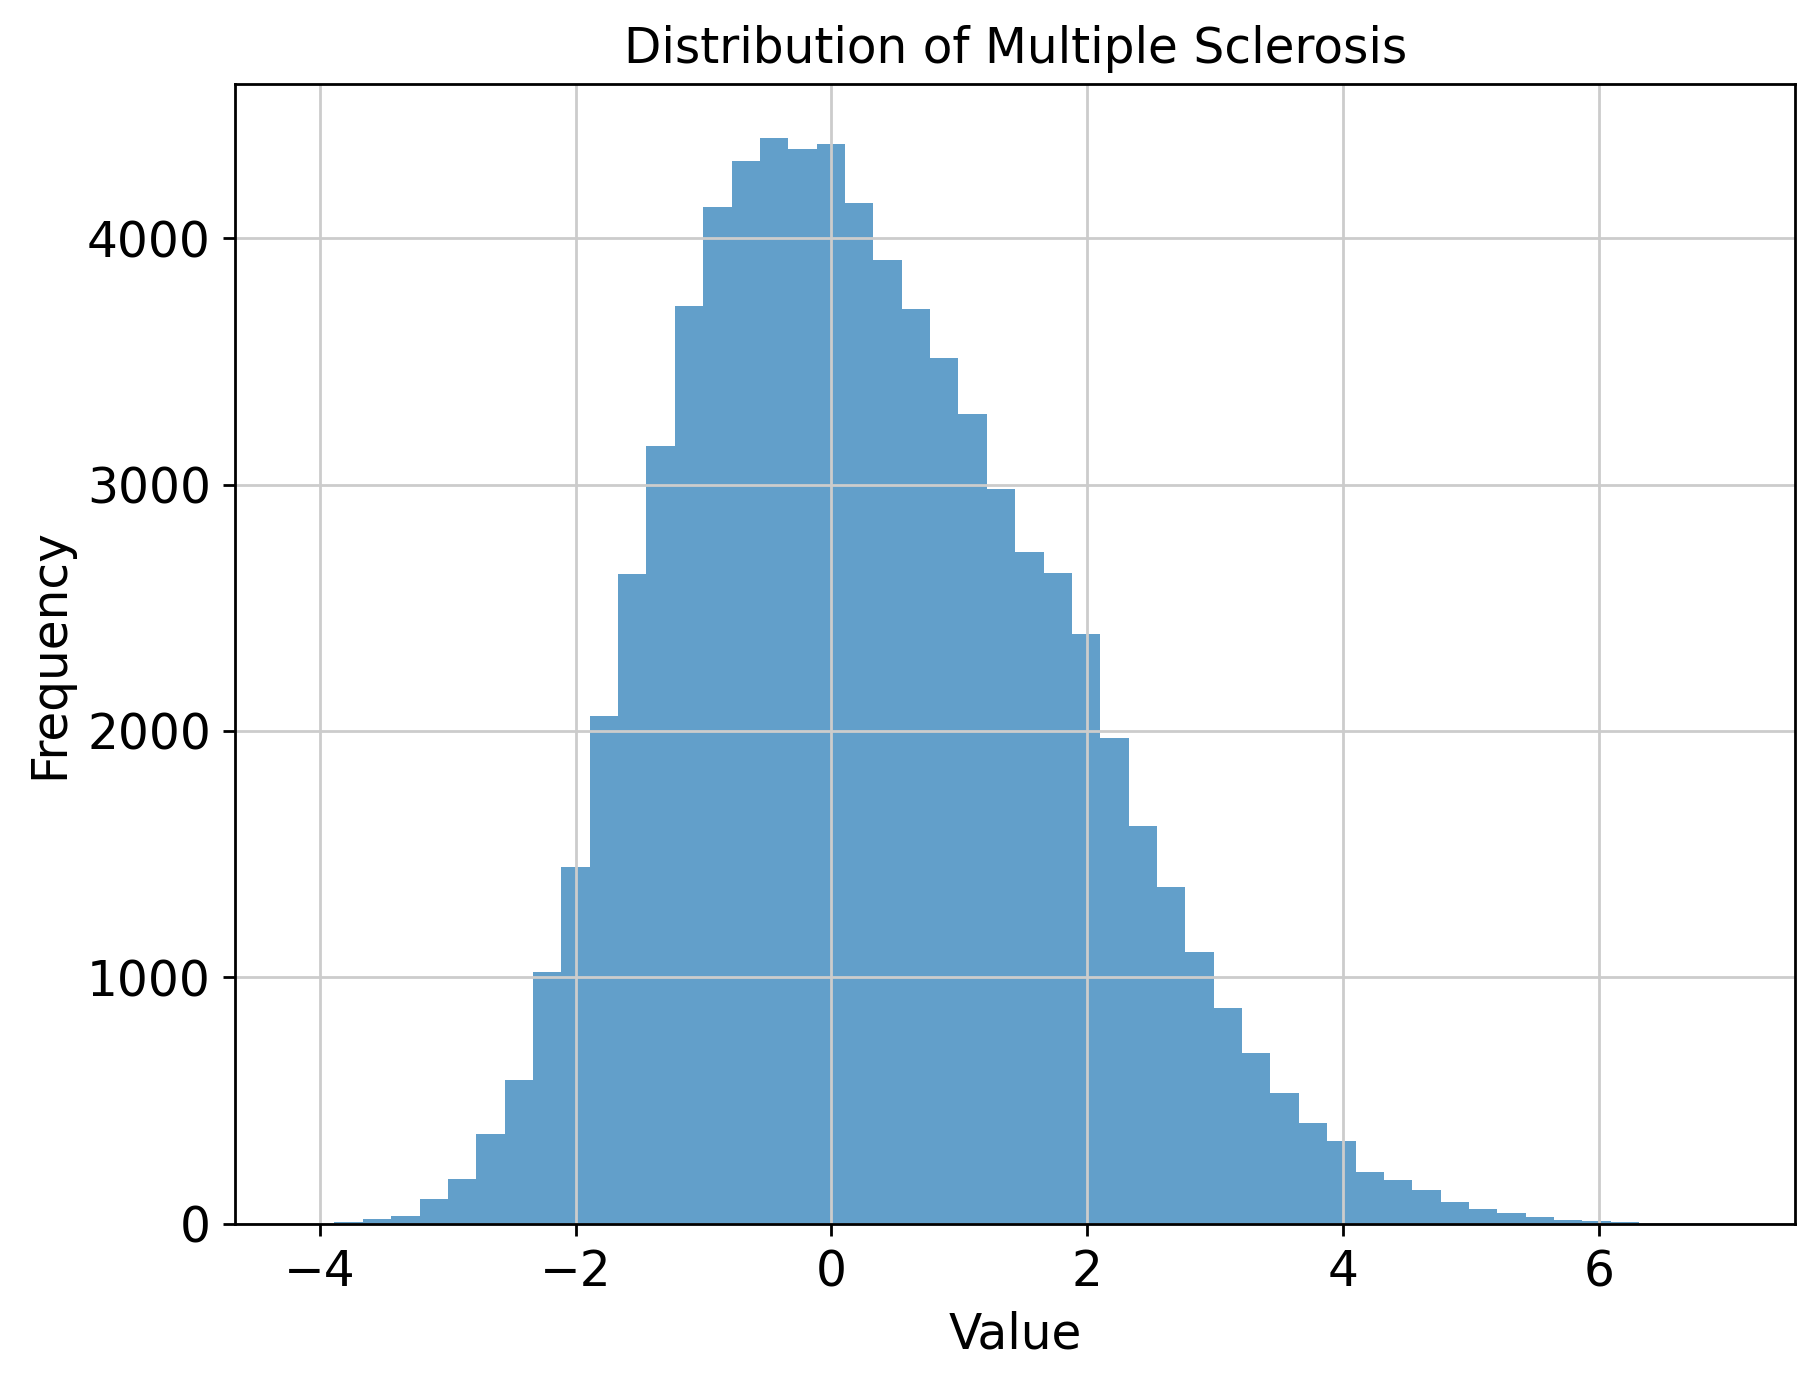

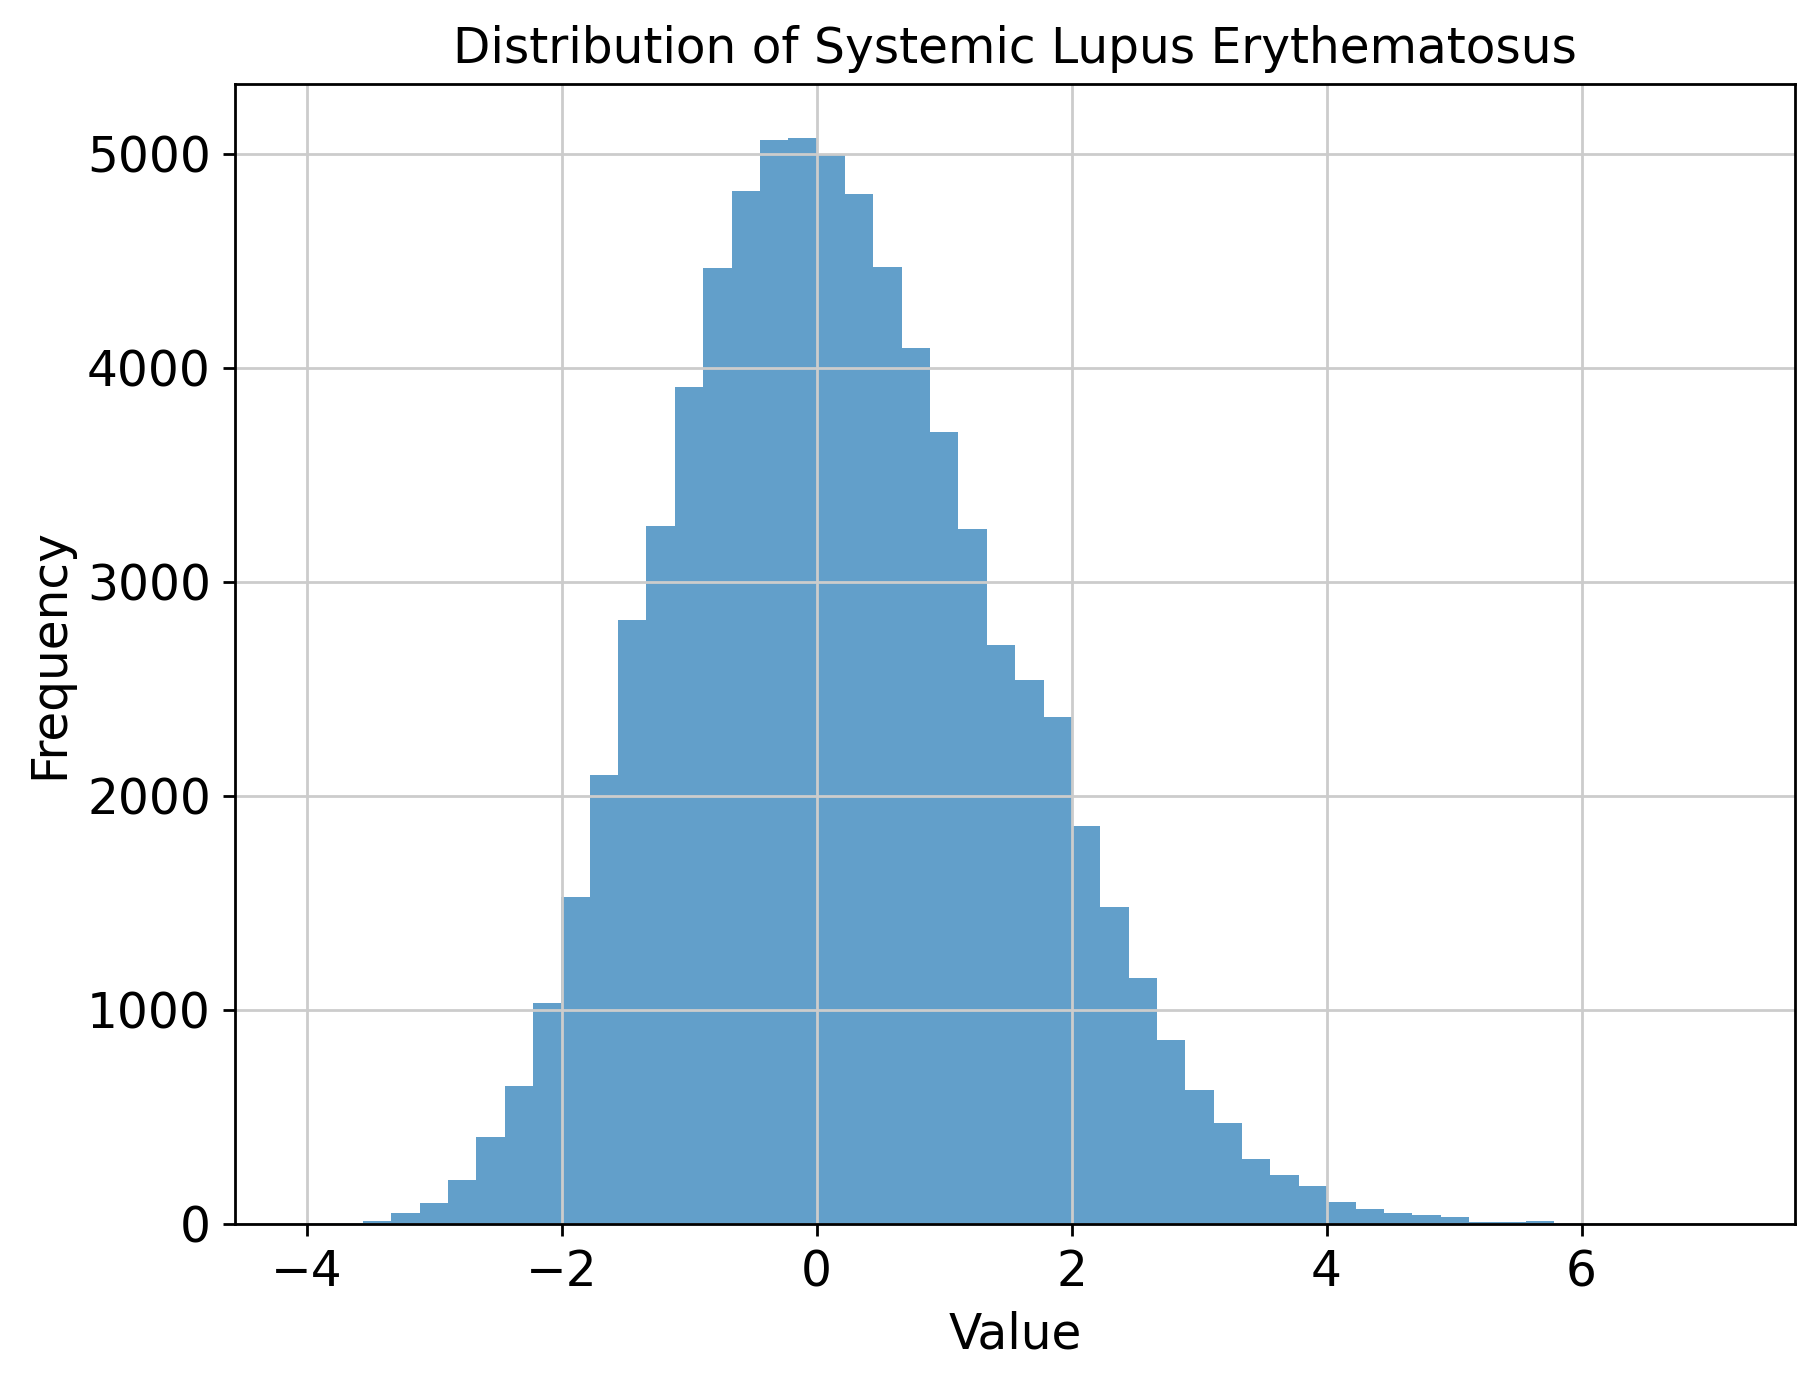

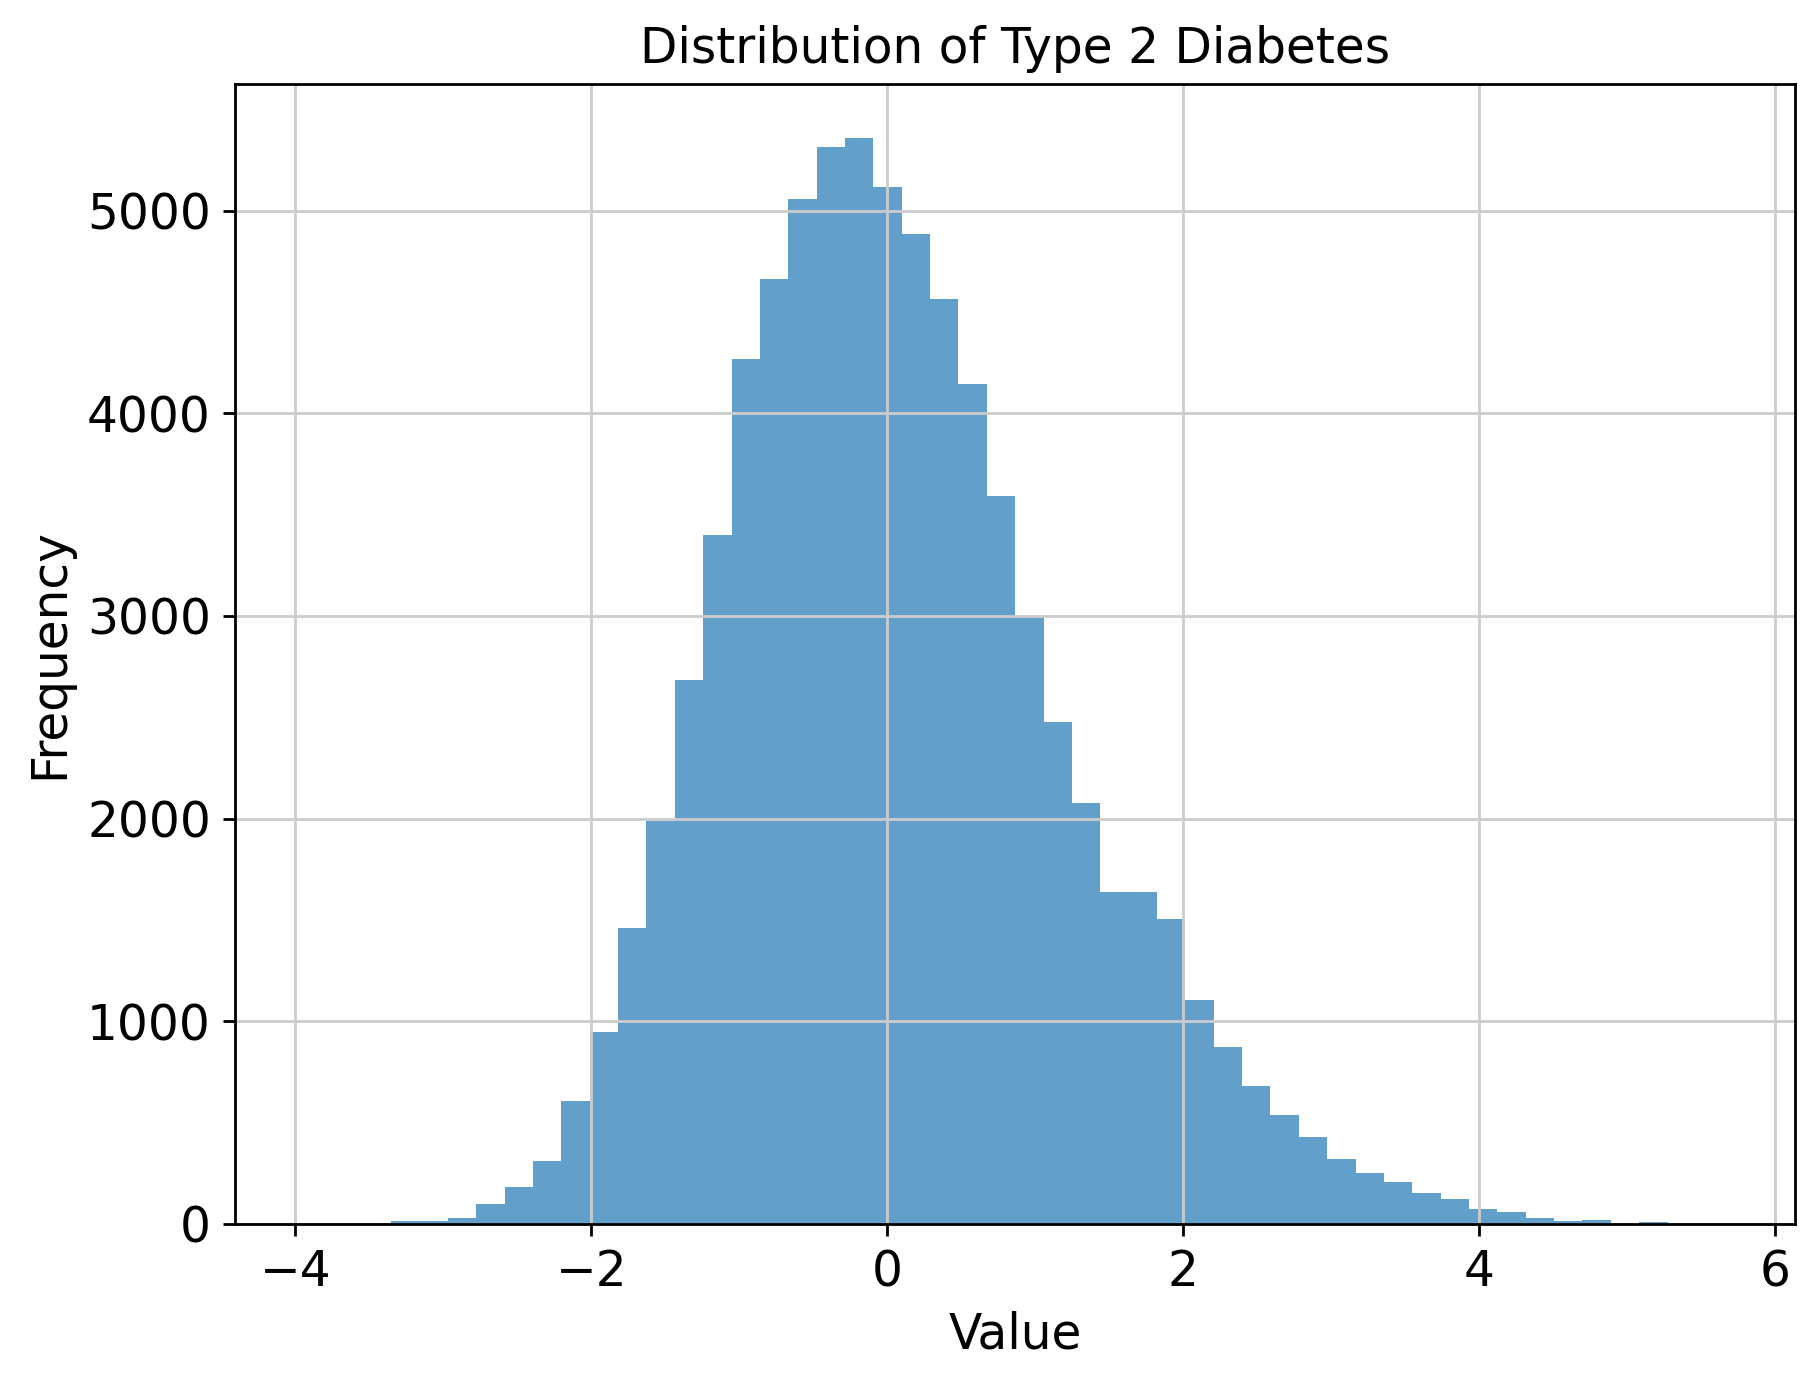

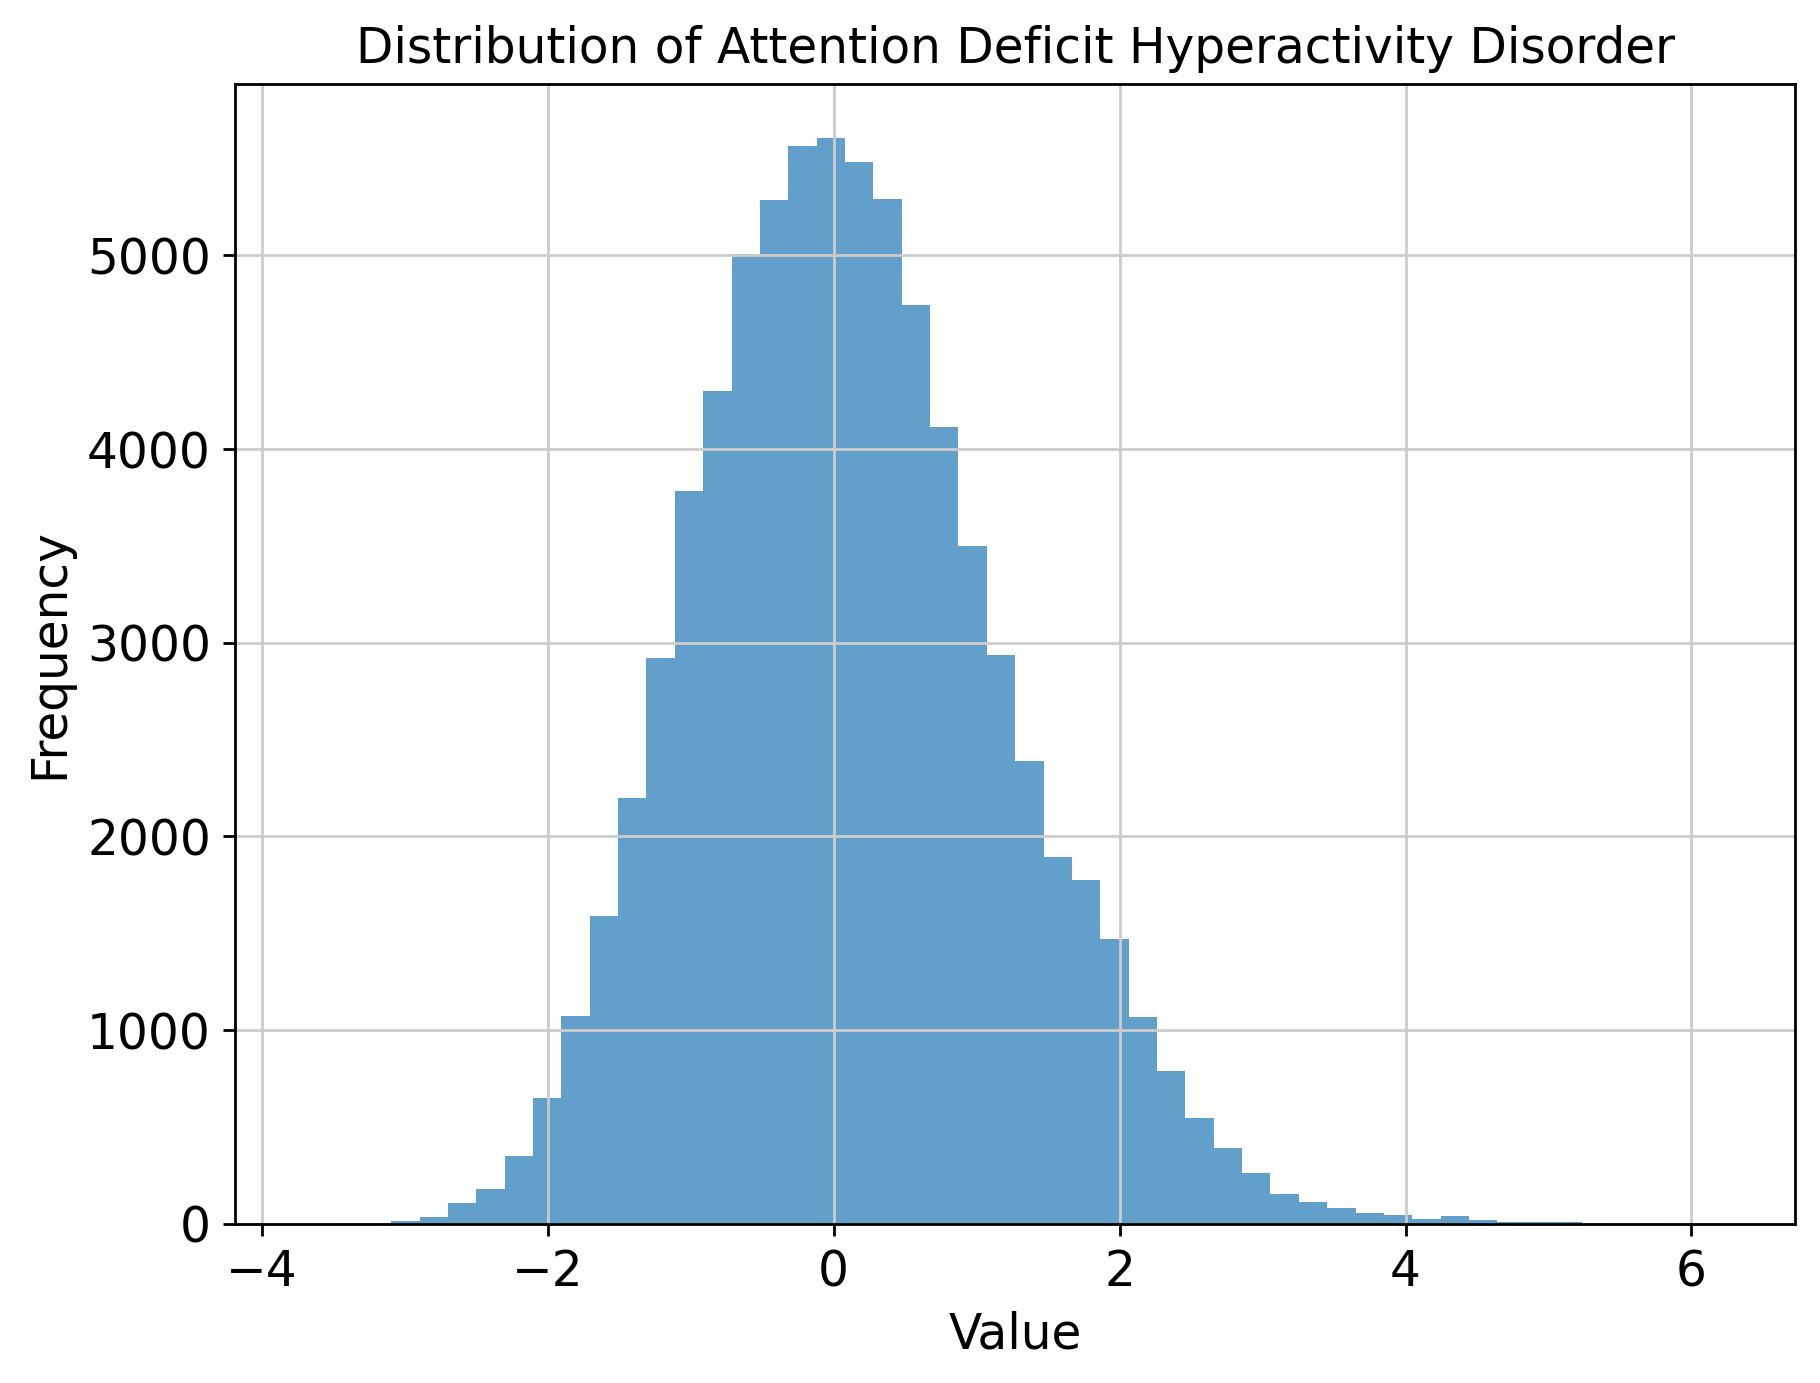

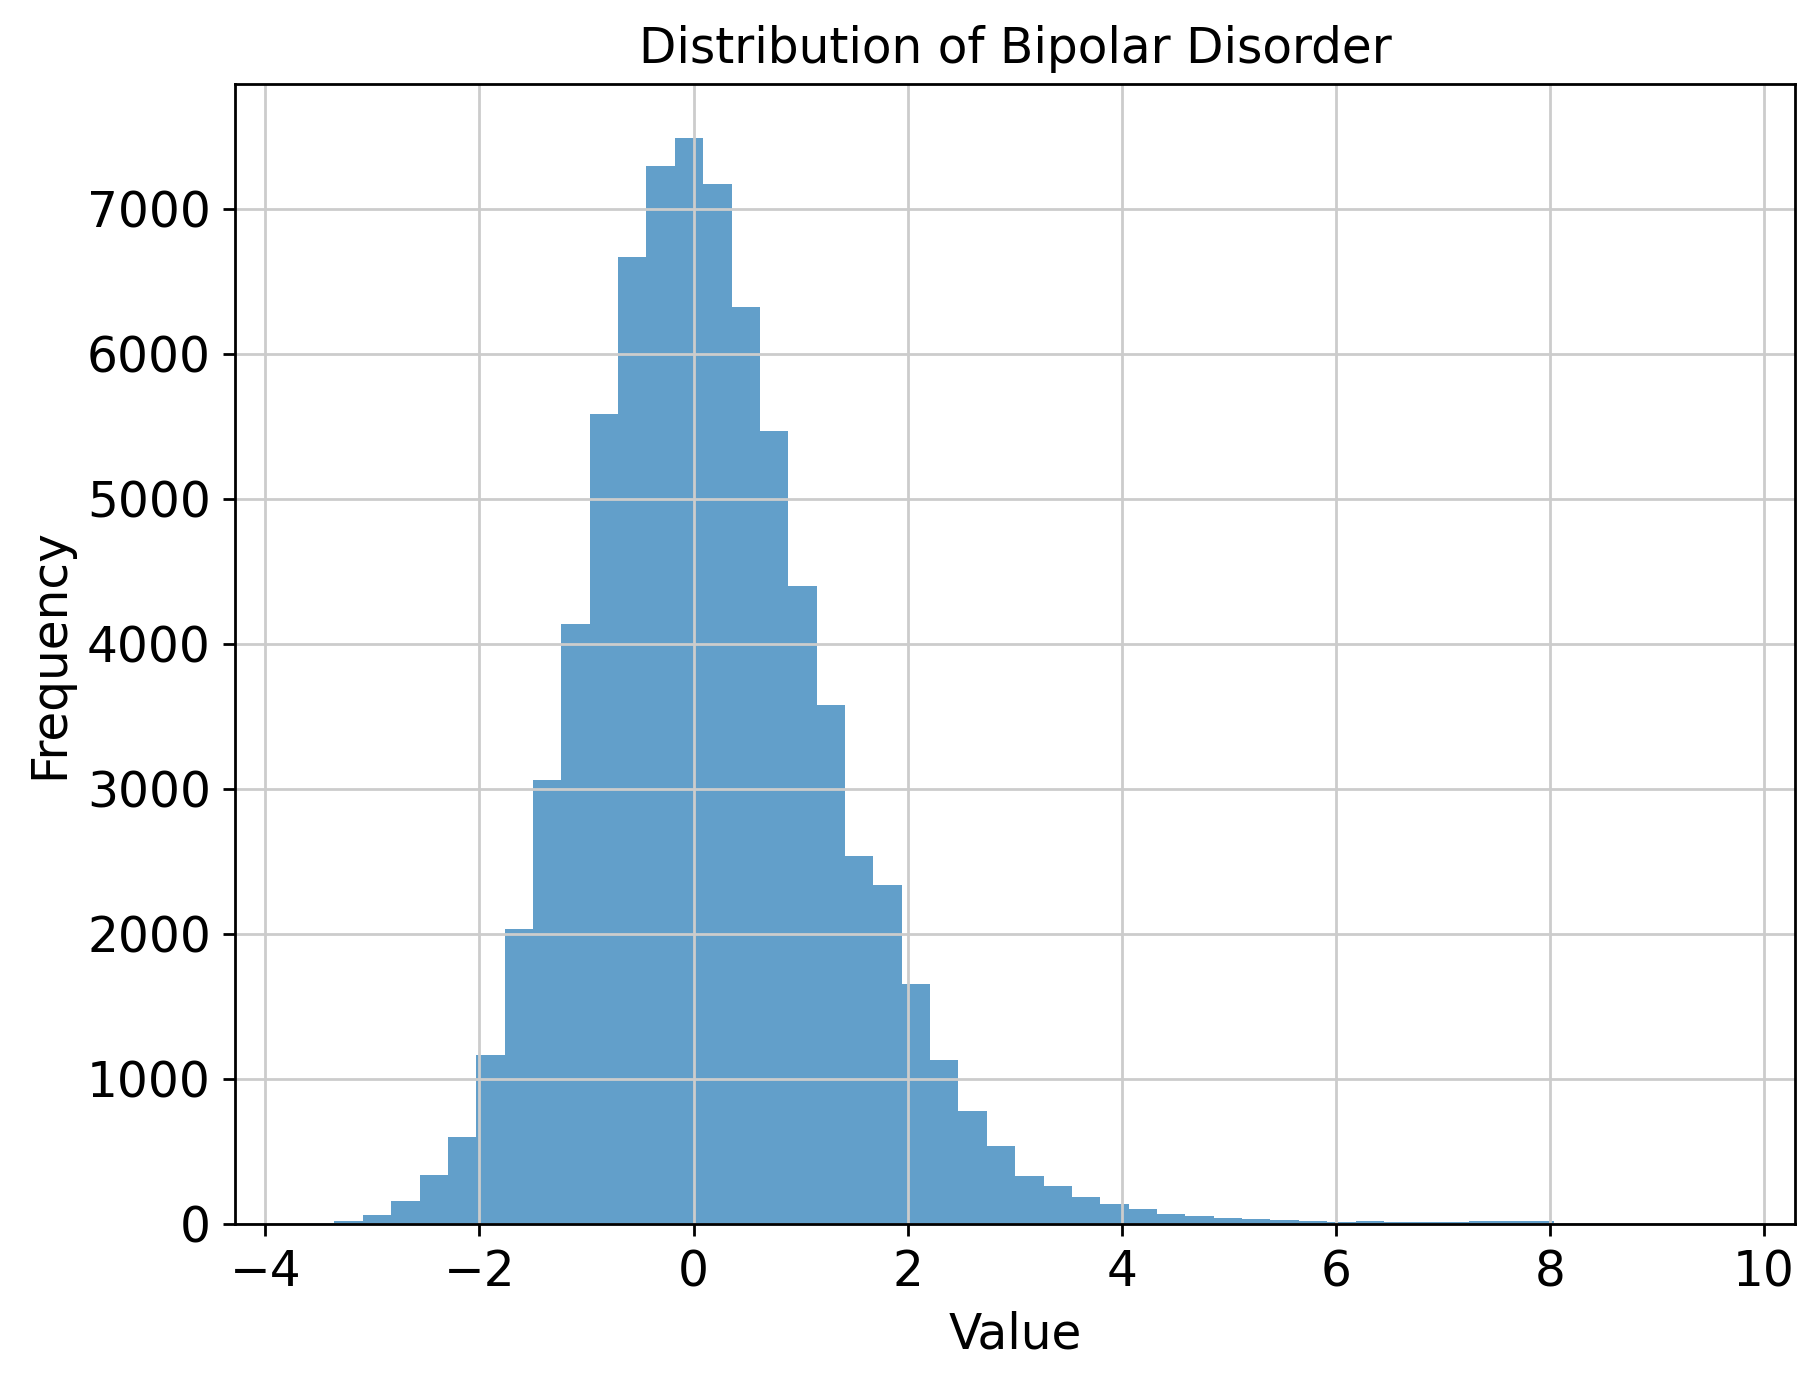

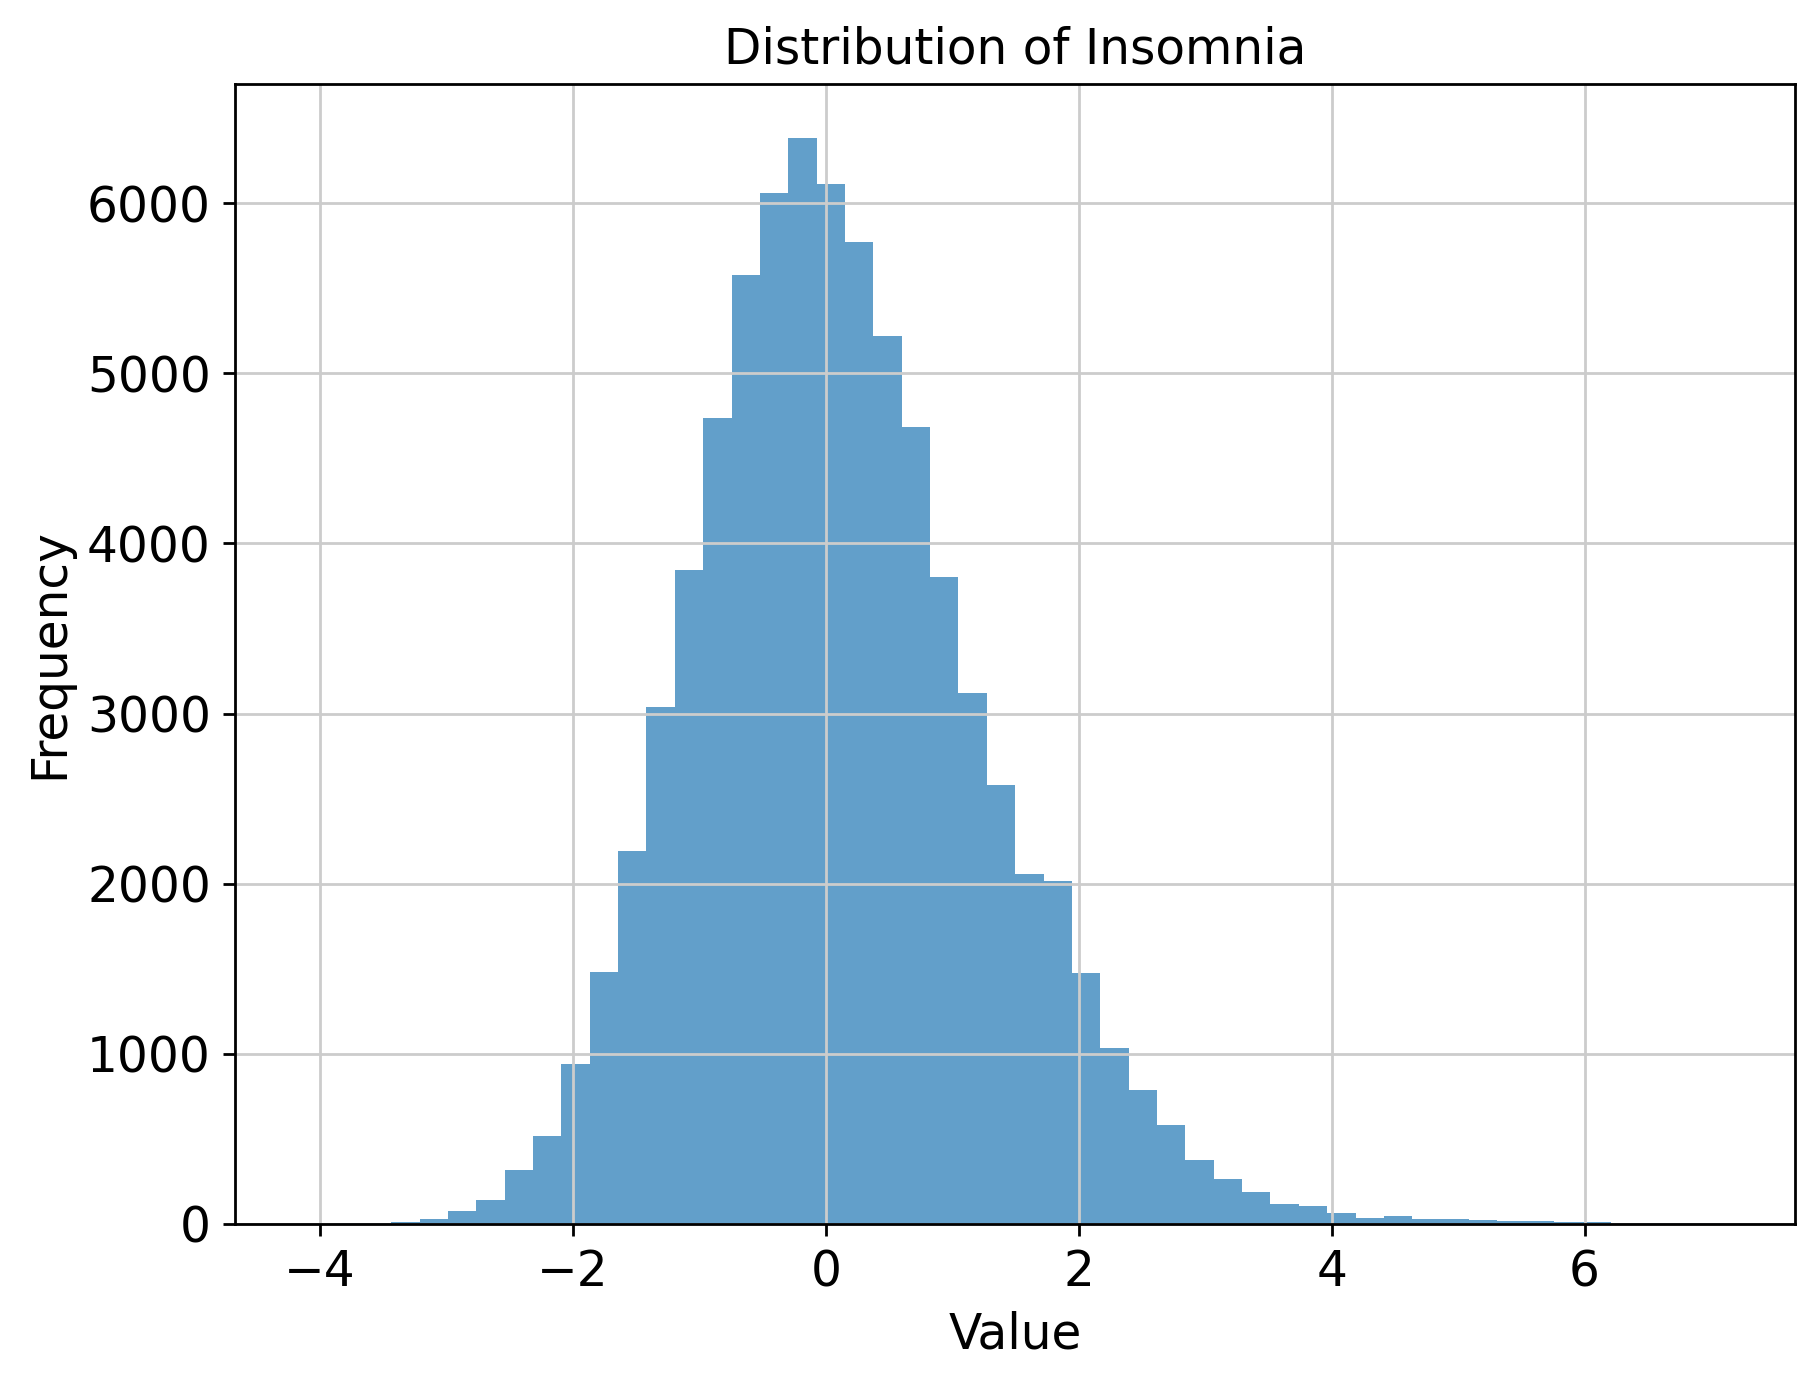

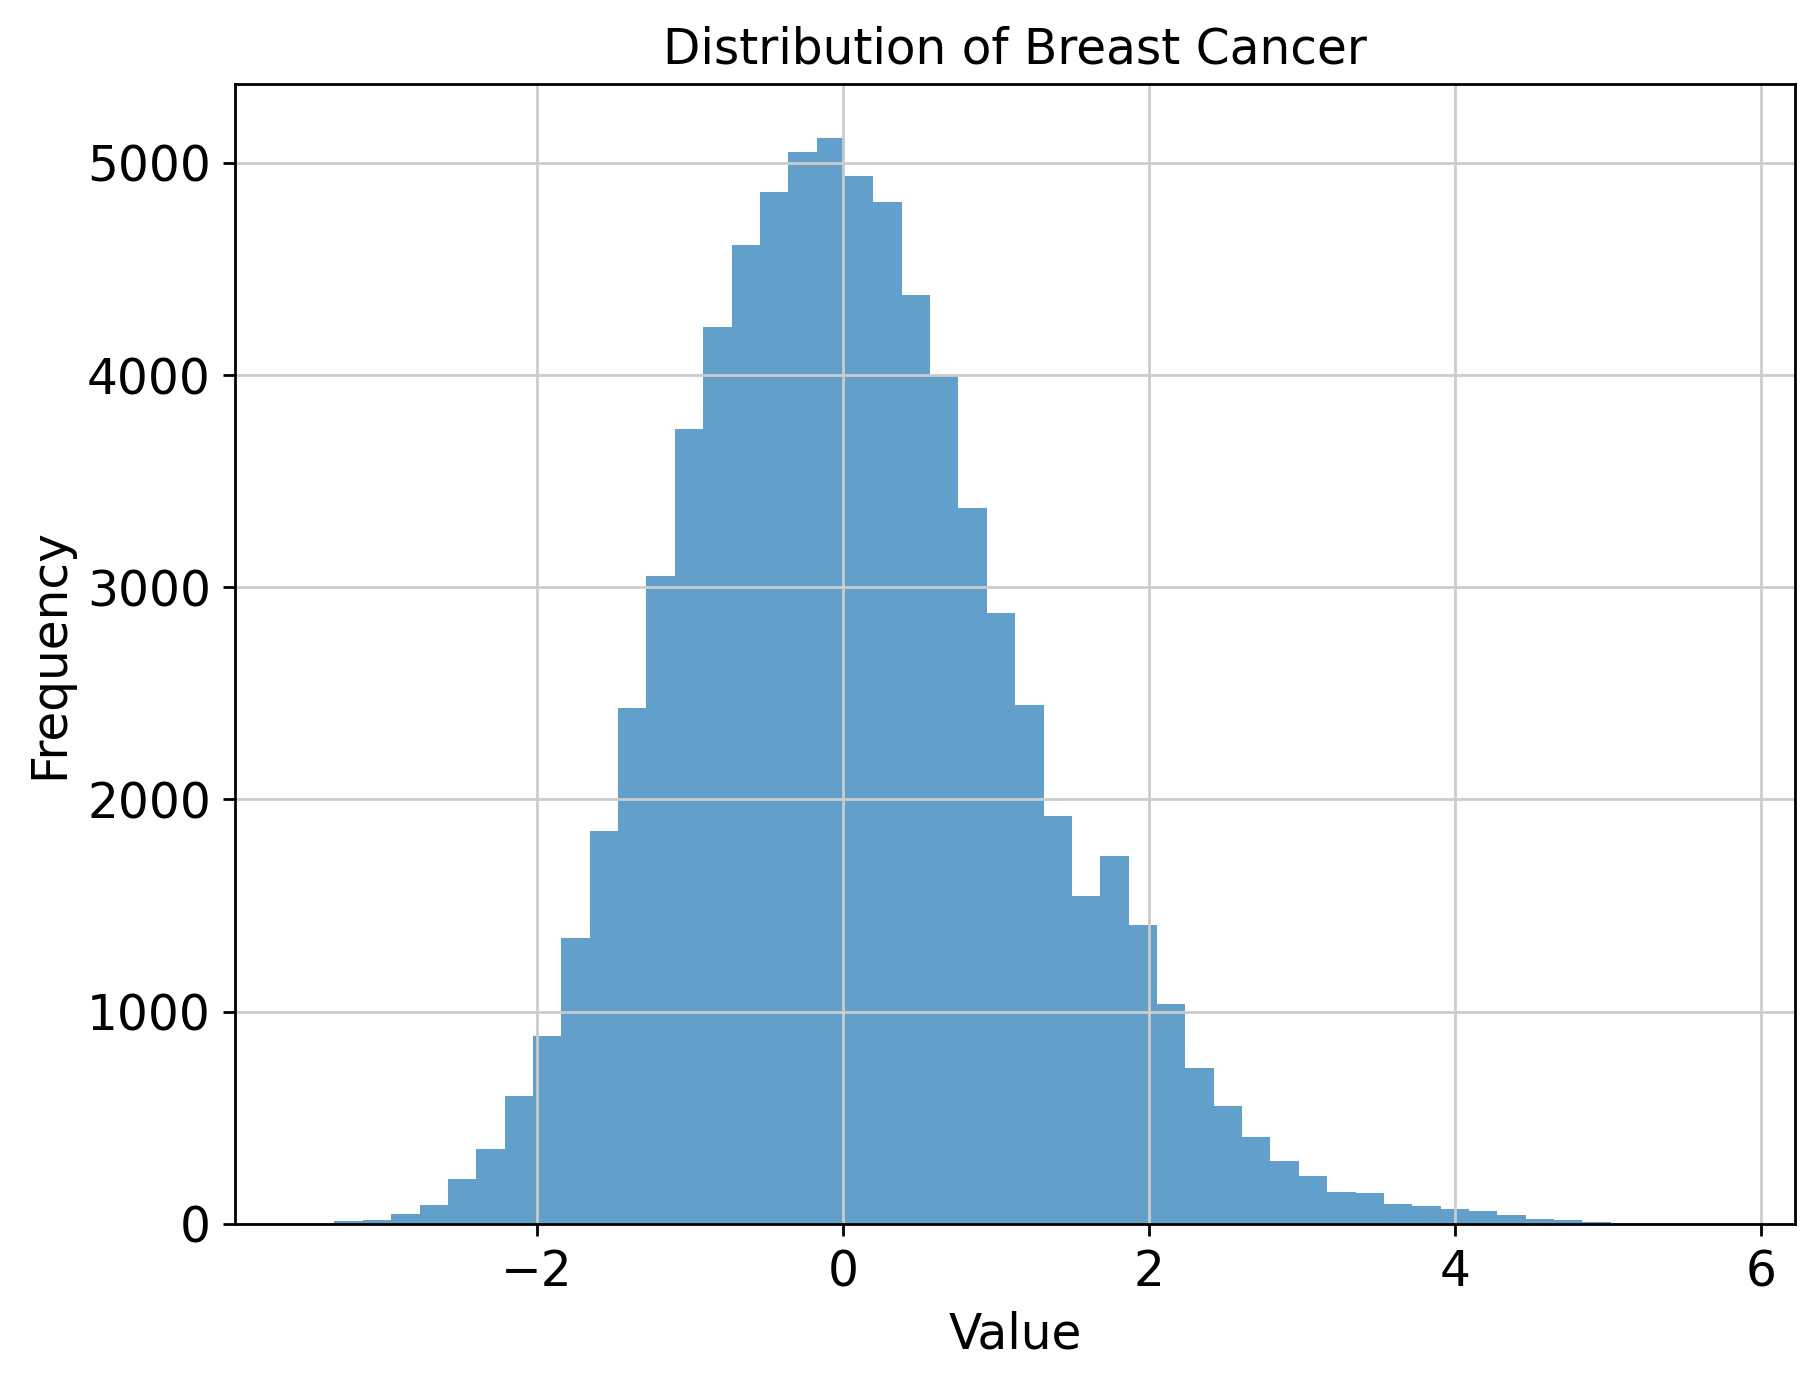

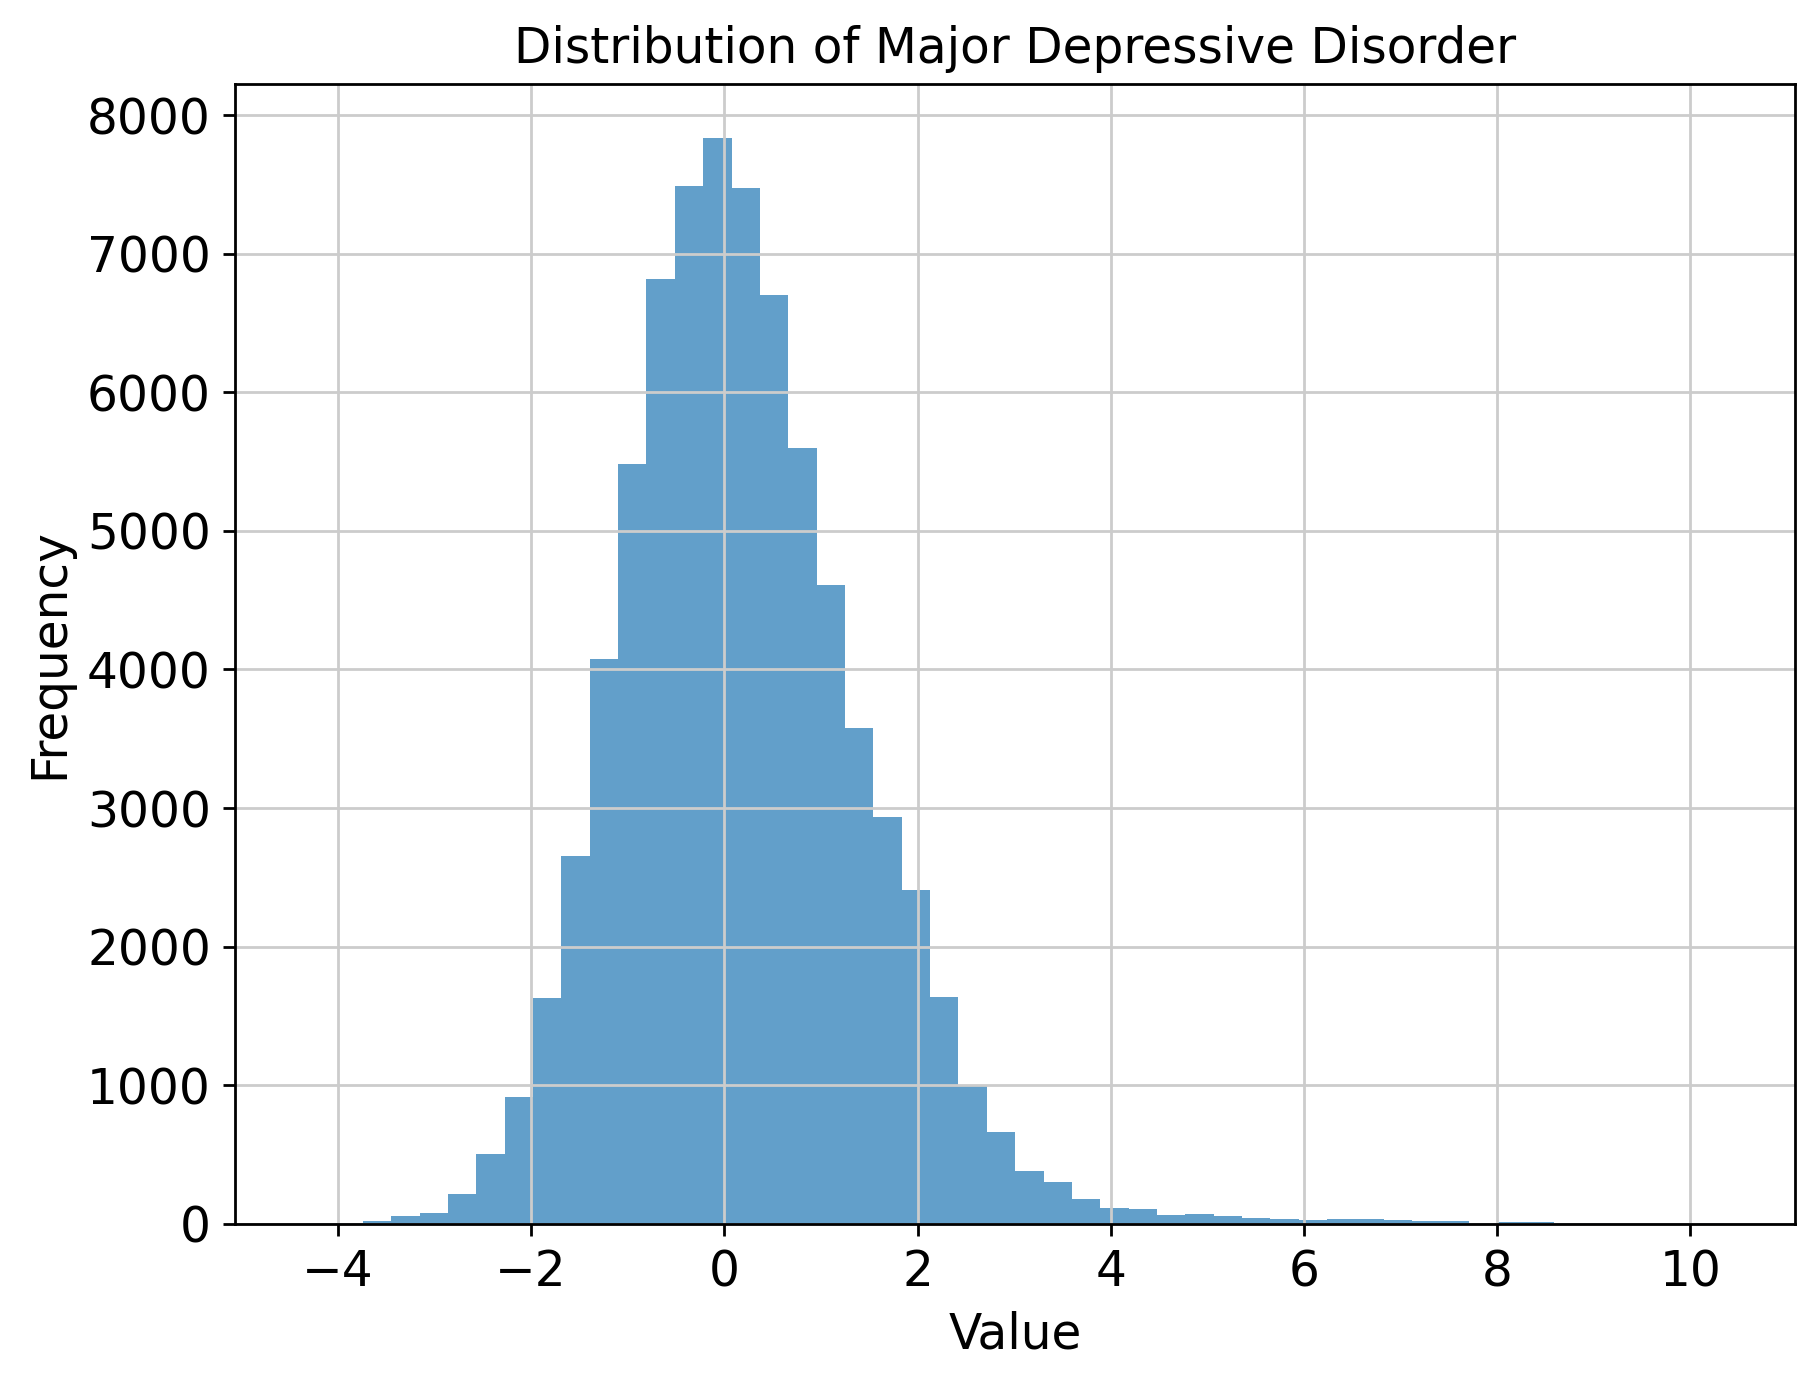

In [60]:
import matplotlib.pyplot as plt

# Iterate through each disease(column) in obsm
for i in range(data.obsm['disease_scores'].shape[1]):

    plt.figure(figsize=(8, 6))
    
    plt.hist(data.obsm['disease_scores'].iloc[:, i], bins=50, alpha=0.7)
    
    plt.title(f'Distribution of {data.obsm['disease_scores'].columns[i]}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.show()